In [29]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u
from astropy.visualization import simple_norm
from astropy.visualization import ZScaleInterval
from scipy.ndimage import gaussian_filter
from astropy.stats import mad_std
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from photutils.aperture import SkyCircularAperture
from photutils.aperture import aperture_photometry
import os

# Funciones de Recortes

In [30]:
def choosef(RA, DEC, data):  # elige el campo donde estén las coordenadas
    # print(len(RA))

    COSMOS_NB = []
    for i in range(len(data)):
        field = data['Field'][i]
        R_min = data['RA_min'][i]
        R_max = data['RA_max'][i]
        D_min = data['DEC_min'][i]
        D_max = data['DEC_max'][i]

        for i in range(len(RA)):
            if RA[i] >= R_min and RA[i] <= R_max and DEC[i] >= D_min and DEC[i] <= D_max:
                COSMOS_NB.append([RA[i], DEC[i]])

    return COSMOS_NB  # retorna el field


# función cristobal
def random_apers(data):
    x = np.random.uniform(2200, 12000, 15000)
    y = np.random.uniform(2100, 10000, 15000)
    apers = CircularAperture([i for i in zip(x, y)], r=3.5/2)
    phot = aperture_photometry(data, apers)  # ,mask=kekazo)
    return phot

# función amanda


def get_names(coord):
    id_general = []
    for i in range(len(coord)):
        c = SkyCoord(ra=coord[i][0]*u.degree, dec=coord[i][1]*u.degree)
        ra = c.ra.hms
        dec = c.dec.dms
        h = round(ra[0]) < 10
        m1 = round(ra[1]) < 10
        s1 = round(ra[2]) < 10
        d = round(dec[0]) < 10
        m2 = round(dec[1]) < 10
        s2 = round(dec[2]) < 10
        lista = [[h, ra[0]], [m1, ra[1]], [s1, ra[2]],
                 [d, dec[0]], [m2, dec[1]], [s2, dec[2]]]
        contador = 0
        l = 'J'
        for j in lista:
            if contador <= 2:
                if j[0] == True:
                    l = l+'0'+str(int(round(j[1])))
                    contador += 1
                if j[0] == False:
                    l = l+str(int(round(j[1])))
                    contador += 1
            elif contador == 3:
                if j[0] == True:
                    l = l+'+0'+str(int(round(j[1])))
                    contador += 1
                if j[0] == False:
                    l = l+'+'+str(int(round(j[1])))
                    contador += 1
            elif contador >= 4:
                if j[0] == True:
                    l = l+'0'+str(int(round(j[1])))
                    contador += 1
                if j[0] == False:
                    l = l+str(int(round(j[1])))
                    contador += 1
        id_general.append(l)
    return id_general


def radec_minmax(hdr, coords): #guarda ra y dec mínimo y máximo
    wcs = WCS(hdr)
    c = [wcs.pixel_to_world(*coord) for coord in coords]
    ra_min = min([x.ra.deg for x in c])
    ra_max = max([x.ra.deg for x in c])
    
    dec_min = min([x.dec.deg for x in c])
    dec_max = max([x.dec.deg for x in c])
    
    return [ra_min, ra_max, dec_min, dec_max]

## Datos

In [31]:
NSF_NB = fits.open('Fields/nsf_nb964_sci.fits')
data_NB = NSF_NB[1].data
hdr_NB = NSF_NB[1].header

NSF_g = fits.open('Fields/nsf_g_sci.fits')
data_g = NSF_g[1].data
hdr_g = NSF_g[1].header

NSF_r = fits.open('Fields/nsf_r_sci.fits')
data_r = NSF_r[1].data
hdr_r = NSF_r[1].header

NSF_i = fits.open('Fields/nsf_i_sci.fits')
data_i = NSF_i[1].data
hdr_i = NSF_i[1].header

NSF_z = fits.open('Fields/nsf_z_sci.fits')
data_z = NSF_z[1].data
hdr_z = NSF_z[1].header

NSF_y = fits.open('Fields/nsf_y_sci.fits')
data_y = NSF_y[1].data
hdr_y = NSF_y[1].header

In [32]:
coords = [(0,0),(32000,0),(0,32000),(32000,32000)] #tamaño imagen
rd_NB = radec_minmax(hdr_NB, coords)

In [33]:
with open('Fields.txt', "w+") as f:
    f.write("Field RA_min RA_max DEC_min DEC_max\n")
    f.write(f"NSF_NB {rd_NB[0]} {rd_NB[1]} {rd_NB[2]} {rd_NB[3]}\n")
    #f.write(f"NSF_g {rd_g[0]} {rd_g[1]} {rd_g[2]} {rd_g[3]}")

In [34]:
info = pd.read_csv('Fields.txt', sep = " ")
info

Field      RA_min      RA_max    DEC_min    DEC_max
0  NSF_NB  313.917475  320.107303 -67.185343 -64.788871

In [35]:
from astropy.table import Table
coord = Table.read('LAES_4_Sangeeta.fits')
coord

RA = coord['ALPHA_J2000_1']
DEC = coord['DELTA_J2000_1']

## Recortes individuales

In [36]:
def cuts(coords, data, hdr, size, field, filter_used):

    # el path en el cual guardaremos las imágenes
    path = os.path.join('Cutouts', str(field)+'_'+str(filter_used))

    aper = random_apers(data)
    sums = aper['aperture_sum']
    clipped = sigma_clipped_stats(sums, sigma=2)
    sigmac = clipped[2]
    # nos retorna la desviación estandar que ocuparemos para que se vean bien los lya en los recortes
    print(sigmac)

    names = get_names(coords)  # función amanda

    for i in range(len(coords)):

        path_N = os.path.join(path, names[i]+'_'+str(filter_used))

        m_wcs = WCS(hdr)
        c = SkyCoord(coords[i][0], coords[i][1], frame=FK5, unit="deg")

        recorte = Cutout2D(data, c, (size*u.arcsec, size*u.arcsec), wcs=m_wcs)
        im = (recorte.data)
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        #norm = simple_norm(im, max_percent=99.9, min_percent=1)
        ax.imshow(im, origin='lower', interpolation='nearest',
                  cmap='Greys', vmin=-1*sigmac, vmax=3*sigmac)  # , norm = norm)
        #plt.scatter((len(recorte.data)/2), len(recorte.data) /
                    #2-9, marker='|', color='red', s=300)
        #plt.scatter((len(recorte.data)/2)-10, len(recorte.data) /
                    #2, marker='_', color='red', s=300)
        plt.axis('off')
        #plt.savefig(path_N, transparent=False, facecolor='white')

        plt.show()
        print(path_N)

    return

0.2572414608833054


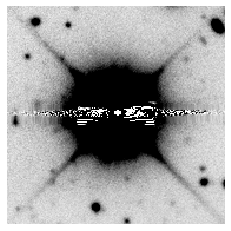

Cutouts/NSF_NB/J211203+0-650-100-52_NB


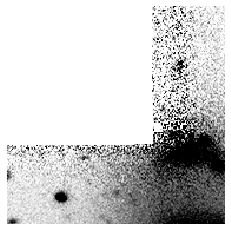

Cutouts/NSF_NB/J211417+0-650-120-43_NB


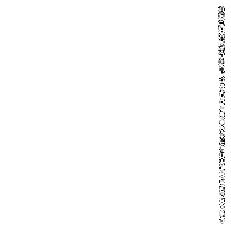

Cutouts/NSF_NB/J211249+0-650-10-8_NB


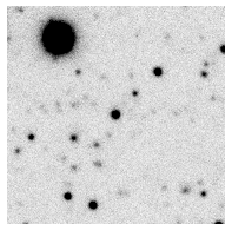

Cutouts/NSF_NB/J211235+0-650-90-19_NB


In [37]:
RA_i = [318.01240654553413,318.57034320368325,318.2041128350889,318.14514807798014]

DEC_i = [-65.18097864429818,-65.21184135164788, -65.01875322965974, -65.15540720124692]

nsf_id = choosef(RA_i,DEC_i,info)
NSF_cut = cuts(nsf_id, data_i, hdr_NB, 50, 'NSF' , 'NB')

## Recortes múltiples

In [52]:
def cuts_mult(coords, data_filters, hdr_filters, names_filters, flux_filters, size, field):

    #data_filters = datag,datar,datai,dataz,datay, datanb
    #hdr_filters = hdrg, hdrr, hdri, hdrz, hdry, hdrnb
    # el path en el cual guardaremos las imágenes
    path = os.path.join('Cutouts', str(field))

    aper = random_apers(data_filters[-1])
    sums = aper['aperture_sum']
    clipped = sigma_clipped_stats(sums, sigma=2)
    sigmac = clipped[2]
    # nos retorna la desviación estandar que ocuparemos para que se vean bien los lya en los recortes
    print(sigmac)

    names = get_names(coords)  # función amanda

    for i in range(len(coords)):

        path_N = os.path.join(path, names[i])

        fig, ax = plt.subplots(1, 6, figsize=(20, 8))

        for x, data in enumerate(data_filters):
           # print(x,(x+1)//5, x-((x+1)//5 *5))
            m_wcs = WCS(hdr_filters[x])
            c = SkyCoord(coords[i][0], coords[i][1], frame=FK5, unit="deg")
            recorte = Cutout2D(
                data, c, (size*u.arcsec, size*u.arcsec), wcs=m_wcs)
            im = (recorte.data)
#ax[(x)//5, x-((x)//5 * 5)]
            ax[x].imshow(im, origin='lower', interpolation='nearest',
                                              cmap='Greys', vmin=-1*sigmac, vmax=3*sigmac)  # , norm = norm)
            ax[x].scatter((len(recorte.data)/2),
                                               len(recorte.data)/2-9, marker='|', color='red', s=300)
            ax[x].scatter((len(recorte.data)/2) -
                                               10, len(recorte.data)/2, marker='_', color='red', s=300)
            ax[x].set_title(names_filters[x], fontsize=18)
            ax[x].axis('off')

#         ax[1, 1].set_axis_off()
#         ax[1, 2].set_axis_off()
#         ax[1, 3].set_axis_off()
#         ax[1, 4].set_axis_off()

        #plt.savefig(path_N, transparent=False, facecolor='white')
        fig.tight_layout()
        plt.show()
        
        fig, ax= plt.subplots(figsize =(12,8))
        pivot = np.array([4770.80, 6371.30, 7774.20, 9157.90, 9640.00, 9886.30]) #g,r,i,z,NB,y,
        lines = np.array([flux_filters[0][i],flux_filters[1][i],flux_filters[2][i], flux_filters[3][i],flux_filters[4][i],flux_filters[5][i]])
        ax.scatter(pivot[0], flux_filters[0][i], label = 'g')
        ax.scatter(pivot[1], flux_filters[1][i], label = 'r')
        ax.scatter(pivot[2], flux_filters[2][i], label = 'i')
        ax.scatter(pivot[3], flux_filters[3][i], label = 'z')
        ax.scatter(pivot[4], flux_filters[4][i], label = 'NB')
        ax.scatter(pivot[5], flux_filters[5][i], label ='y')


        ax.set_xlabel('Wavelenght')
        ax.set_ylabel('Flux')
        ax.plot(pivot,lines, linestyle = 'dashed', color = 'slategray')
        plt.legend()
        plt.show()
        # print(path_N)

    return

In [43]:
data = Table.read('NSF_mask.fits') 

In [44]:
aper =2
g = np.array([data['FLUX_APER_g'][i][aper] for i in range(len(data))])

r = np.array([data['FLUX_APER_r'][i][aper] for i in range(len(data))])

i = np.array([data['FLUX_APER_i'][i][aper] for i in range(len(data))])

z = np.array([data['FLUX_APER_z'][i][aper] for i in range(len(data))])

y = np.array([data['FLUX_APER_y'][i][aper] for i in range(len(data))])

NB = np.array([data['FLUX_APER'][i][aper] for i in range(len(data))])

1.077970942854337


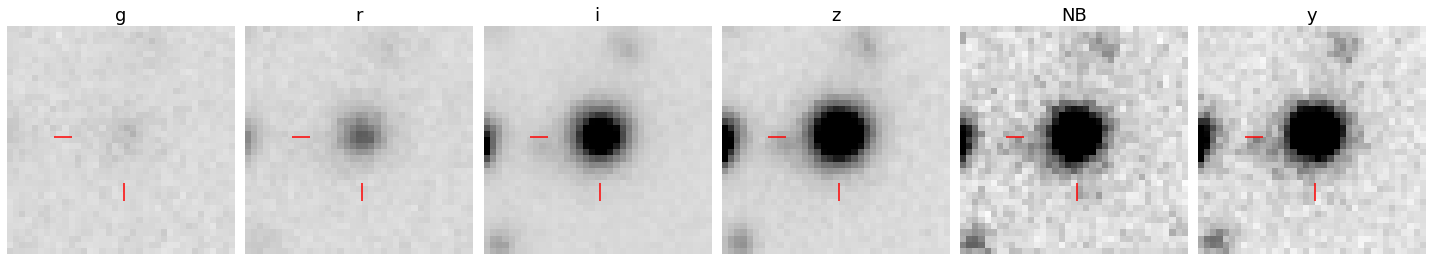

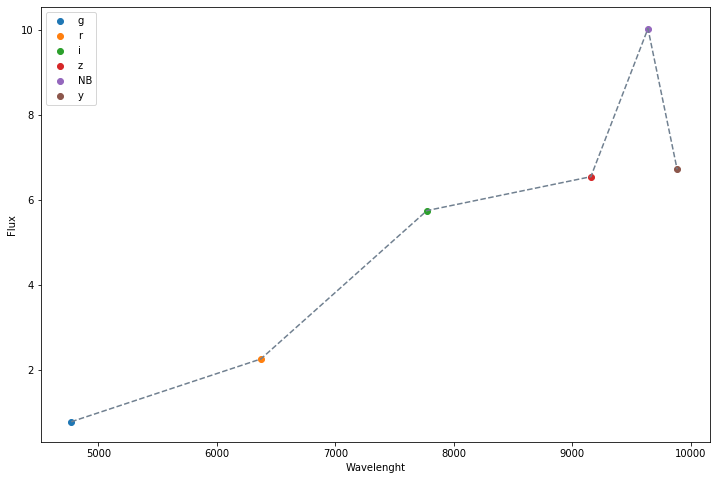

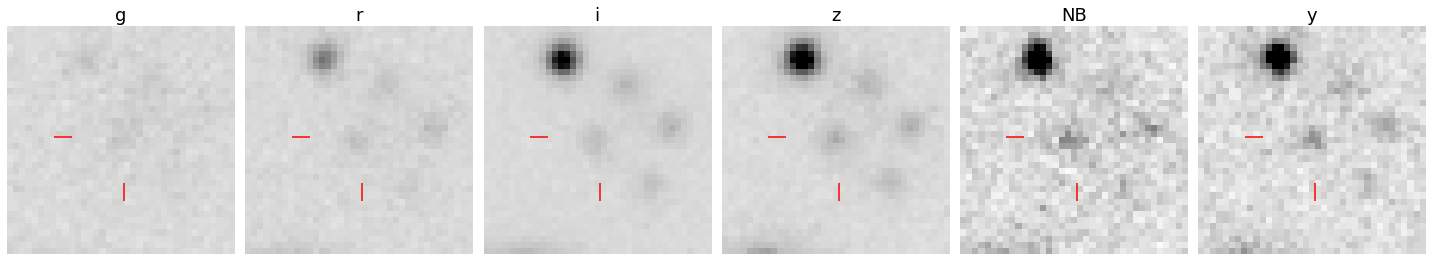

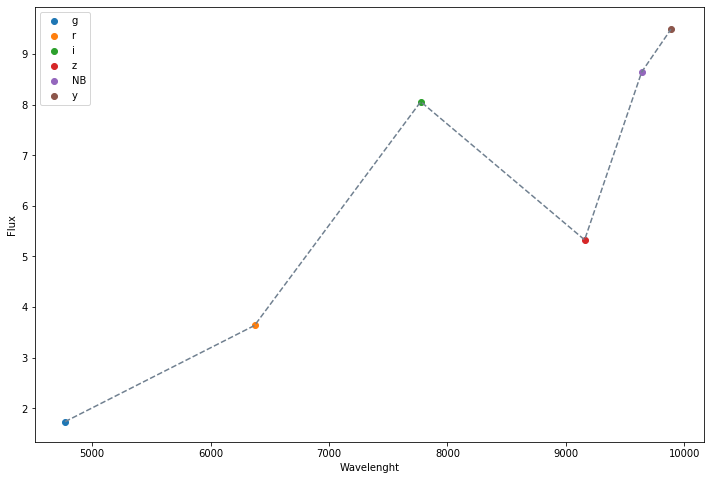

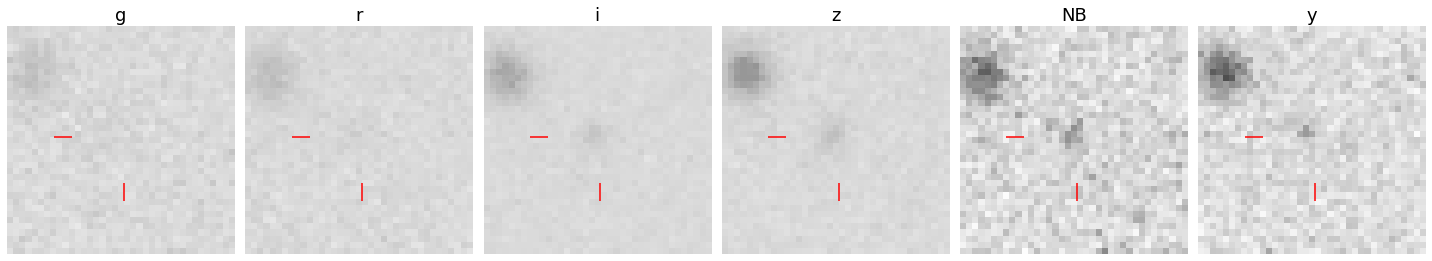

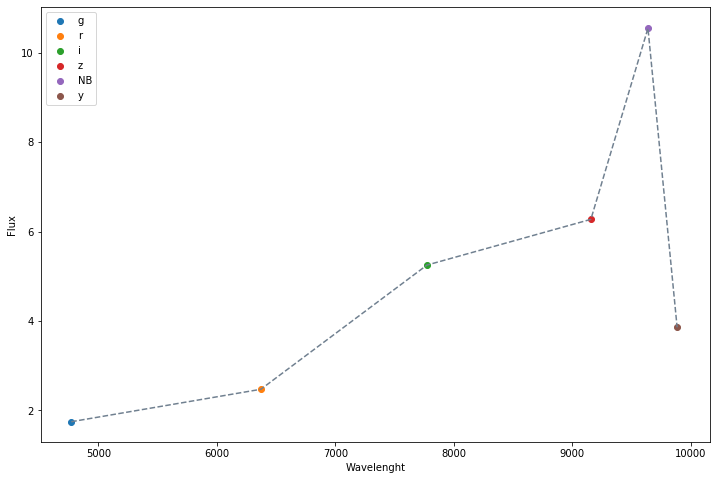

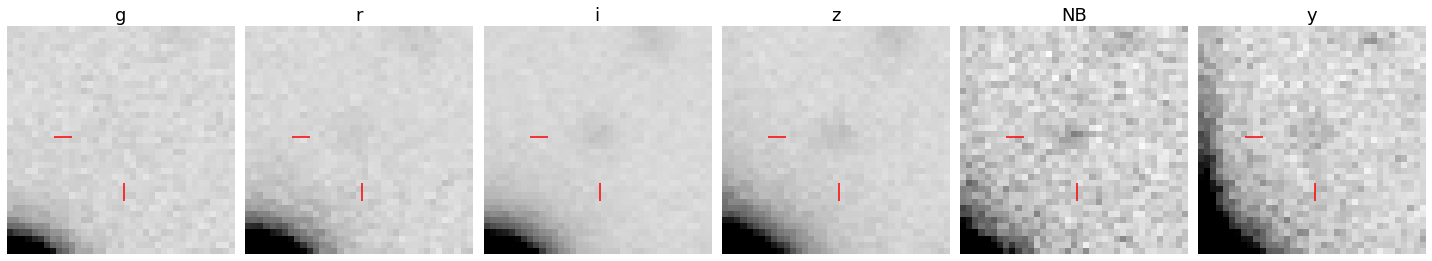

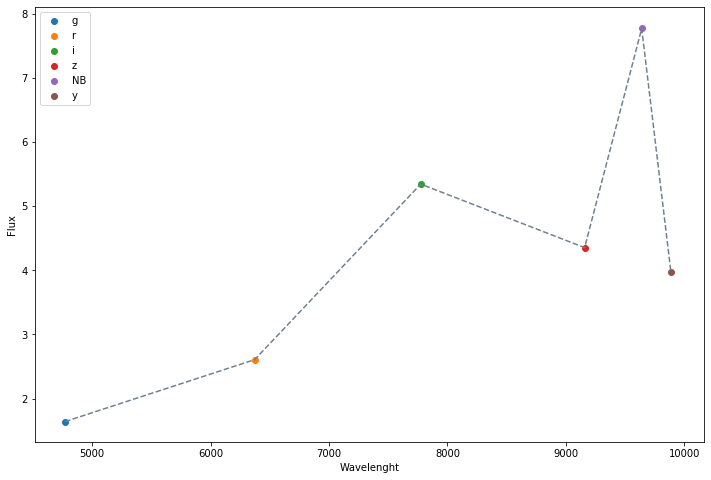

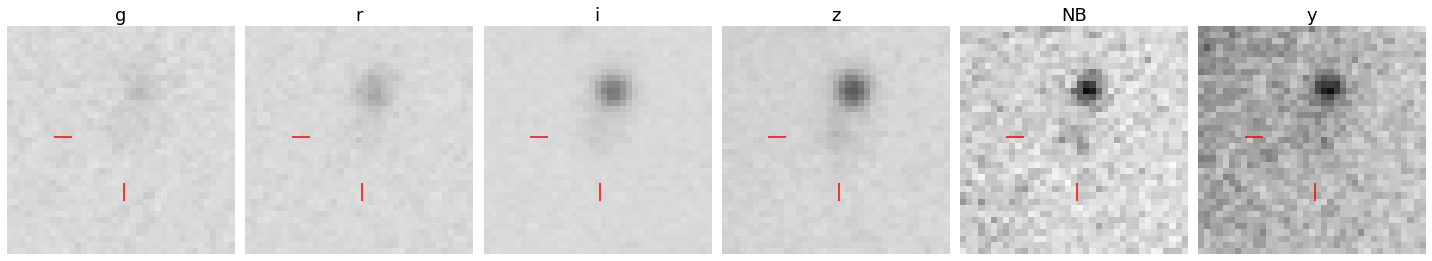

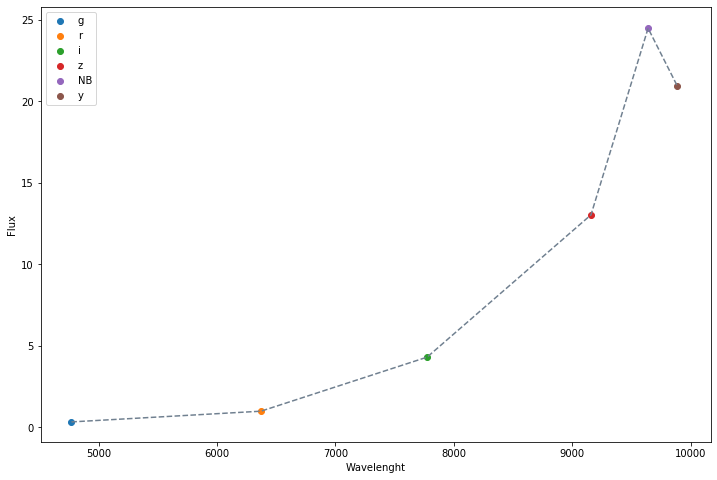

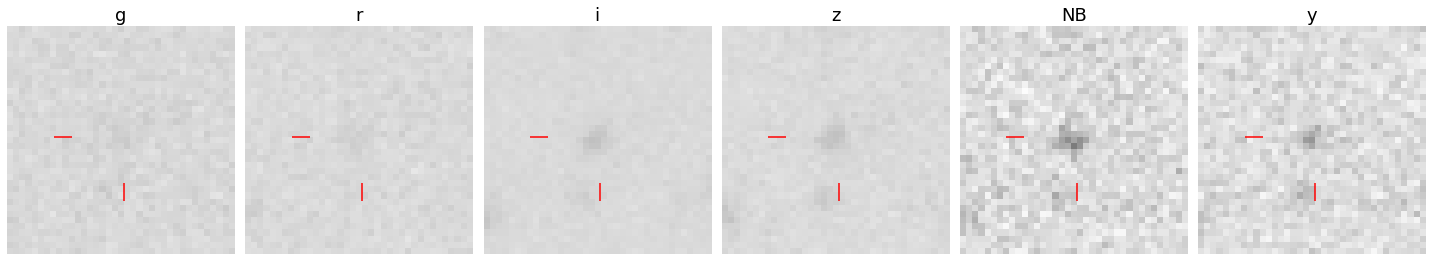

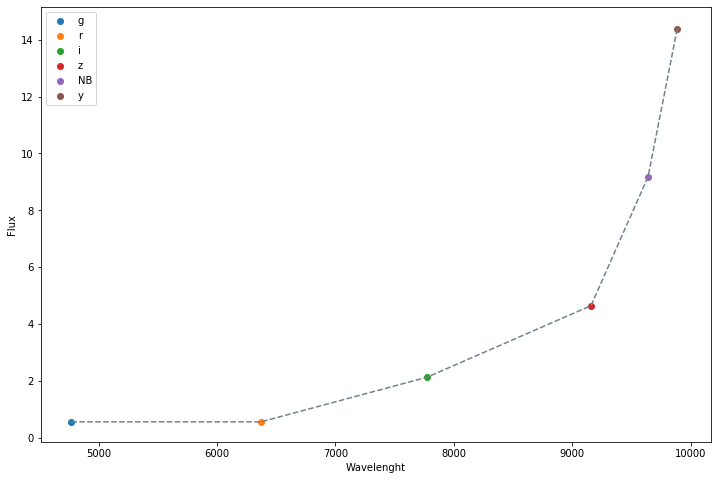

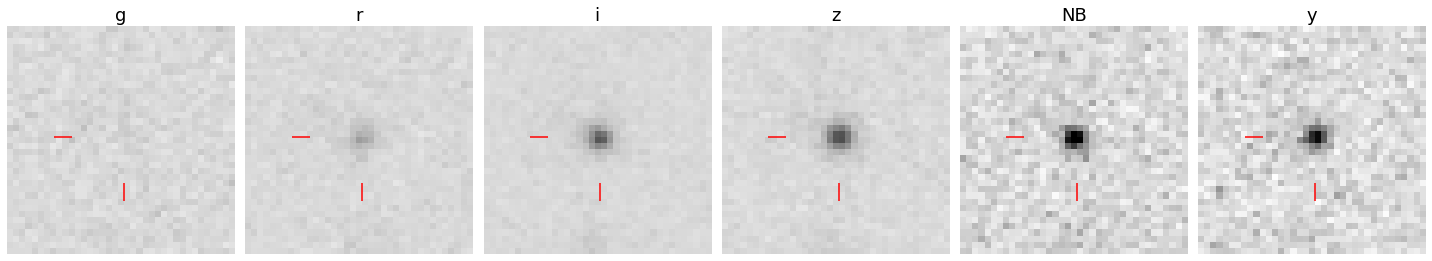

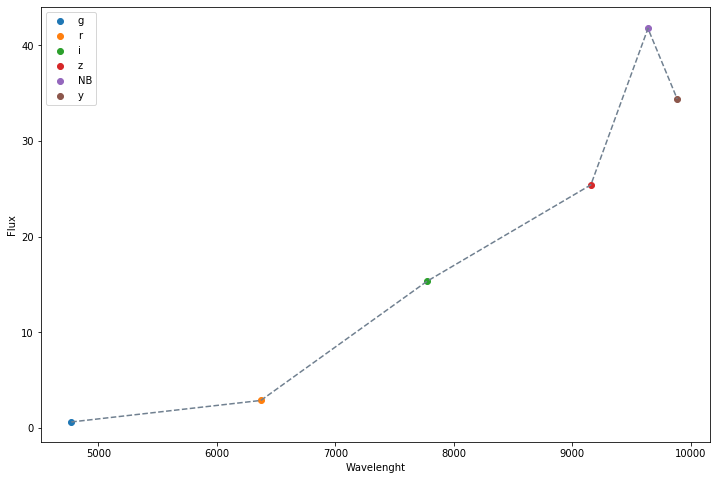

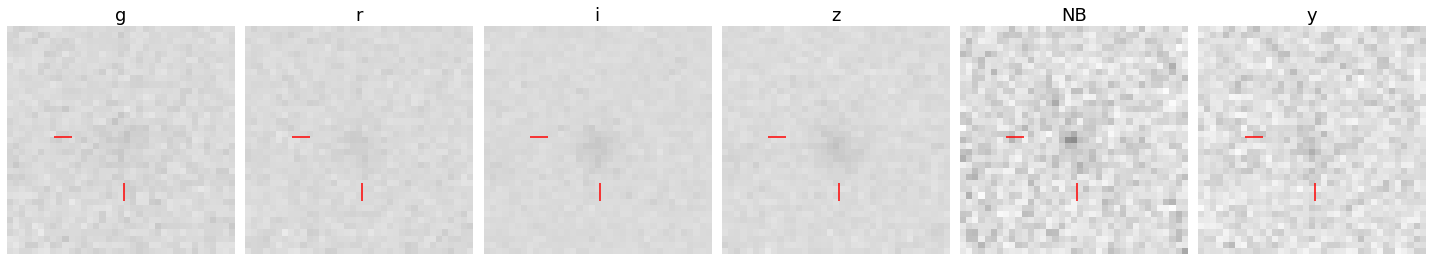

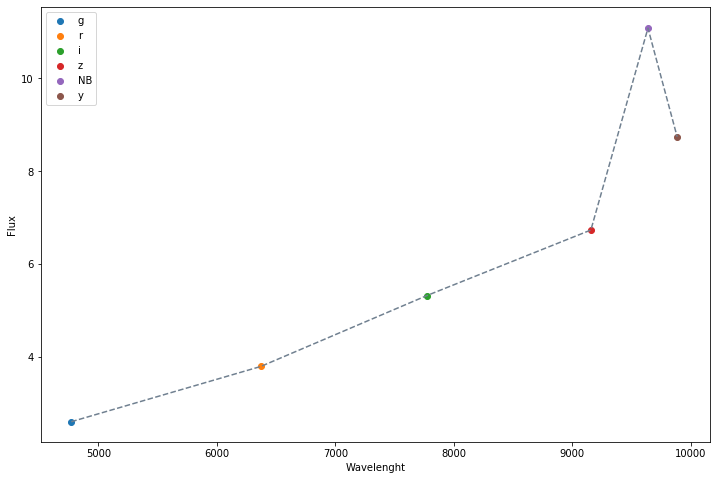

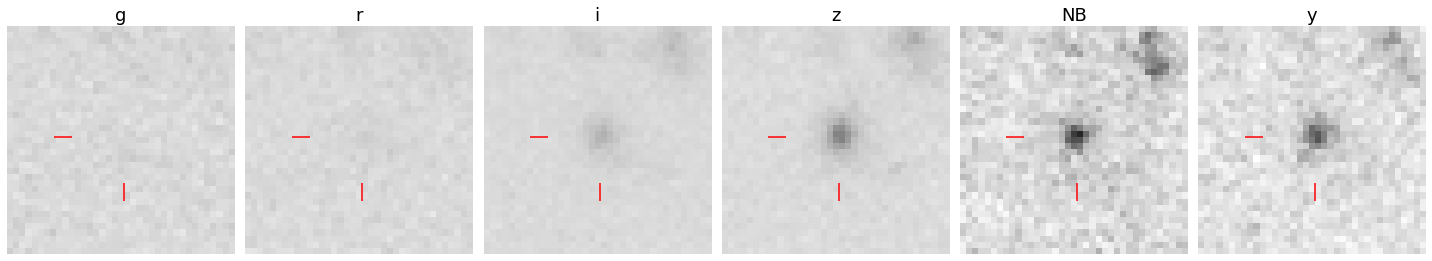

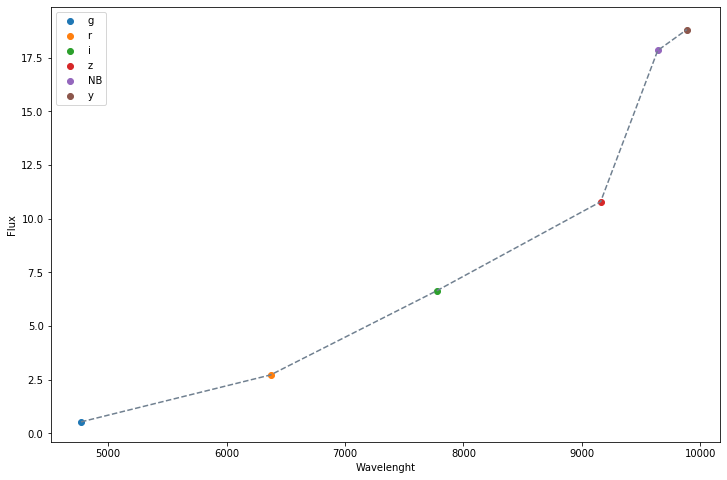

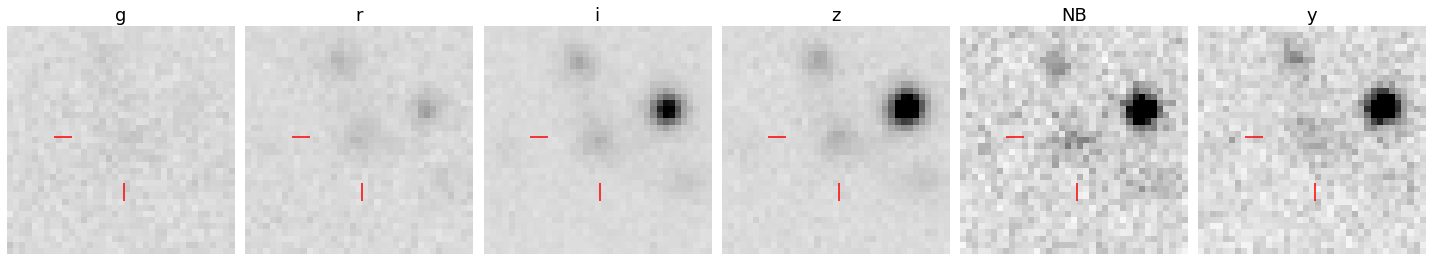

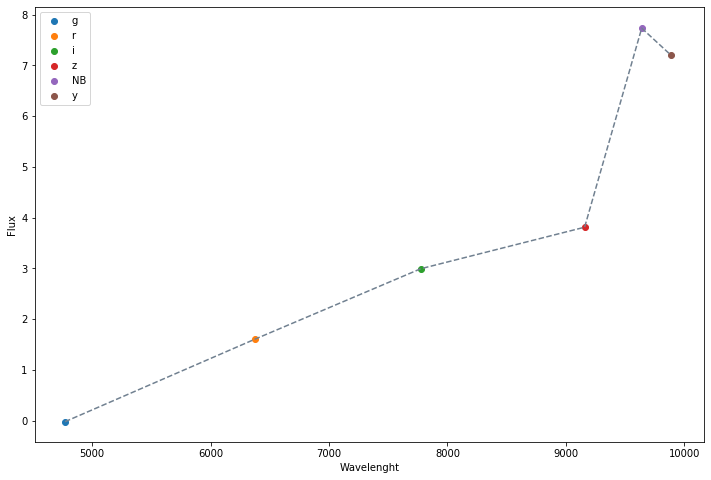

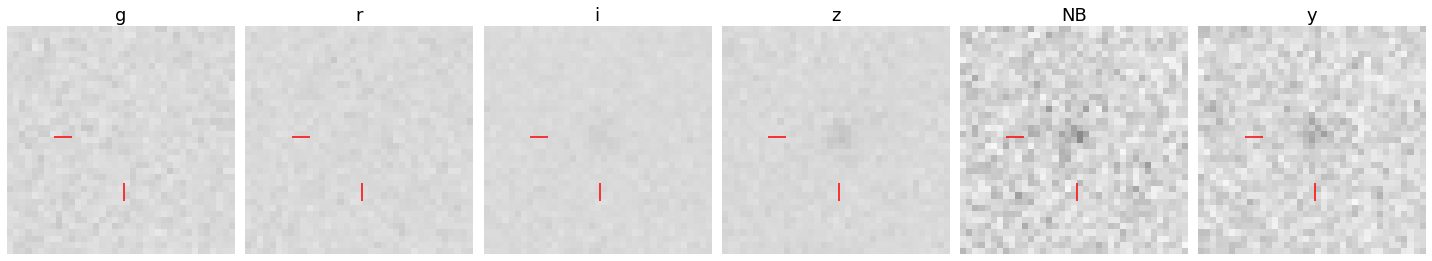

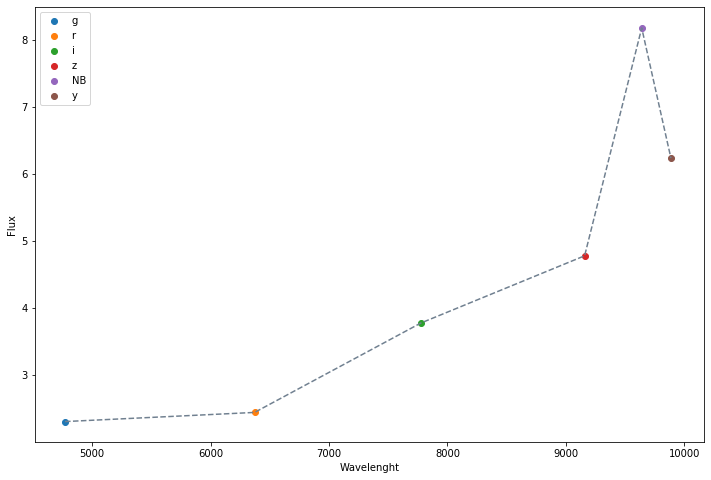

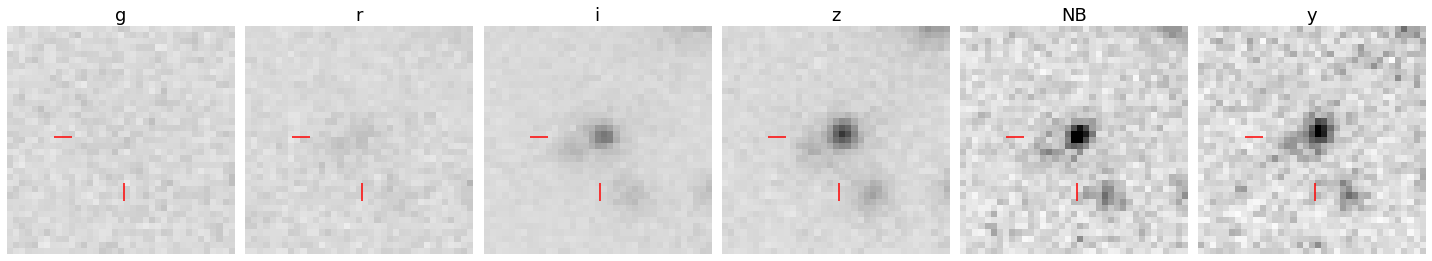

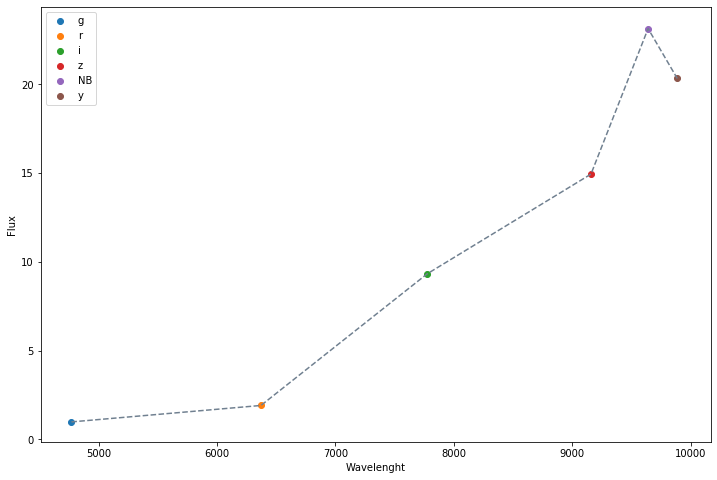

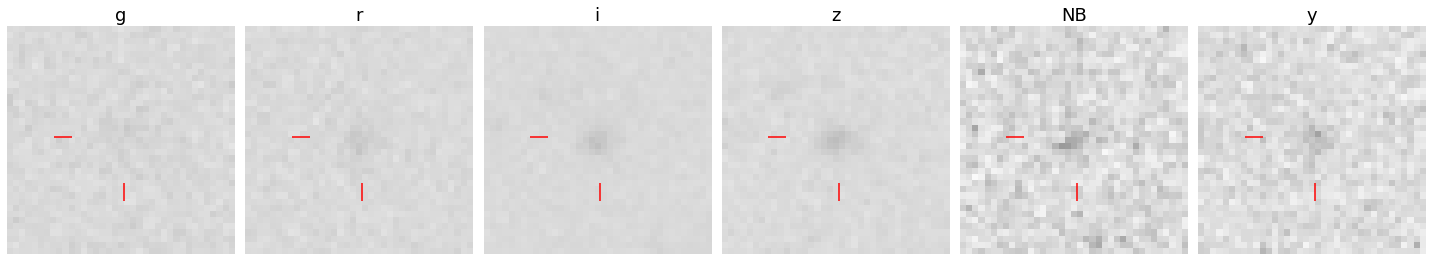

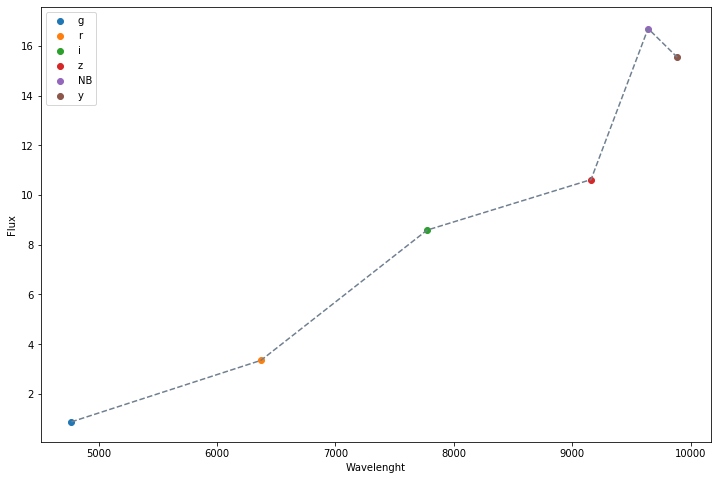

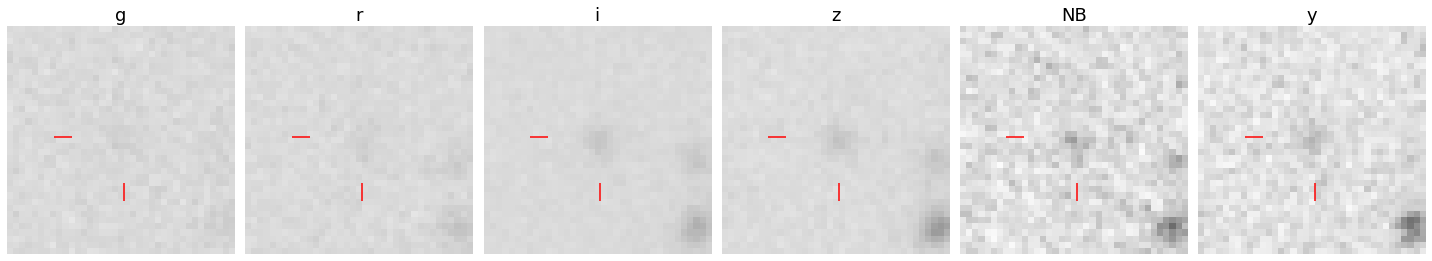

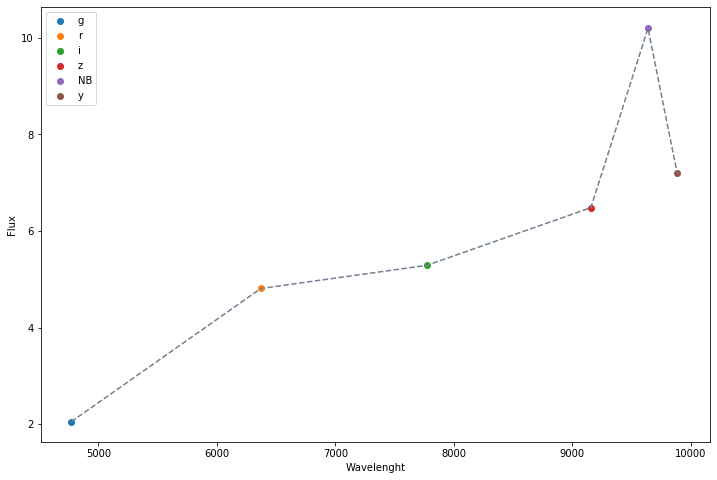

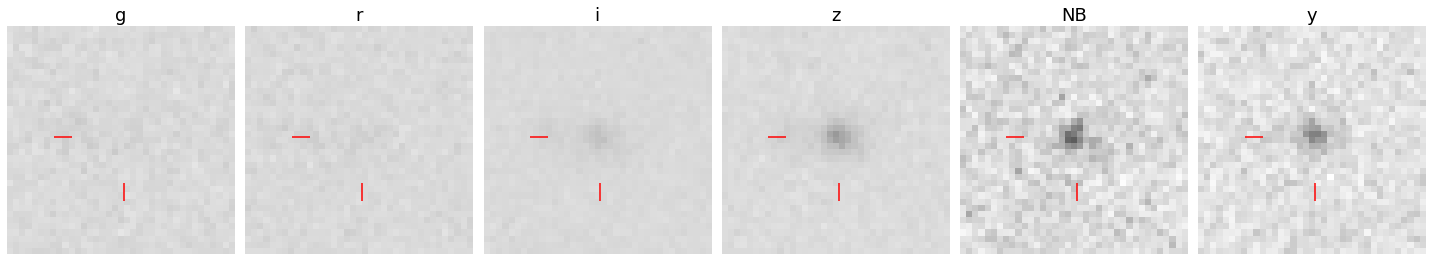

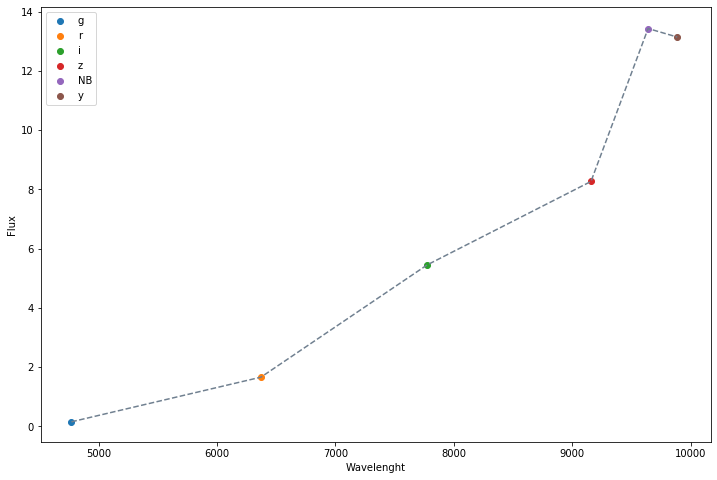

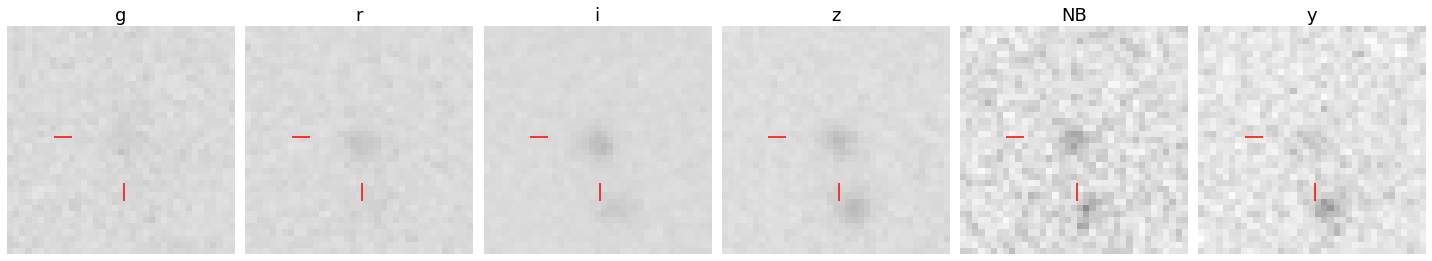

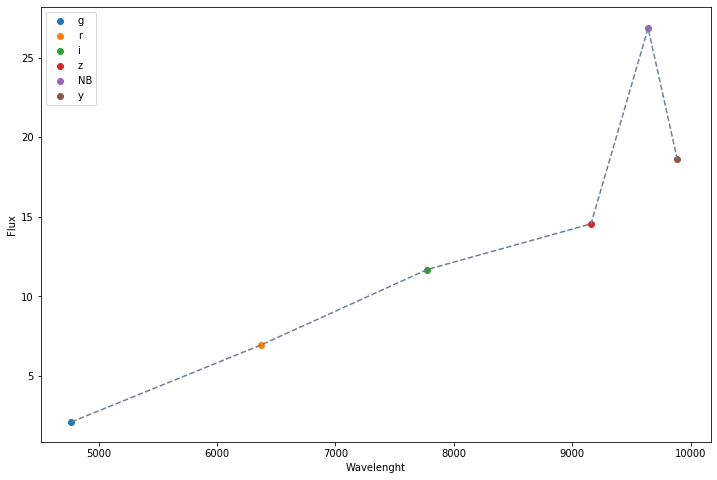

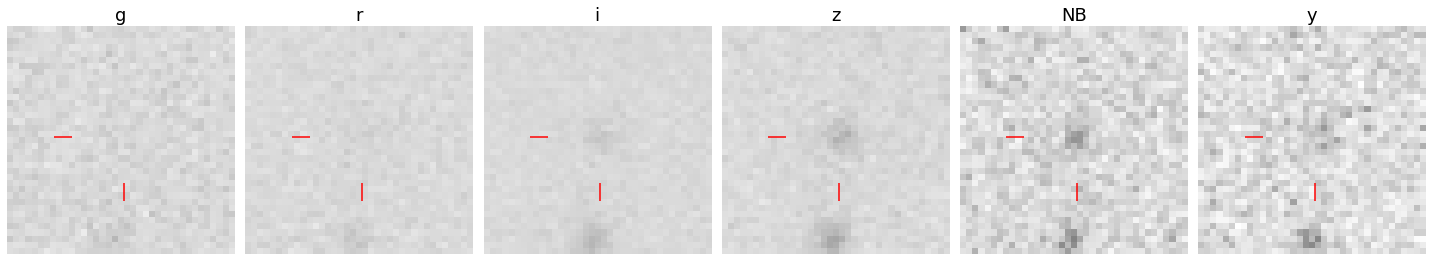

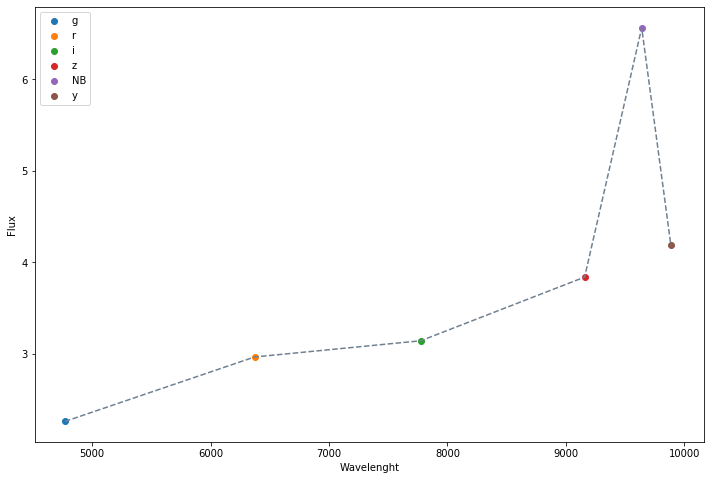

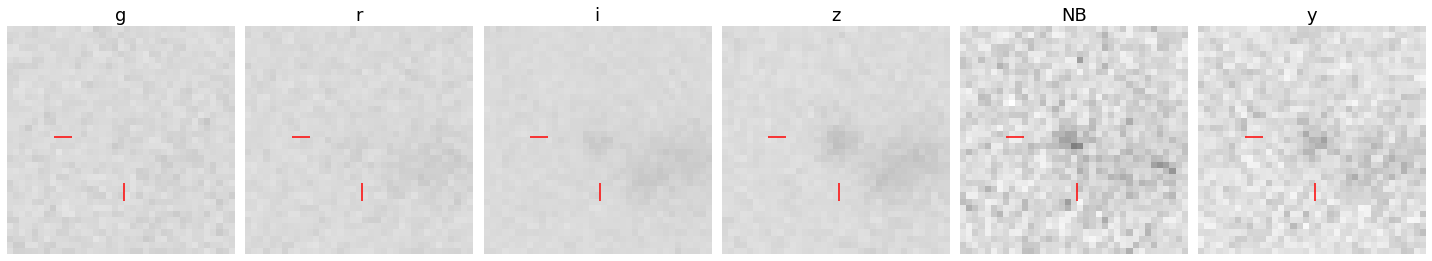

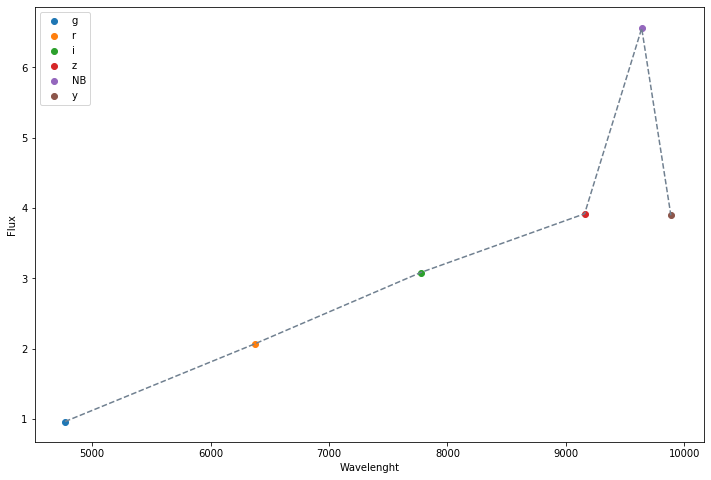

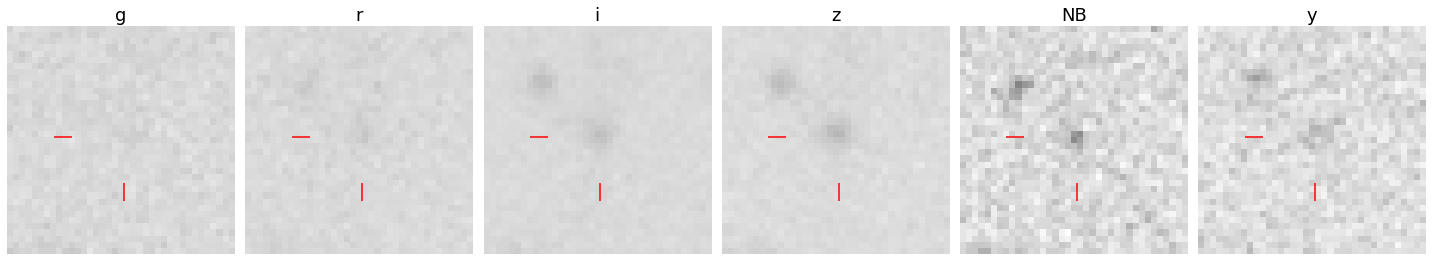

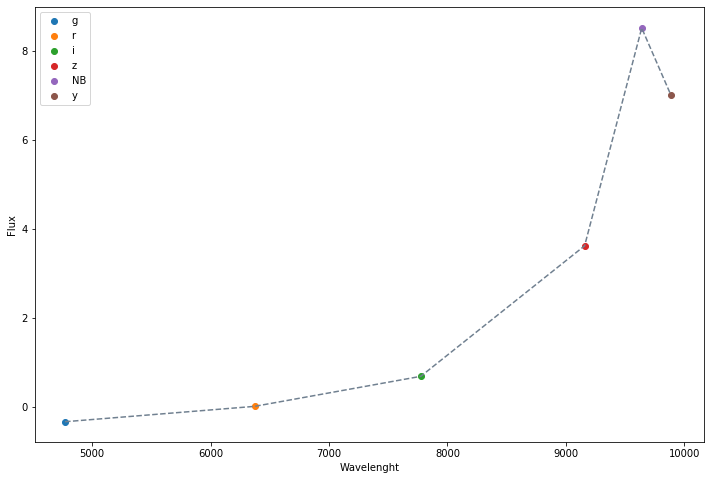

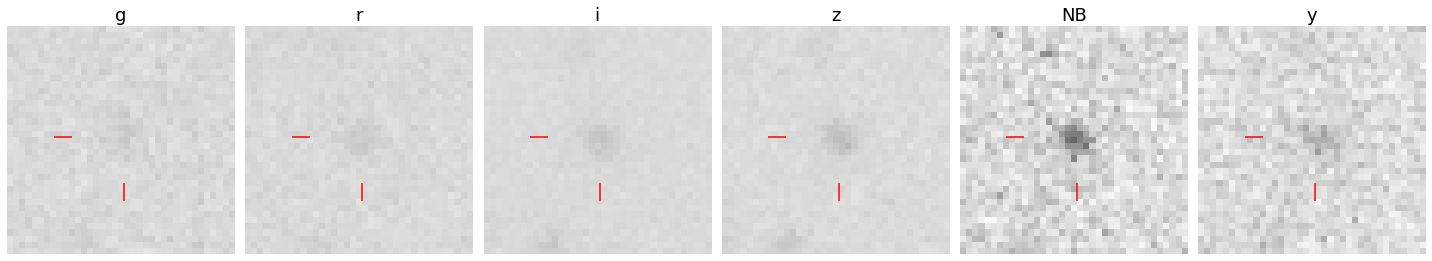

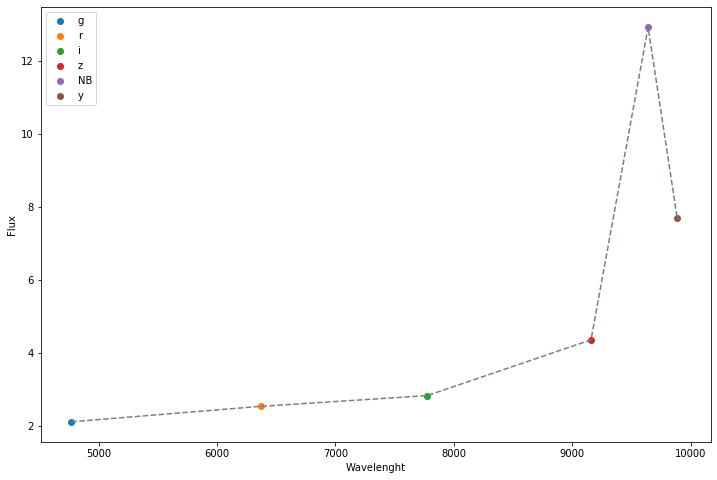

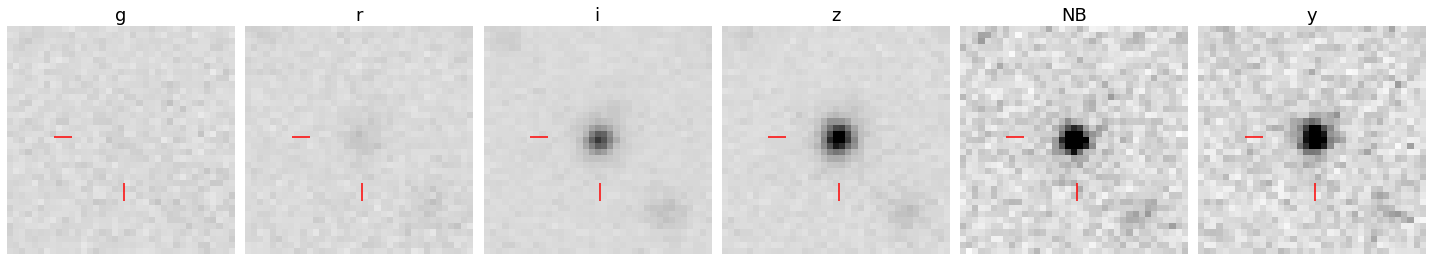

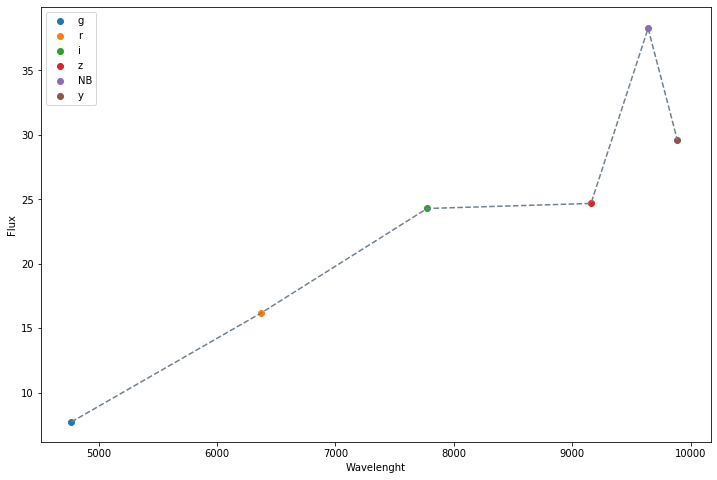

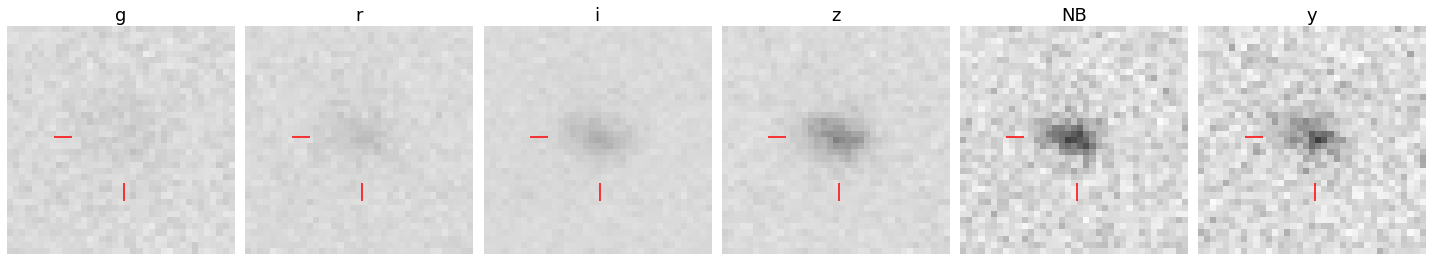

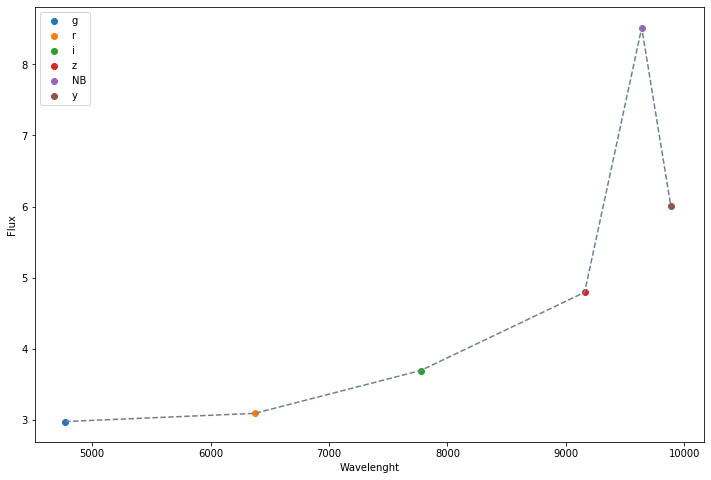

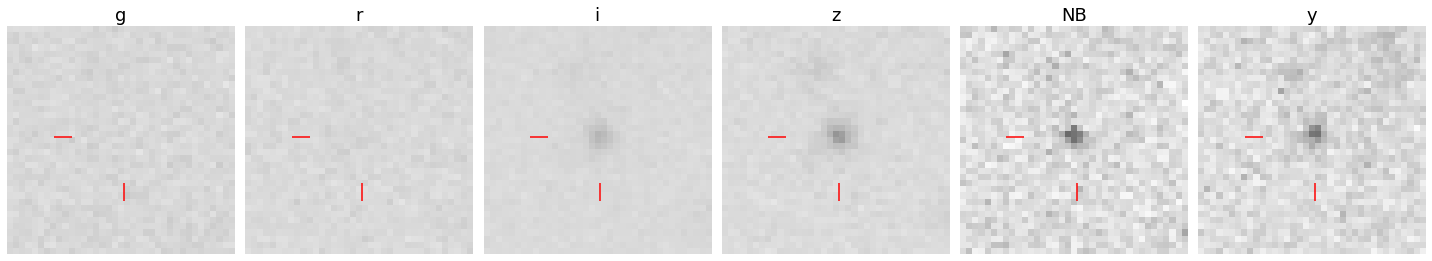

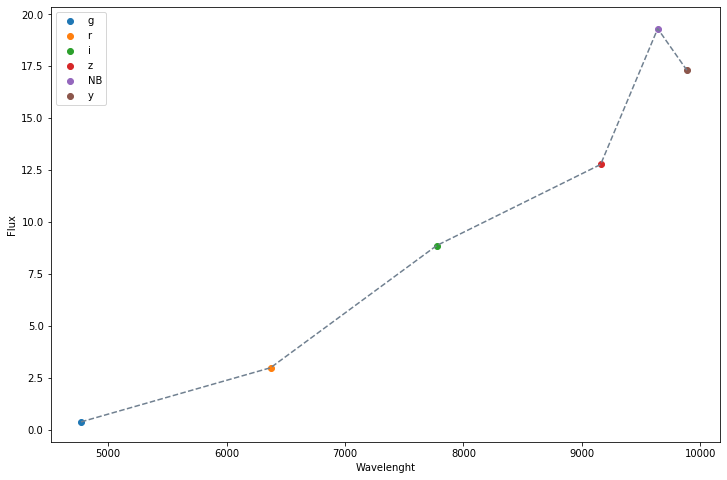

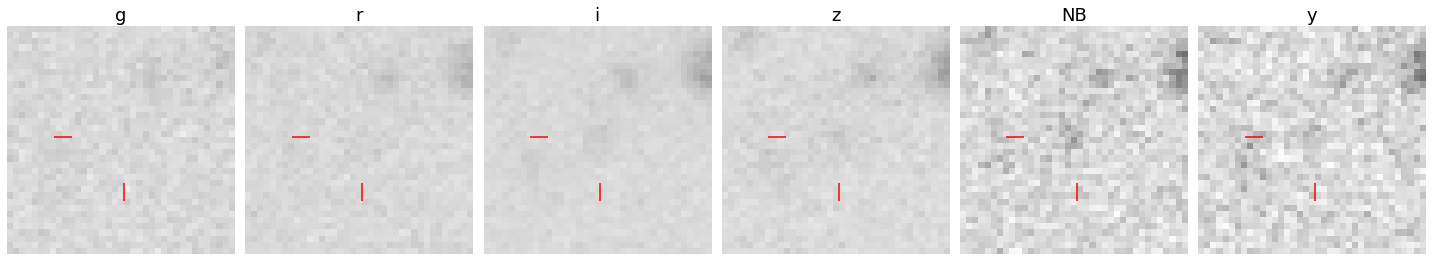

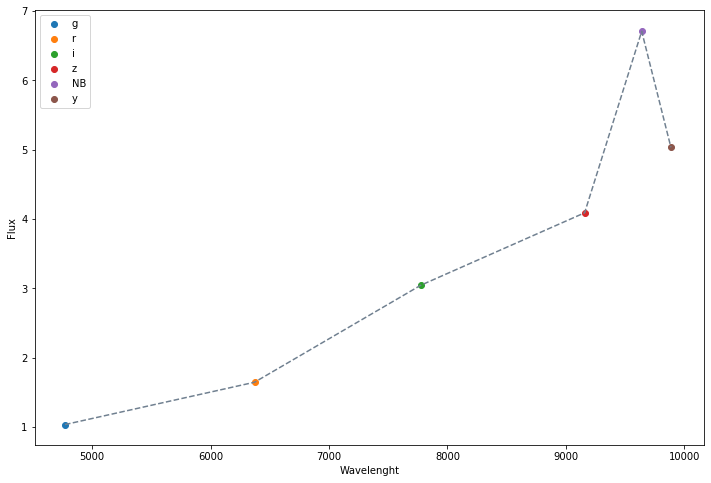

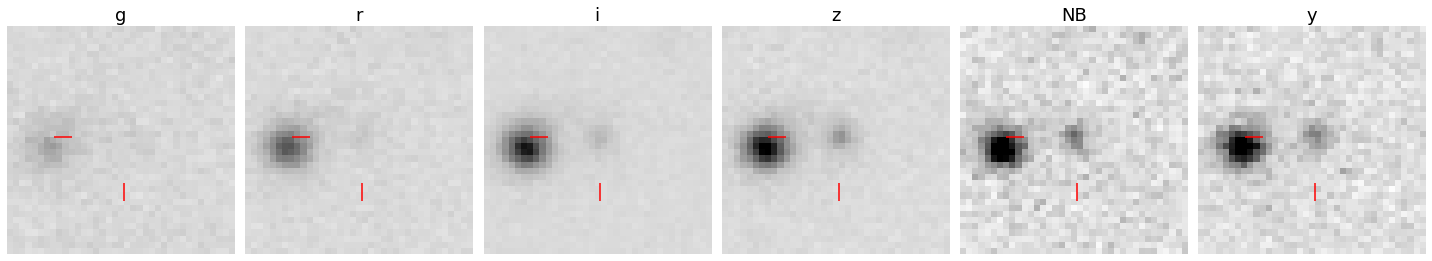

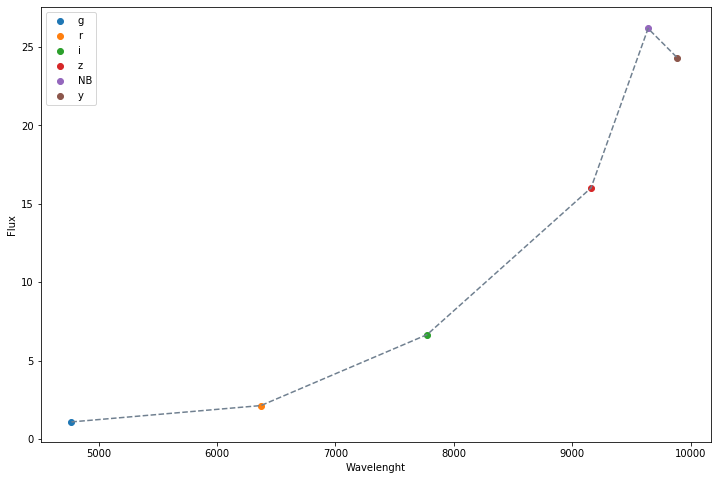

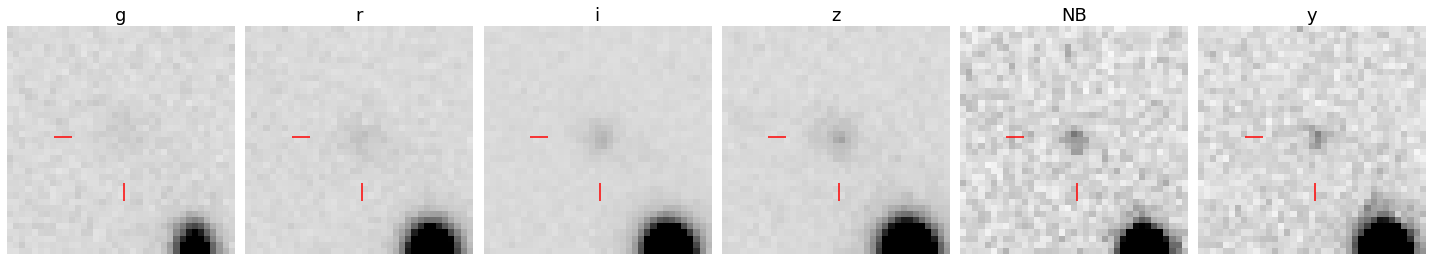

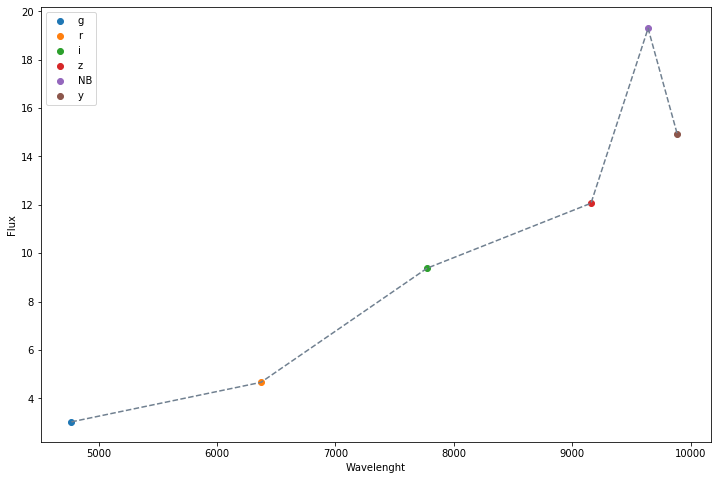

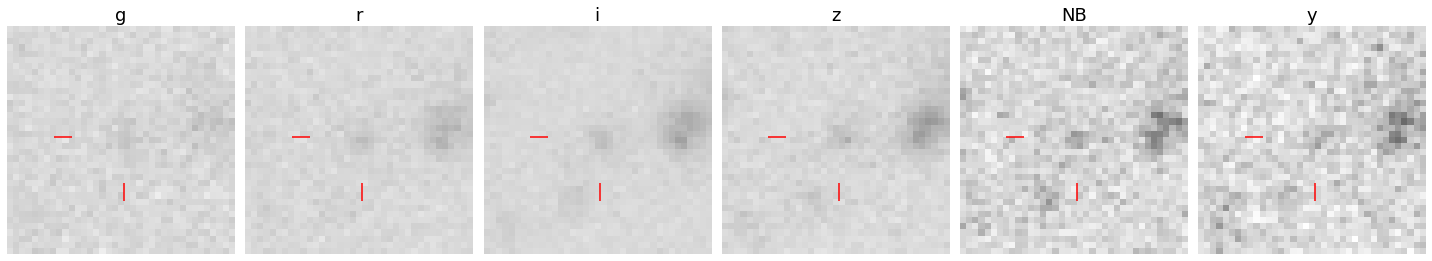

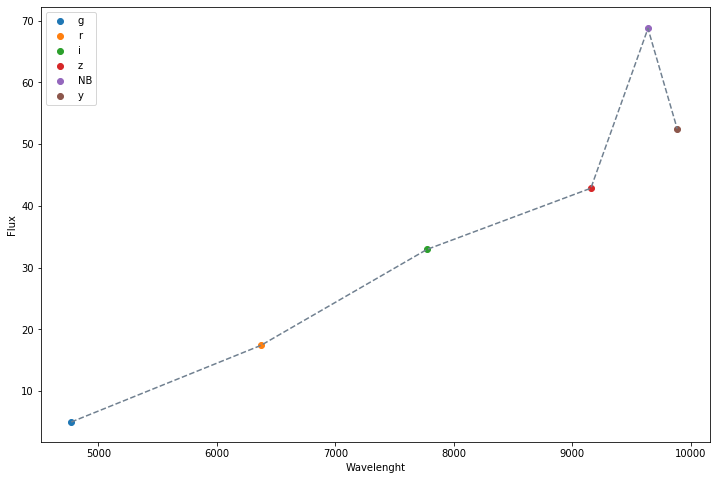

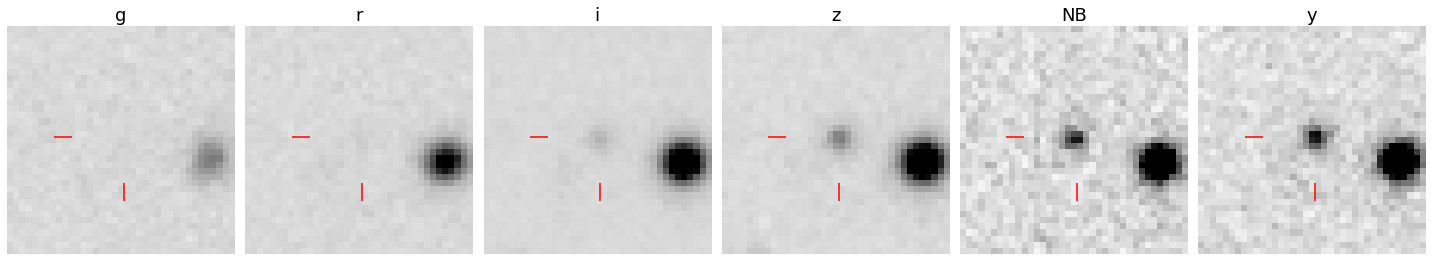

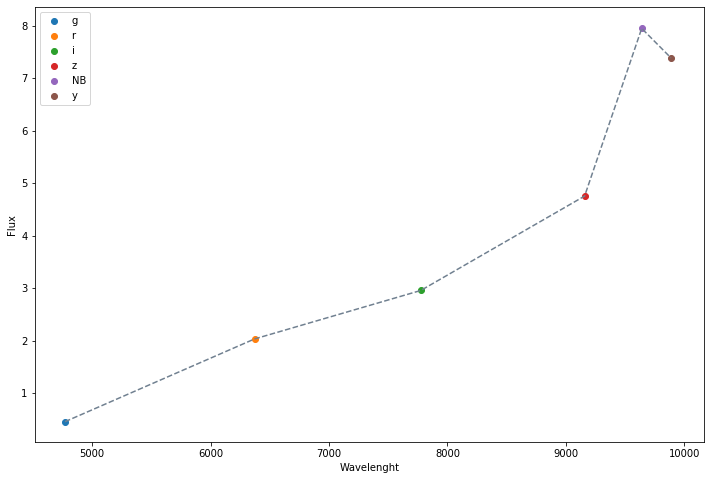

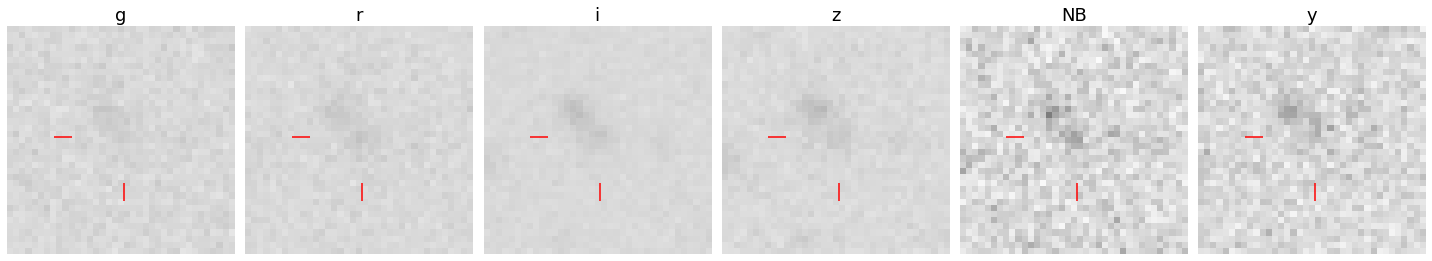

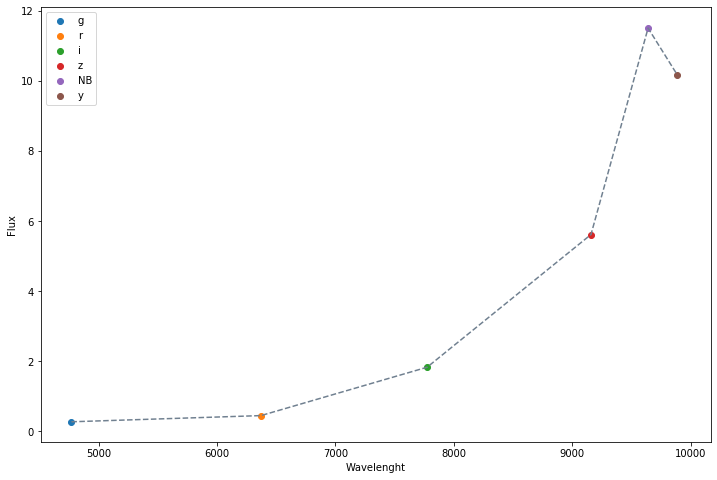

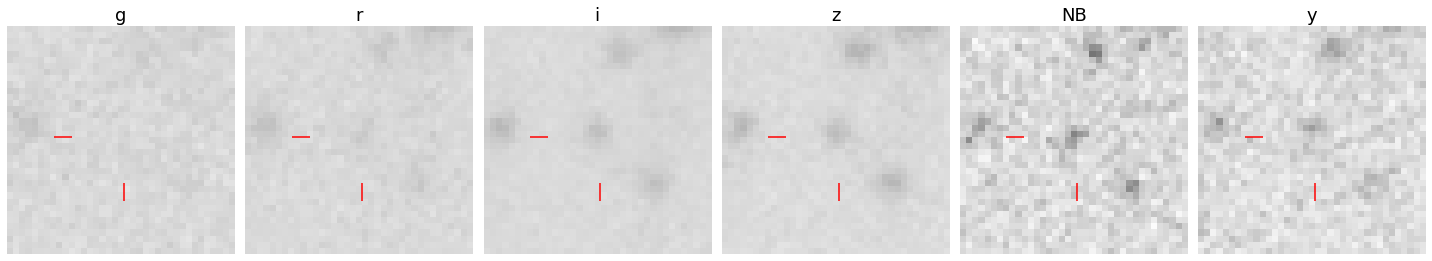

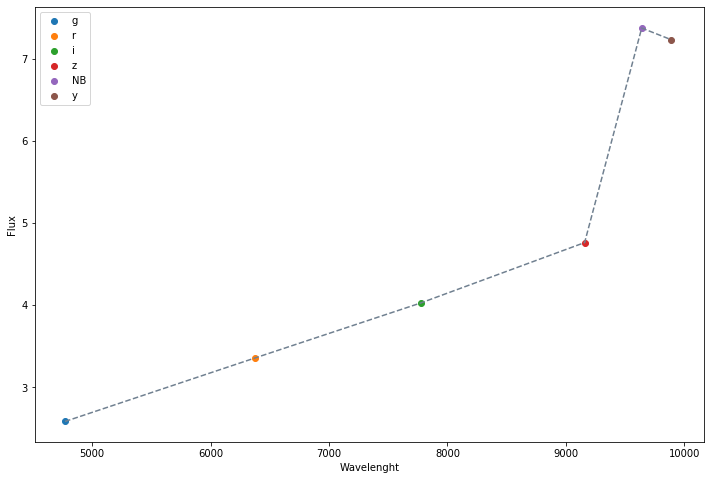

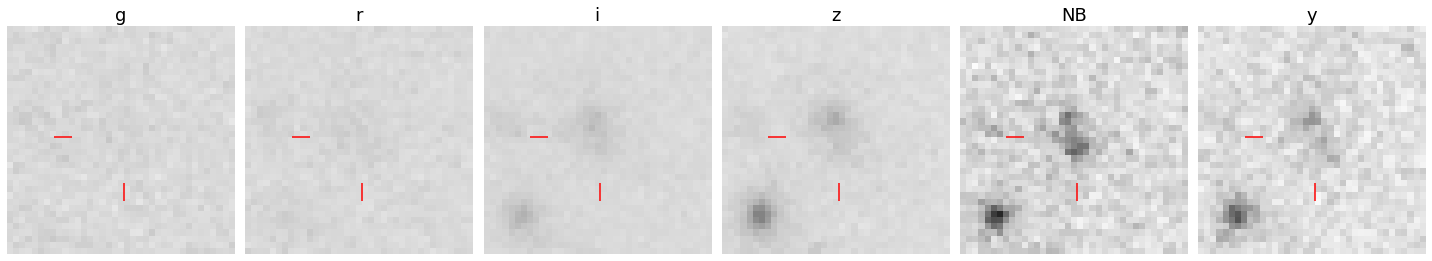

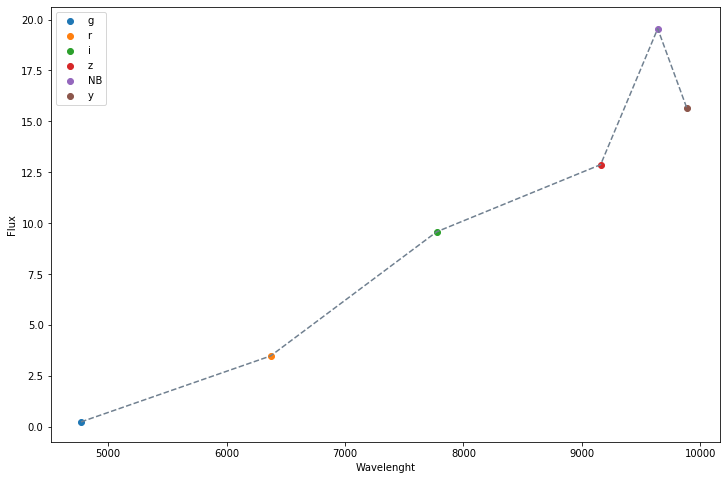

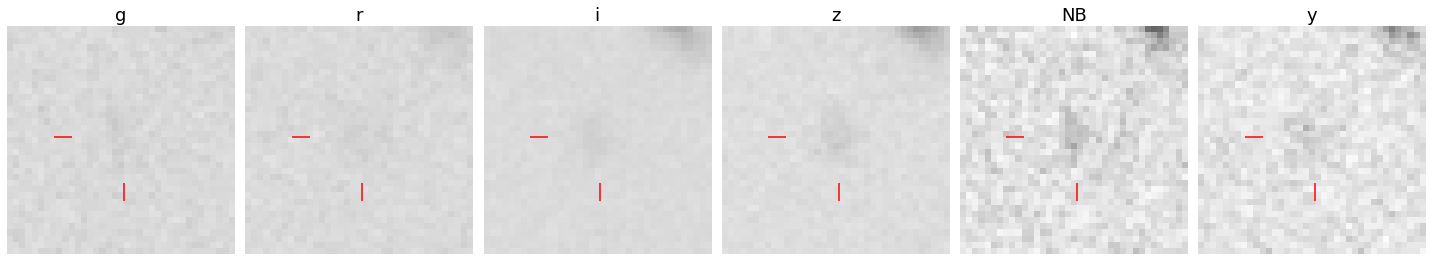

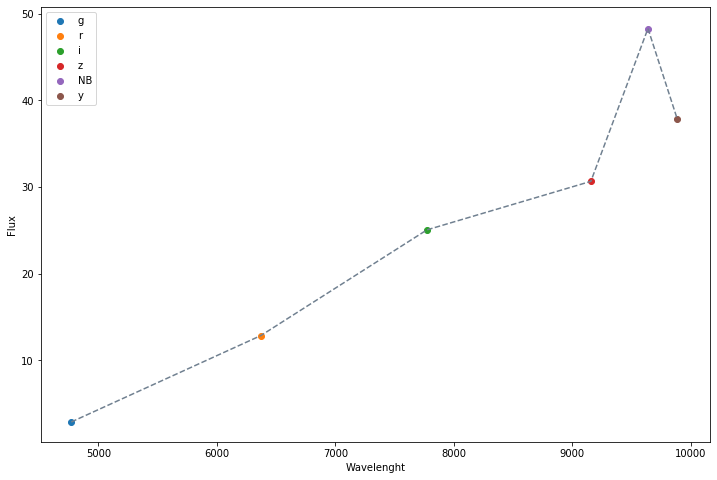

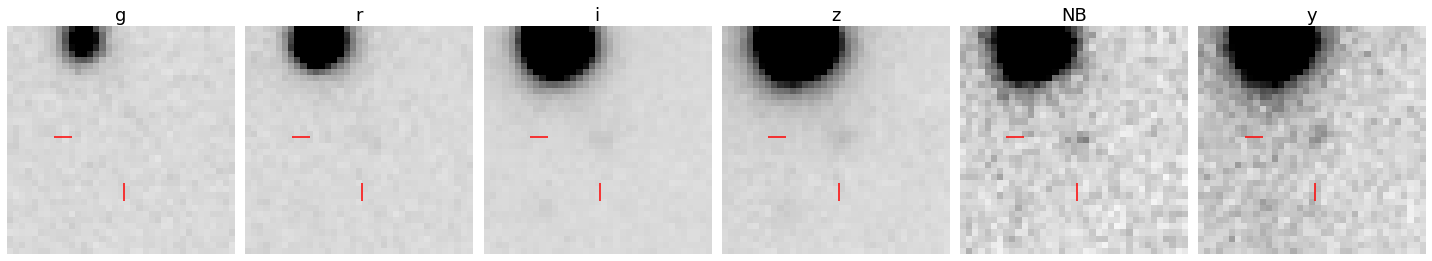

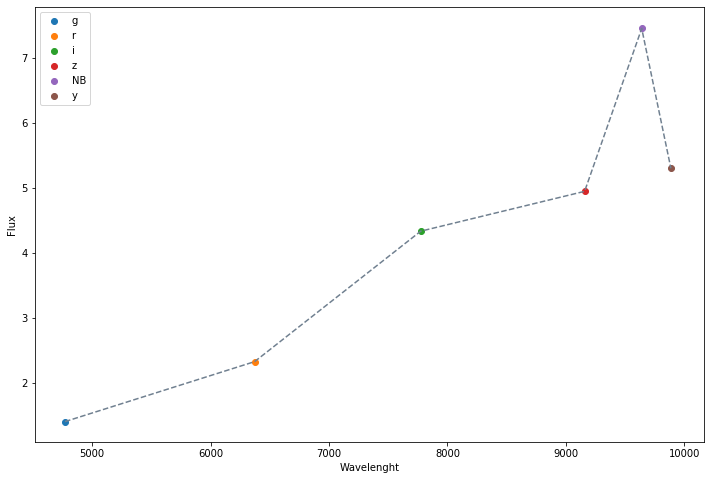

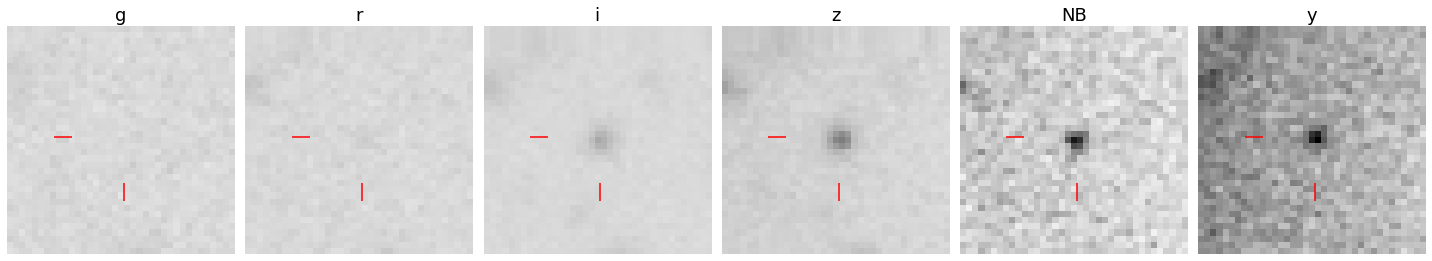

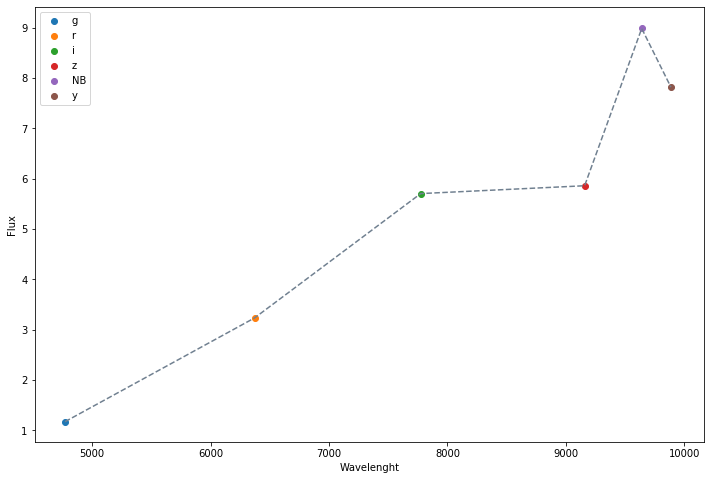

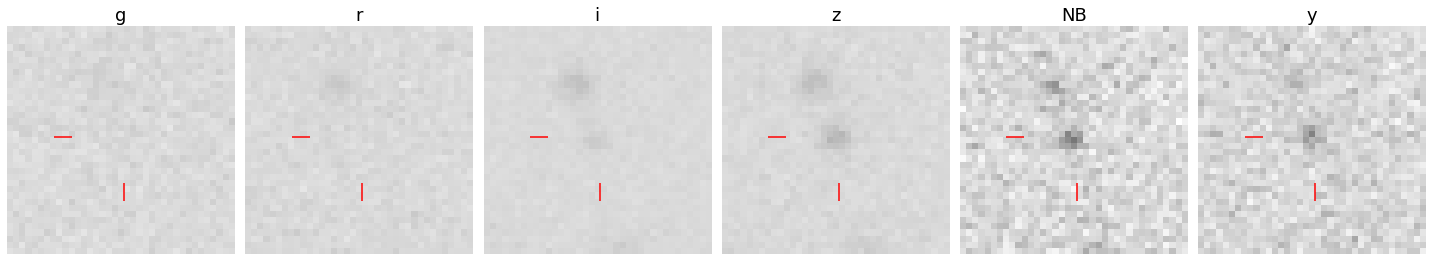

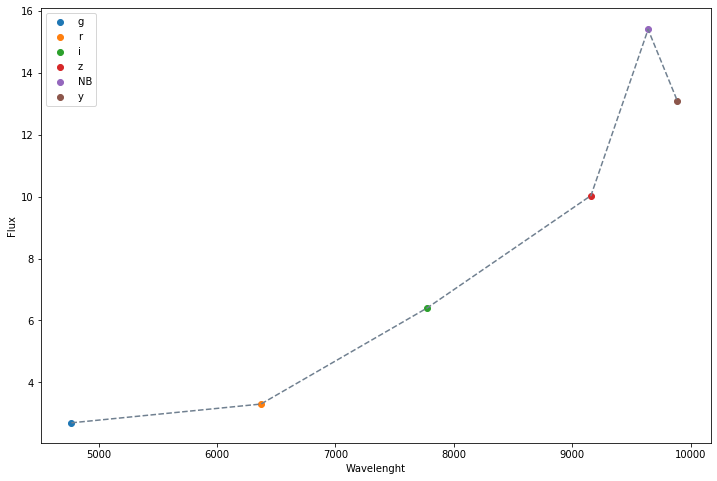

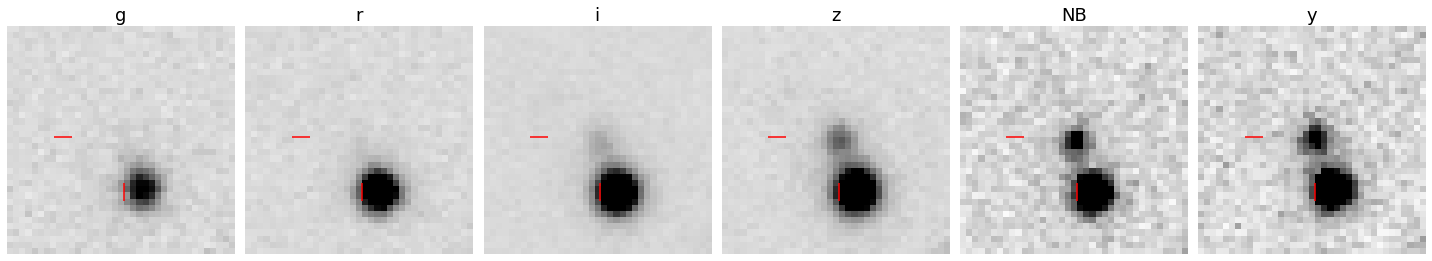

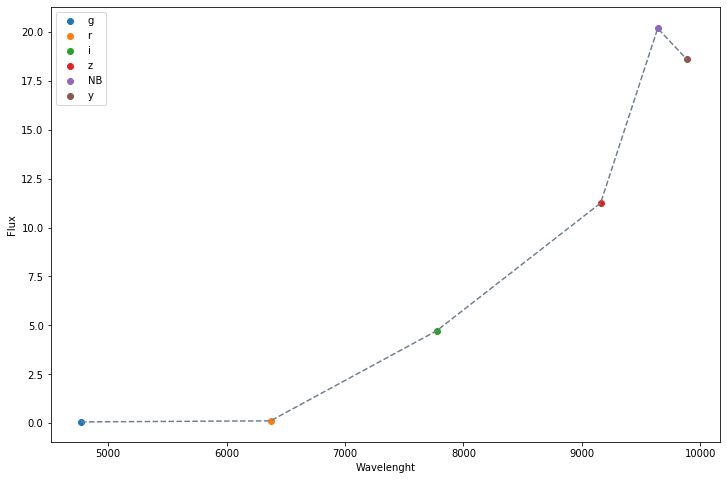

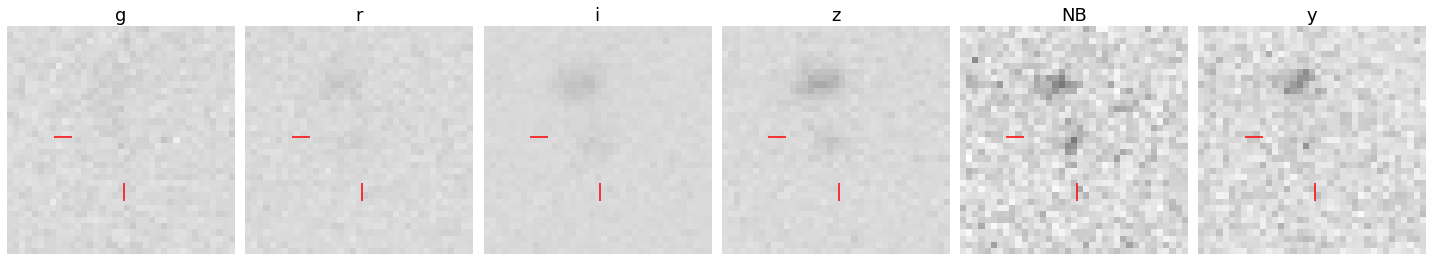

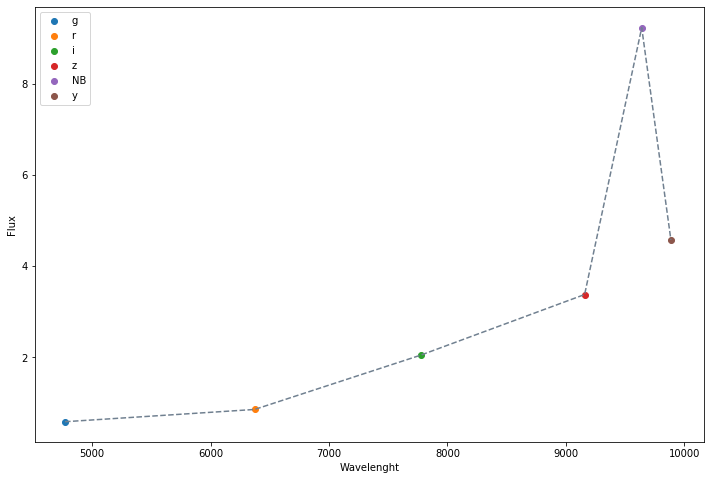

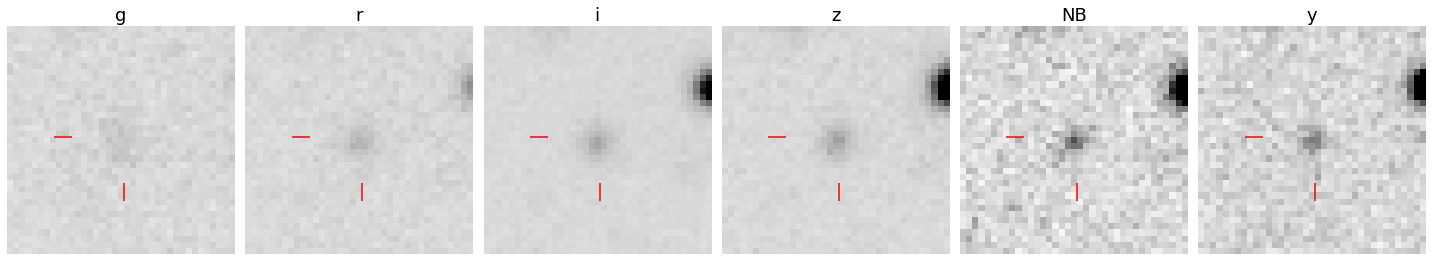

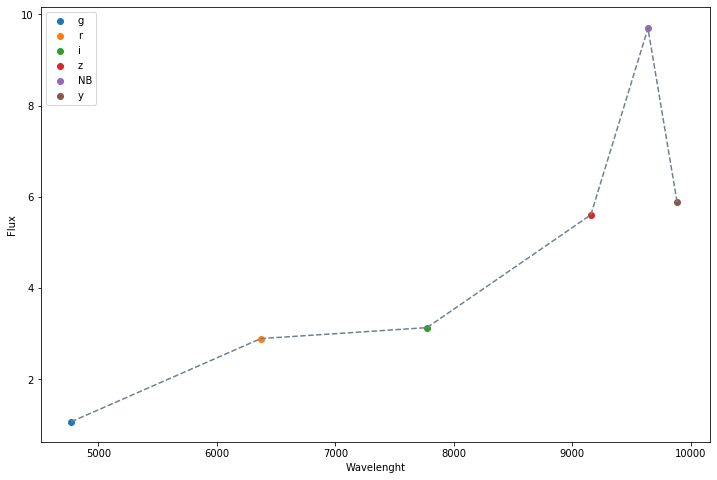

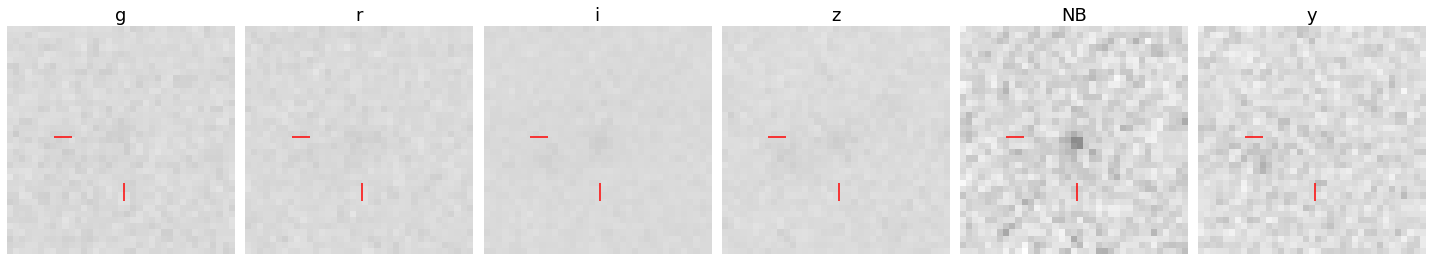

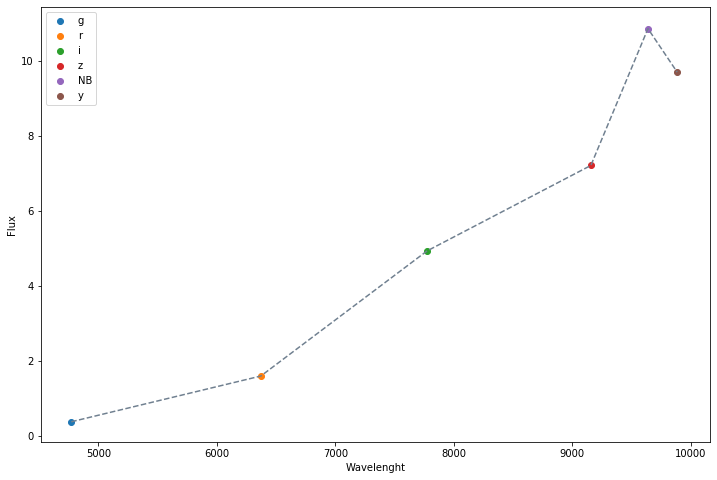

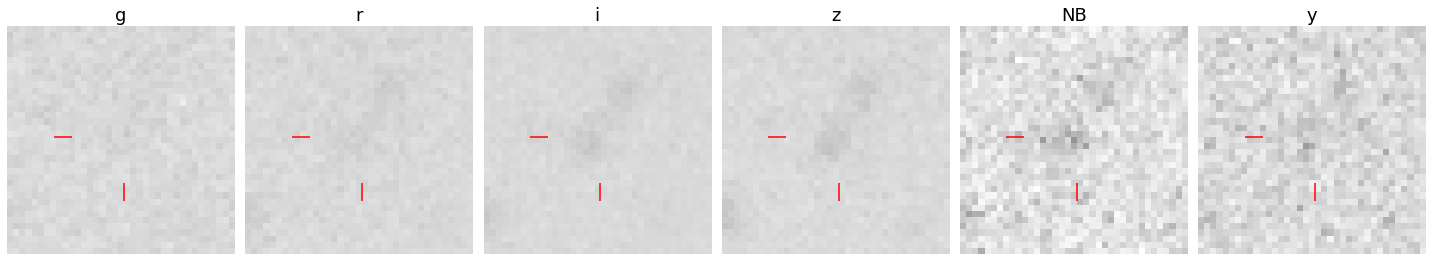

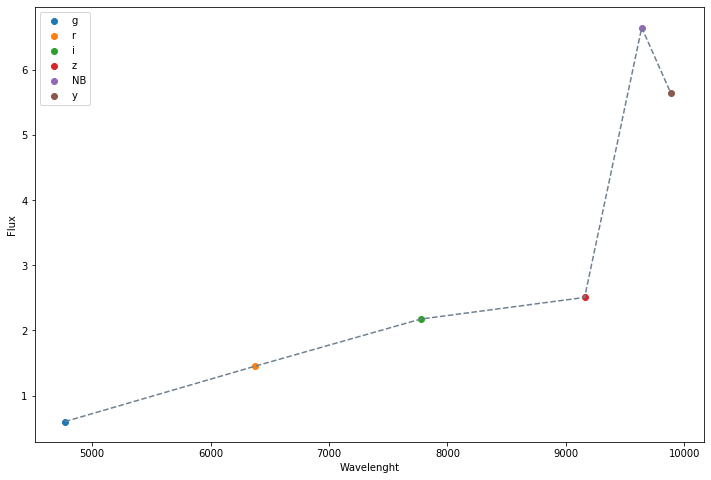

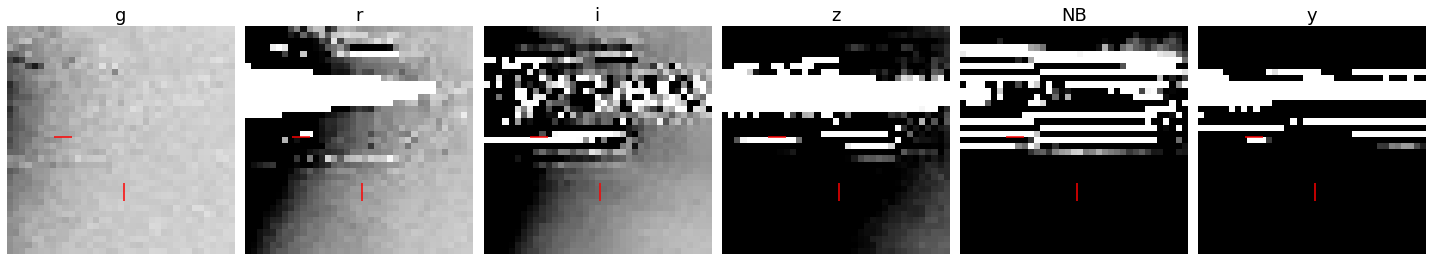

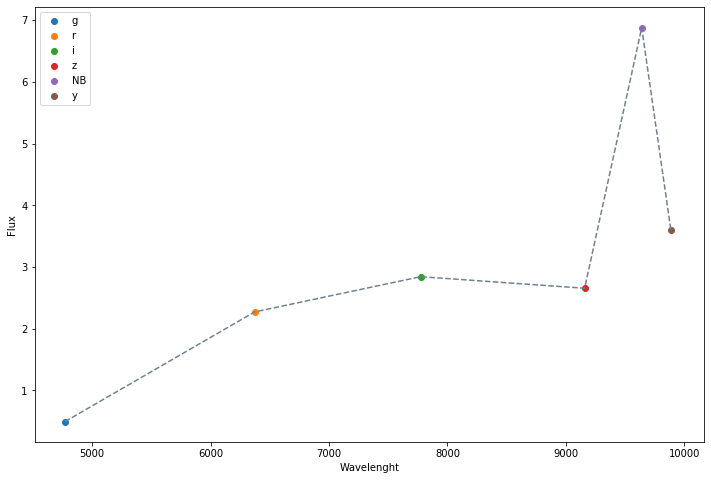

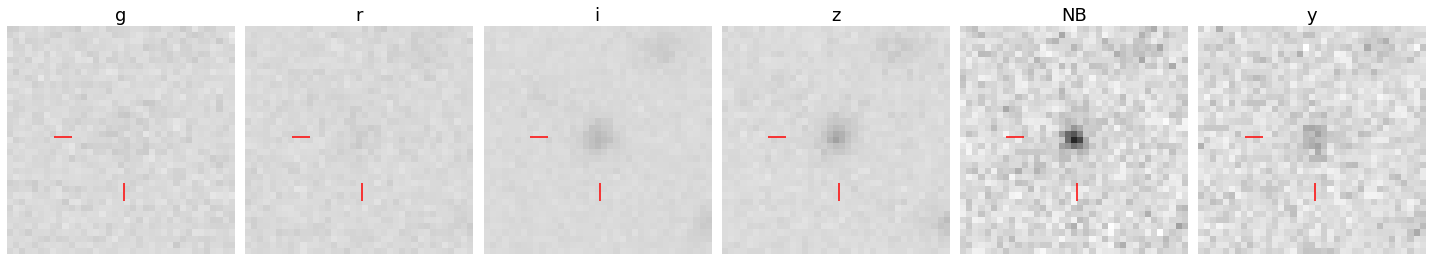

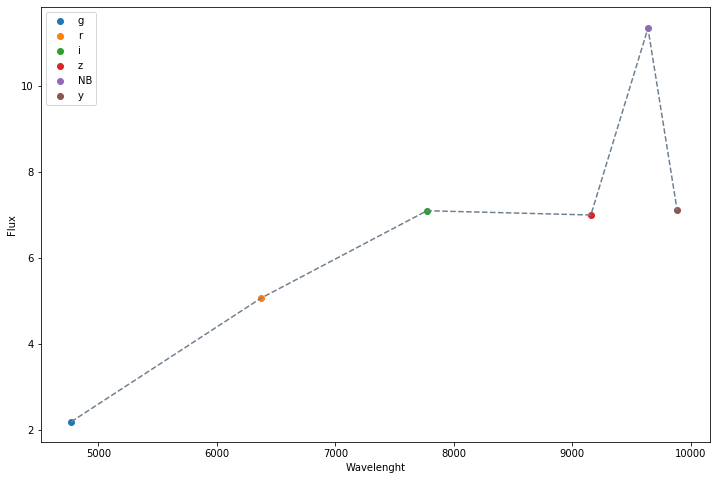

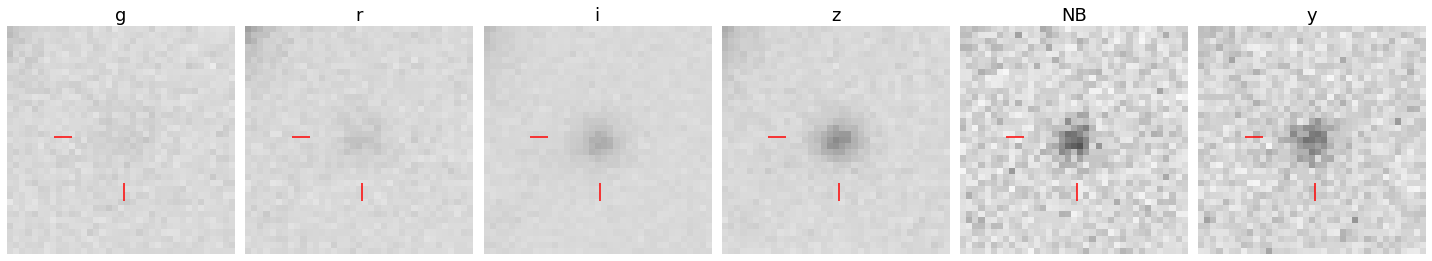

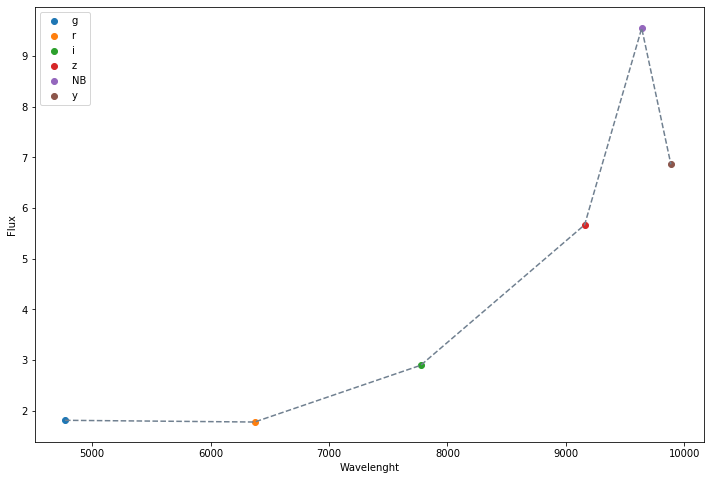

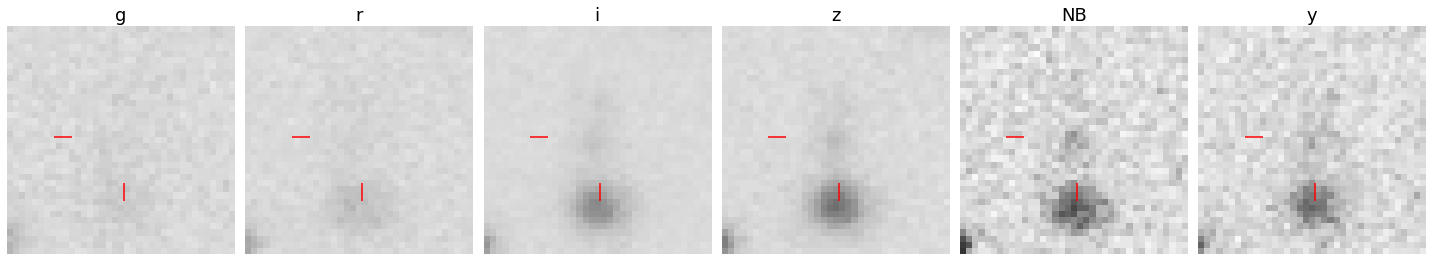

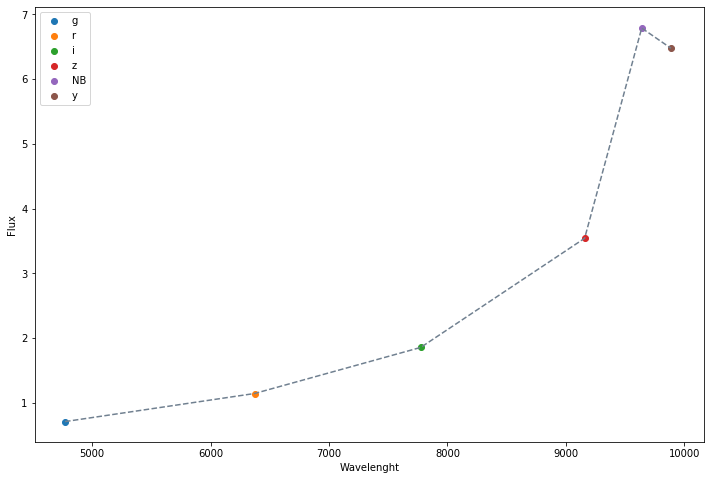

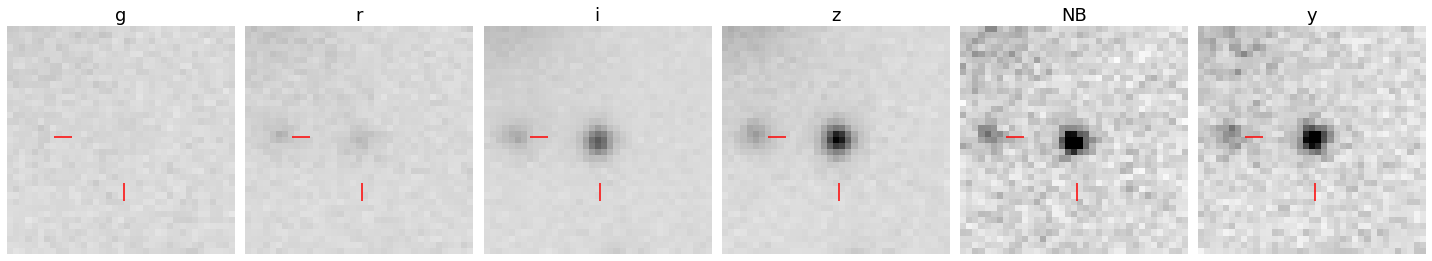

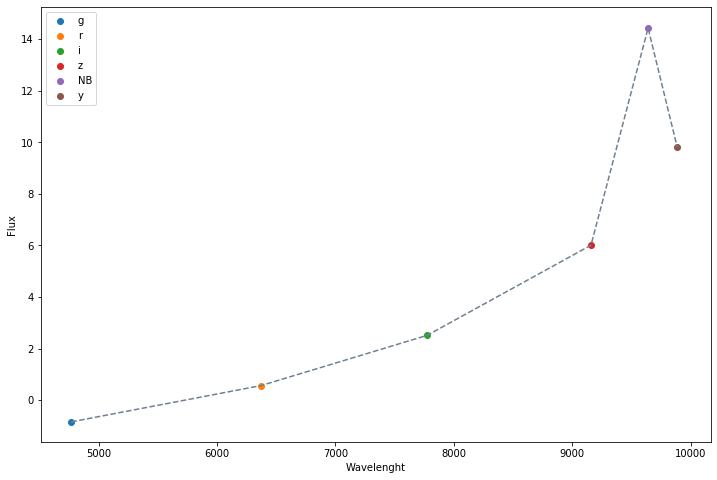

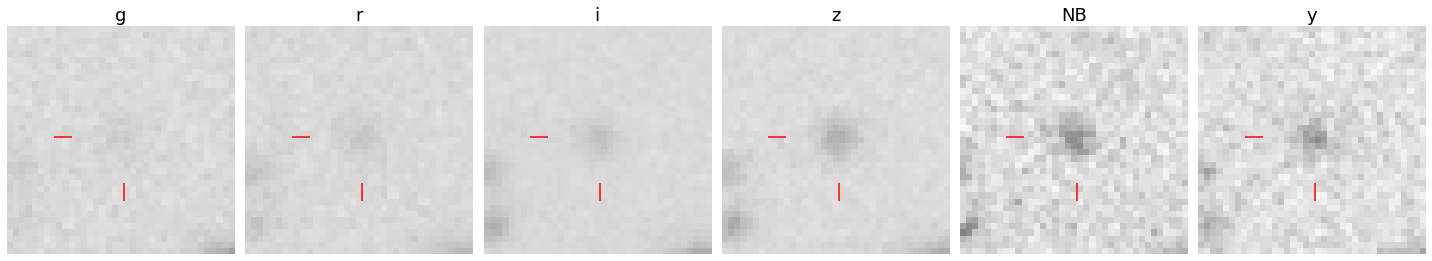

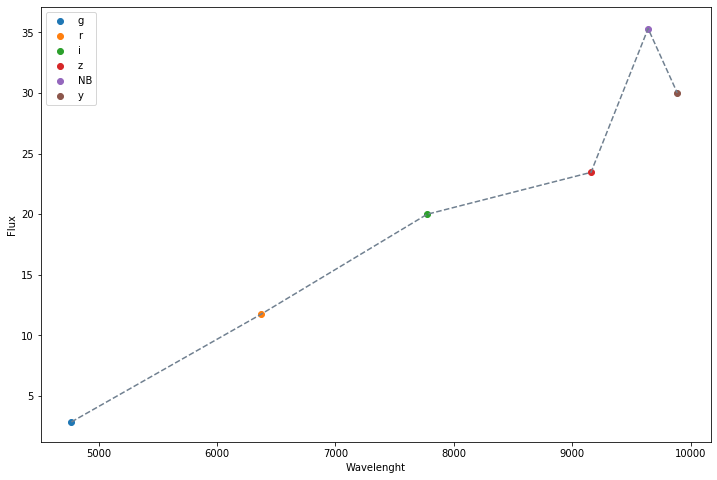

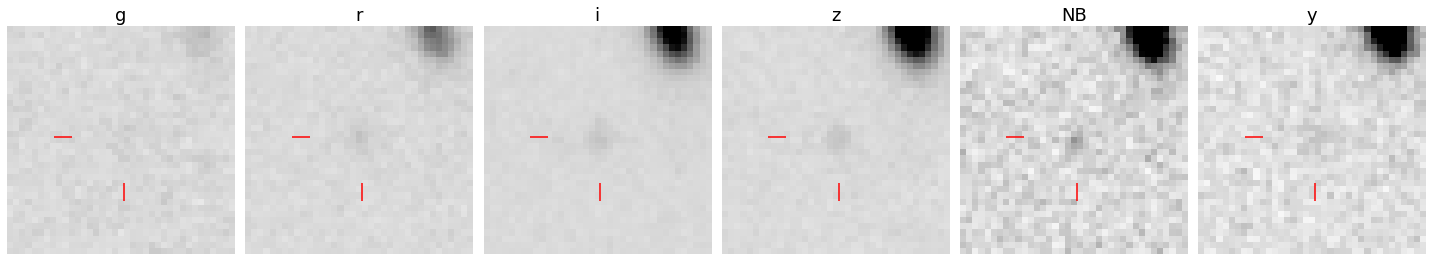

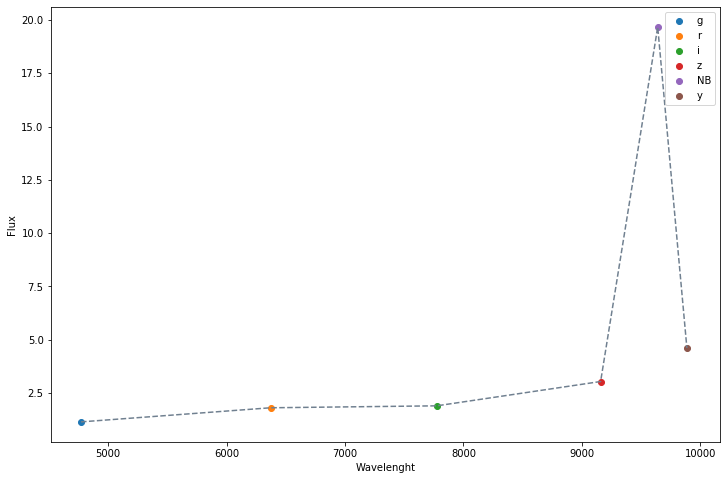

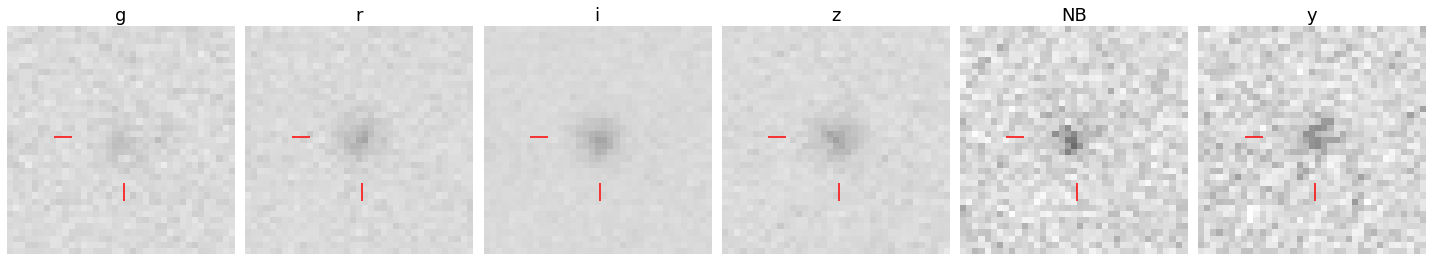

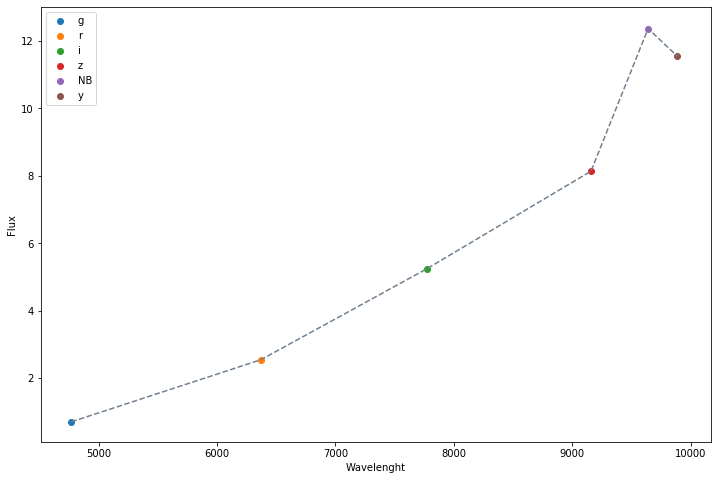

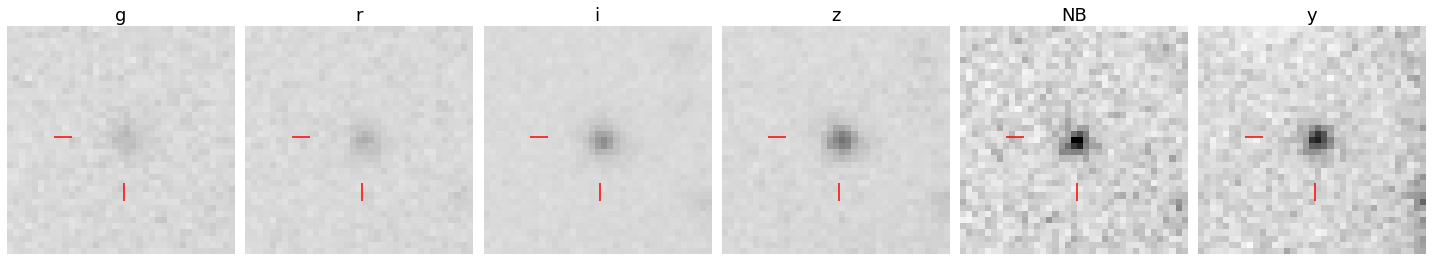

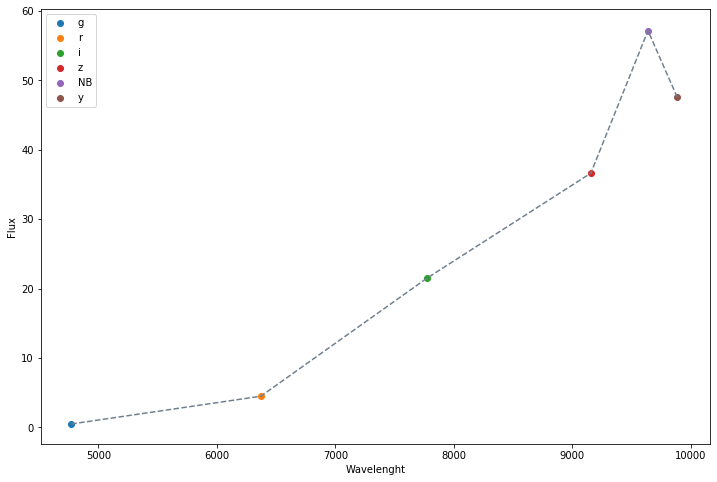

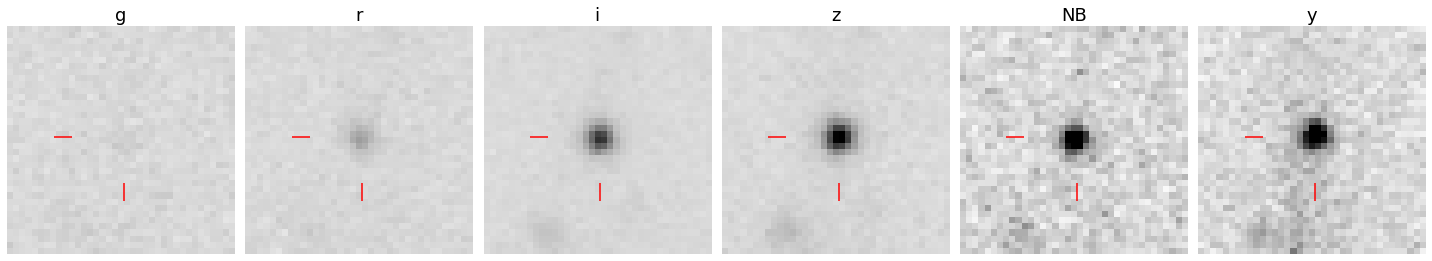

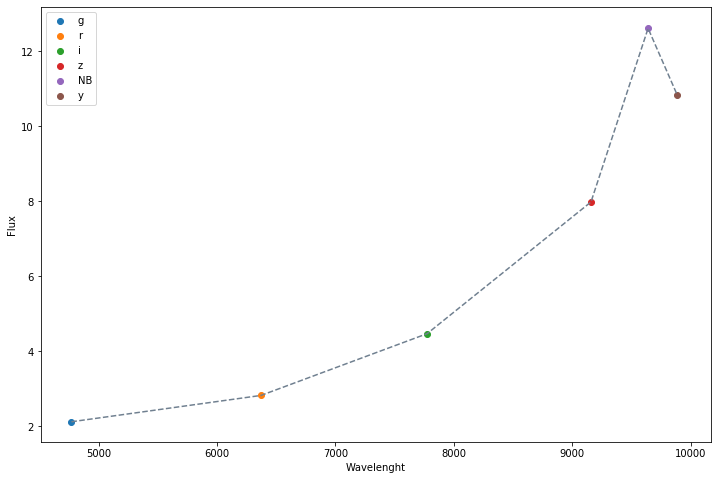

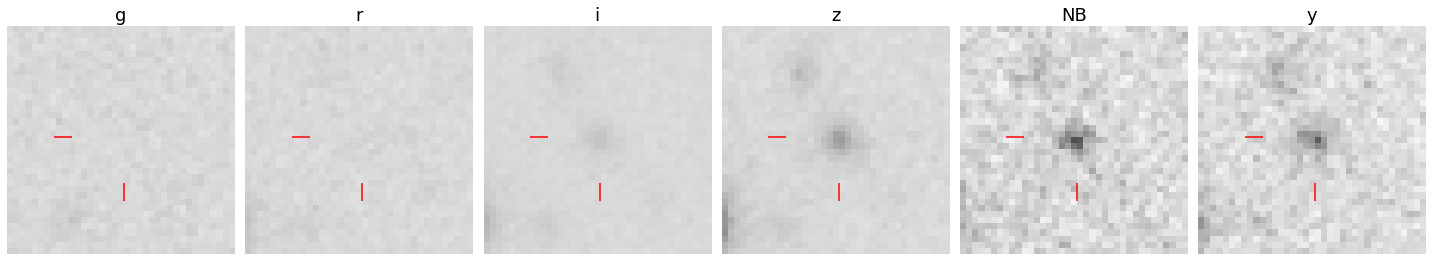

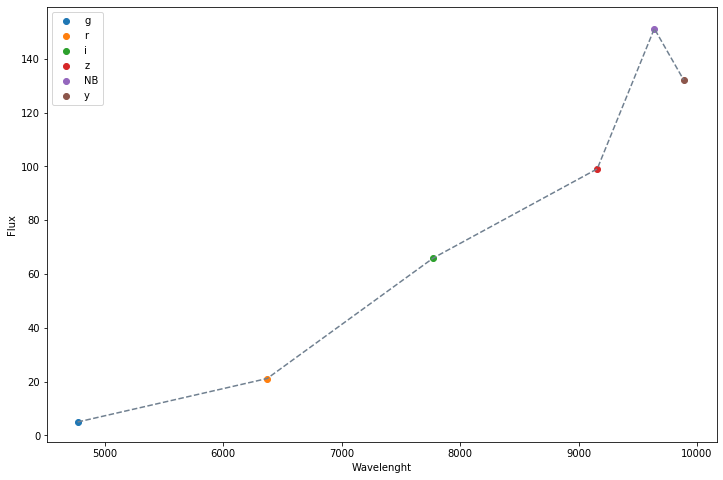

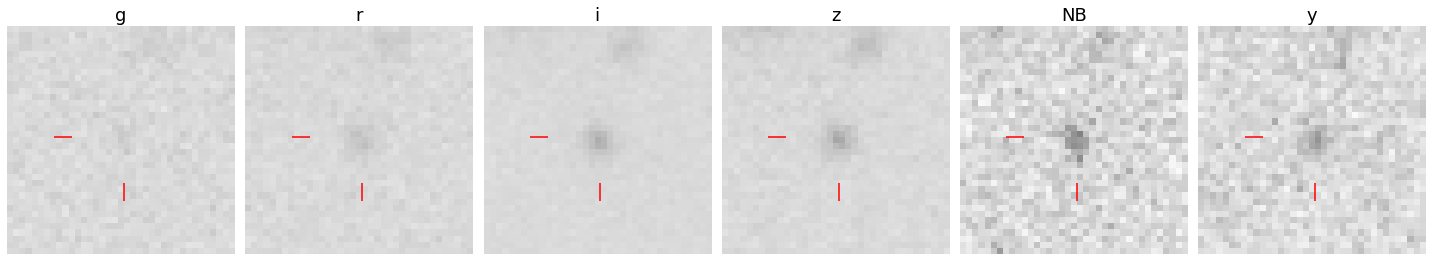

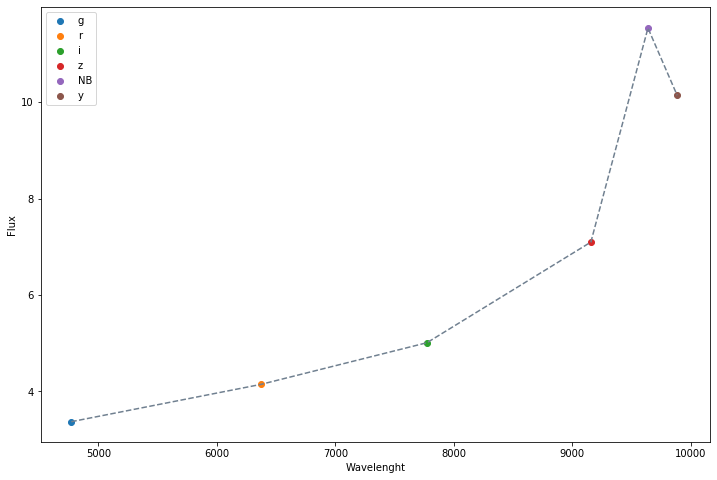

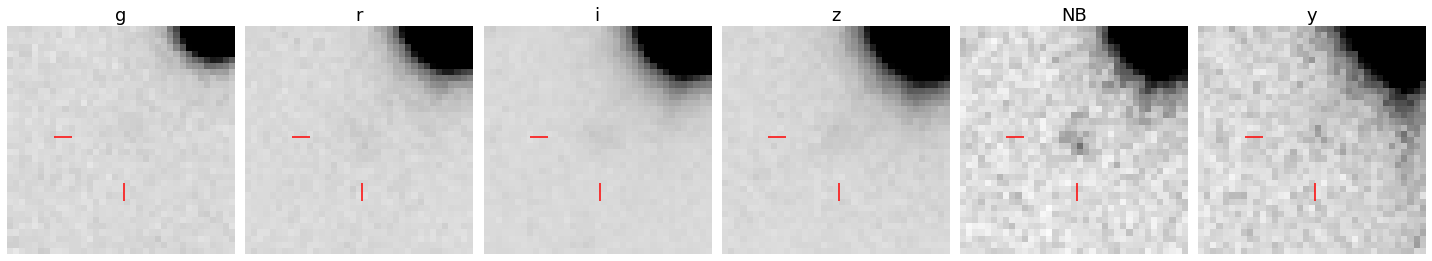

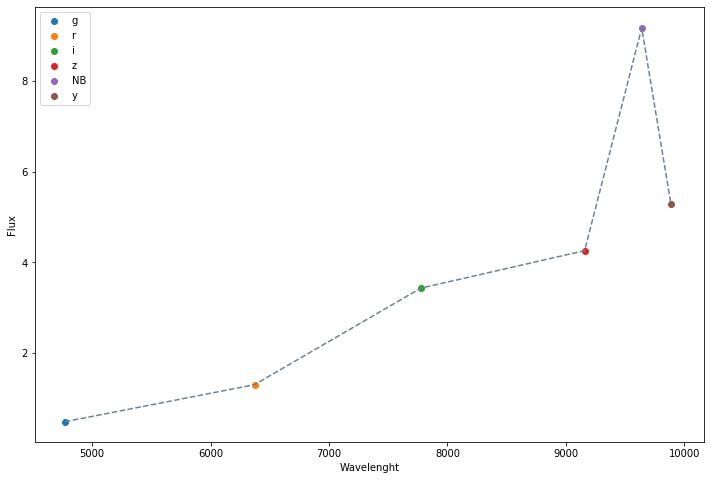

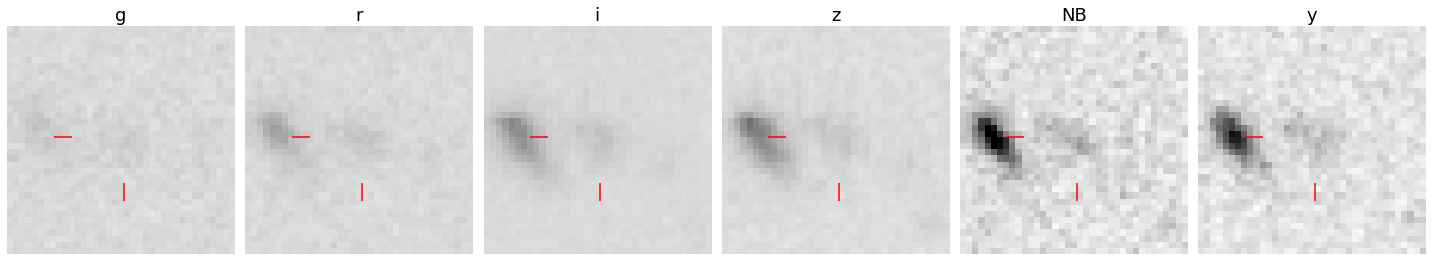

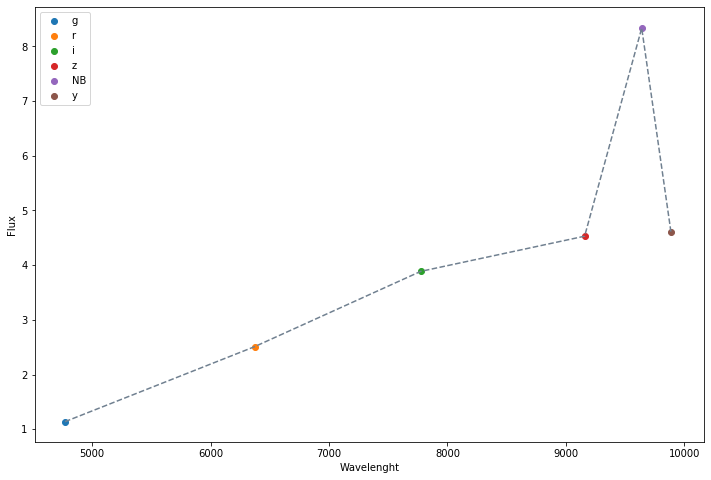

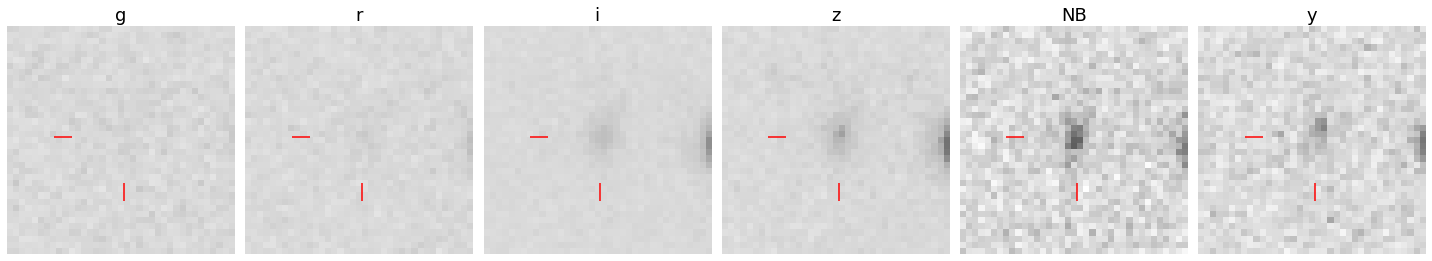

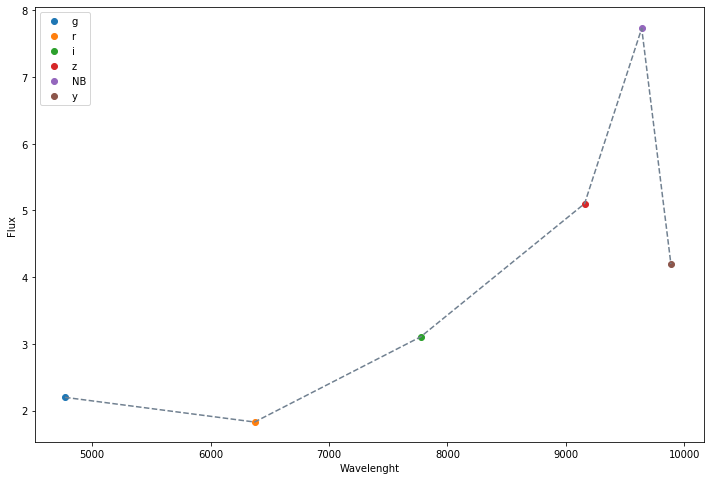

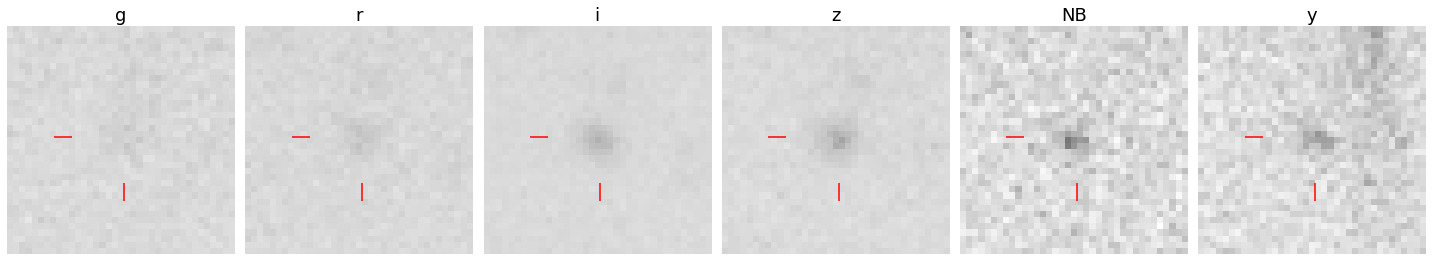

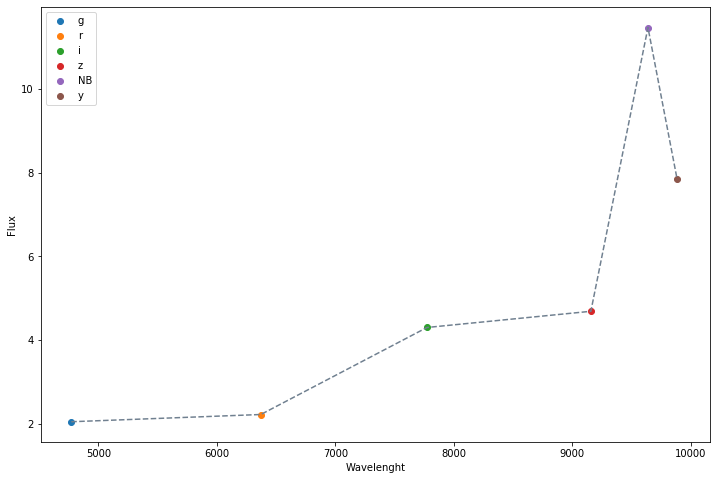

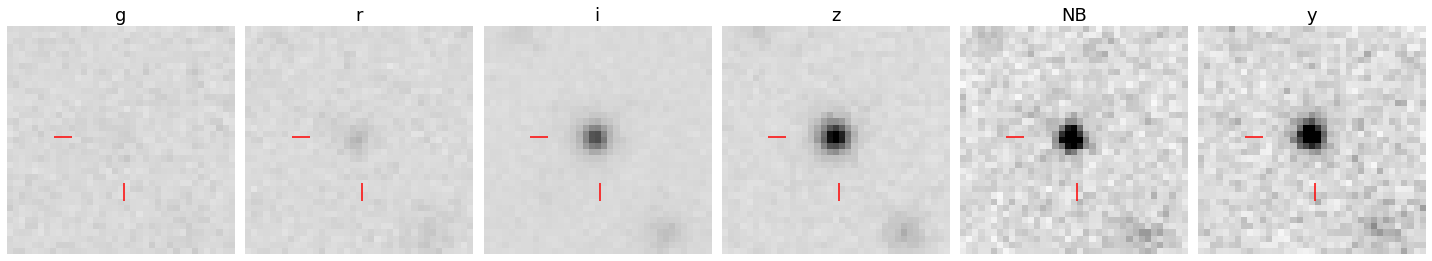

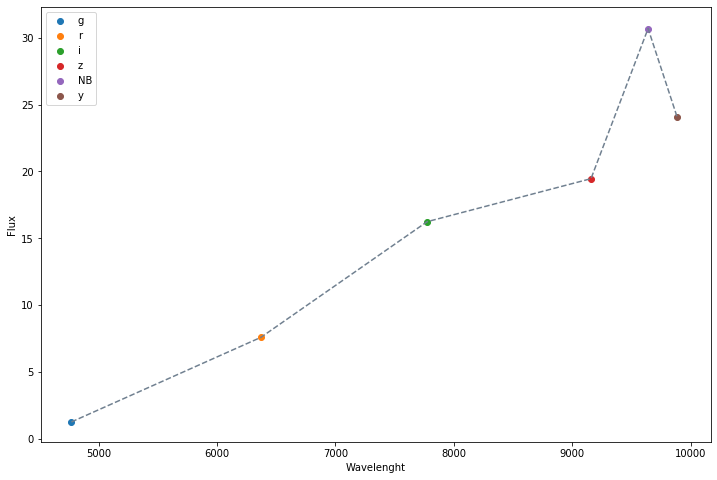

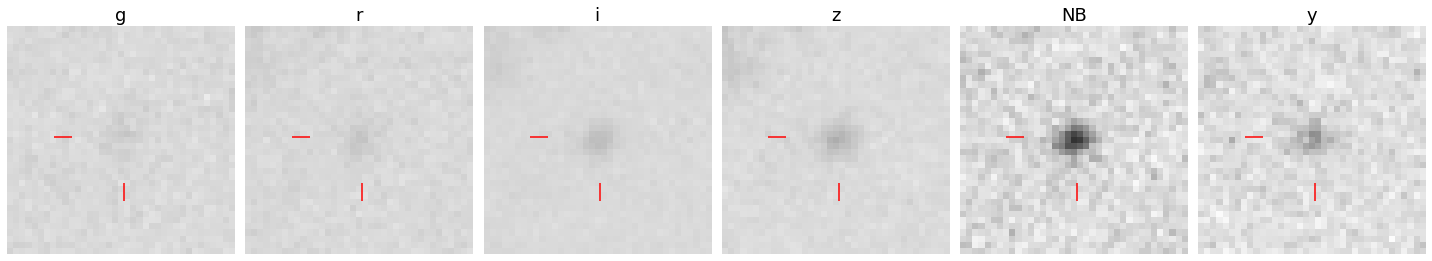

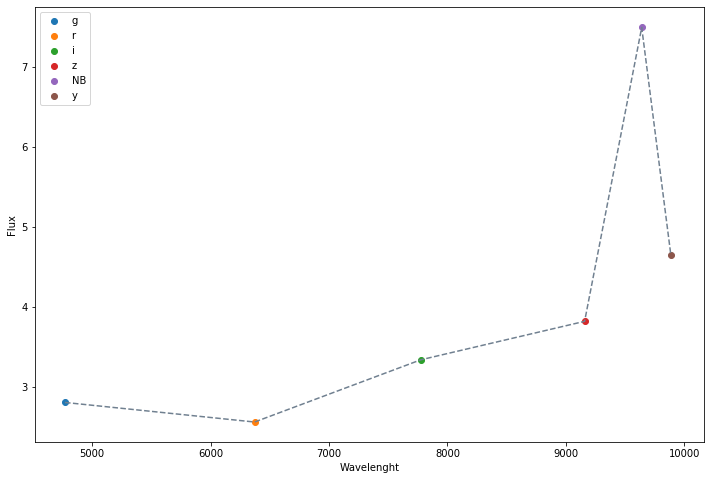

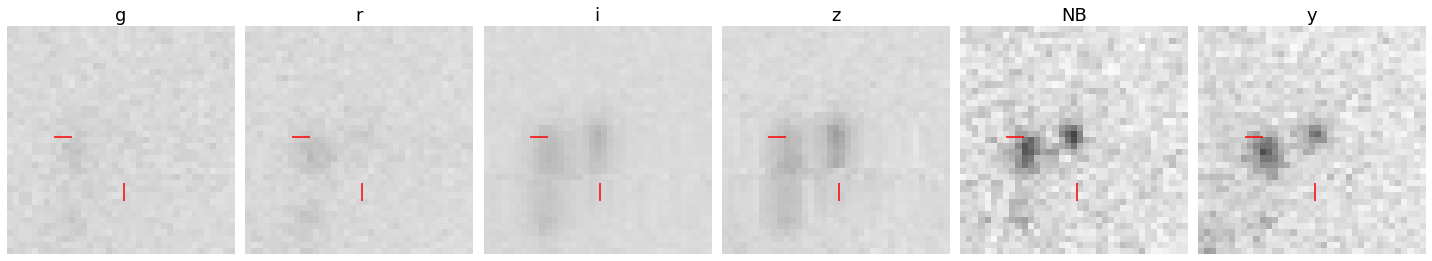

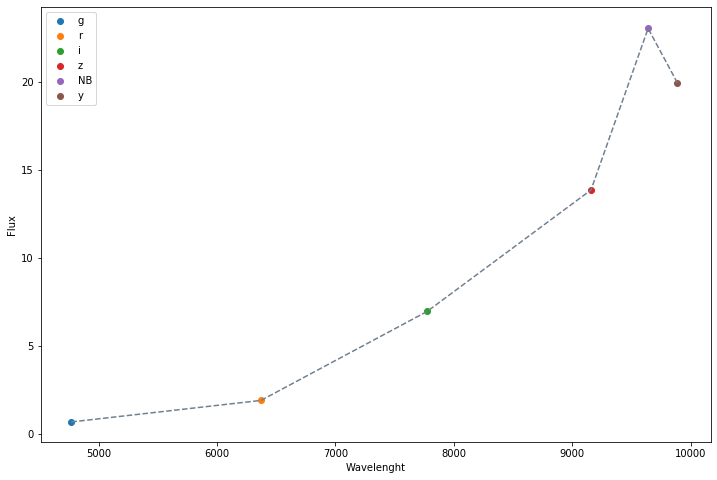

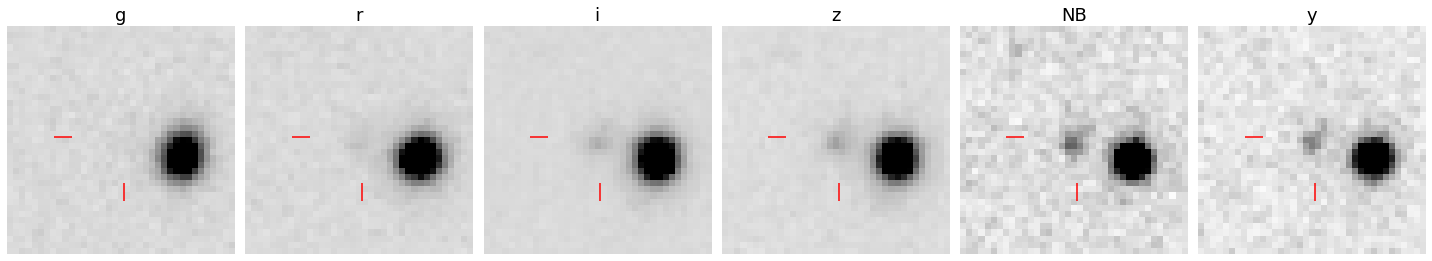

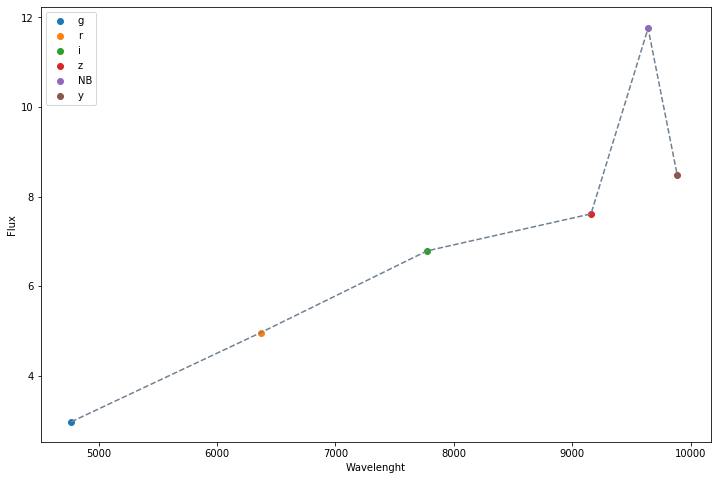

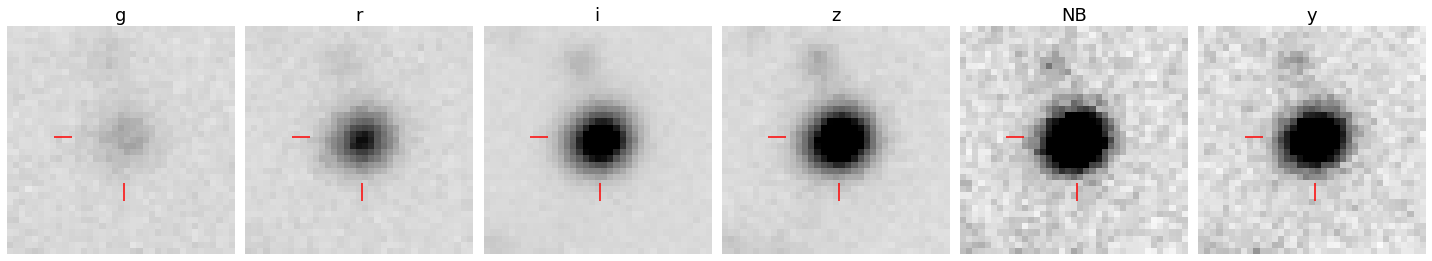

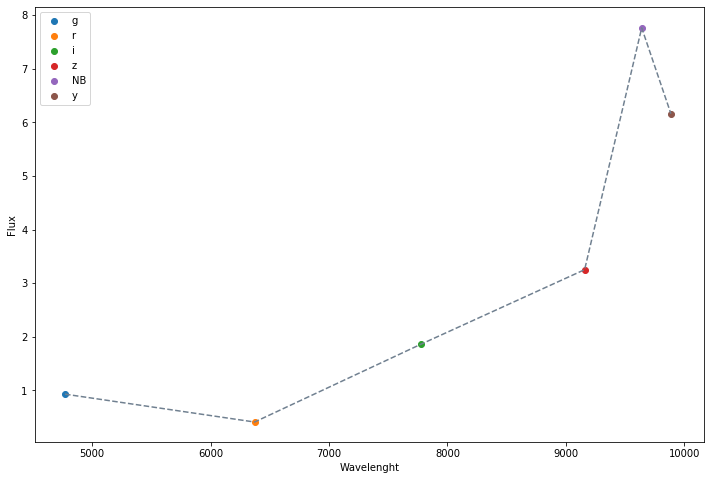

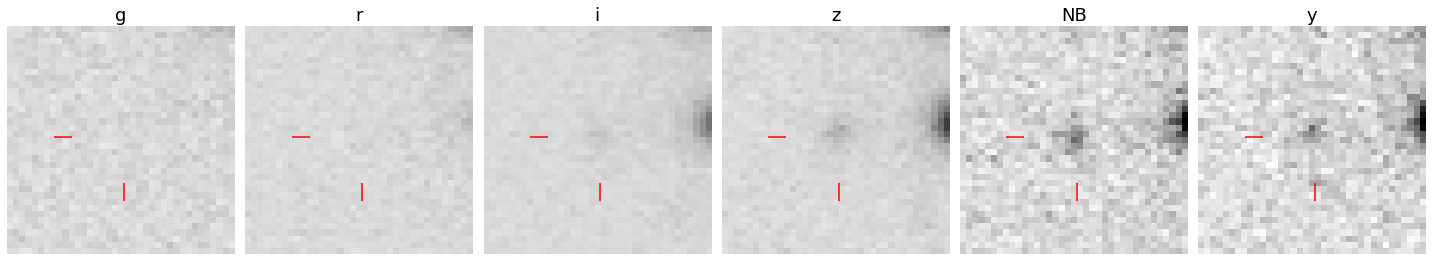

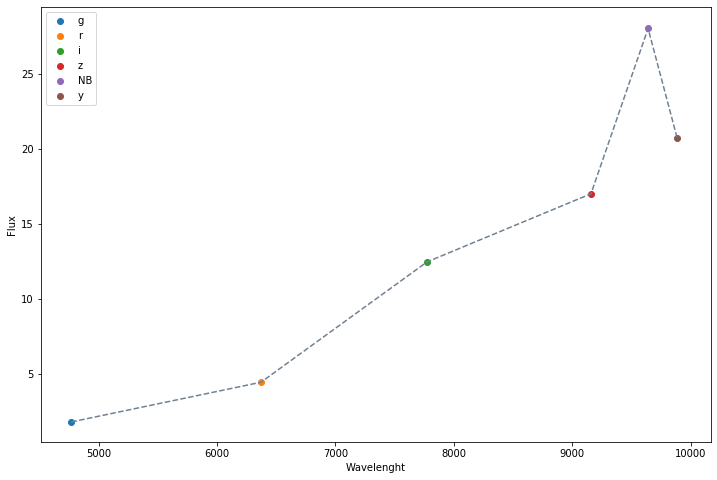

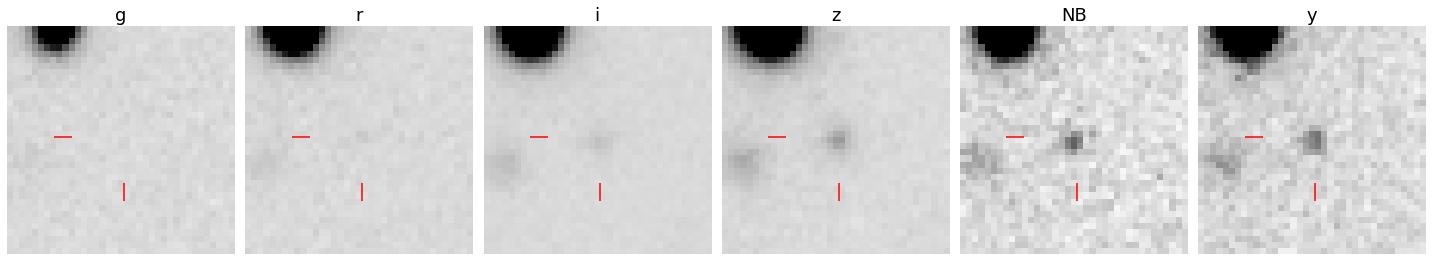

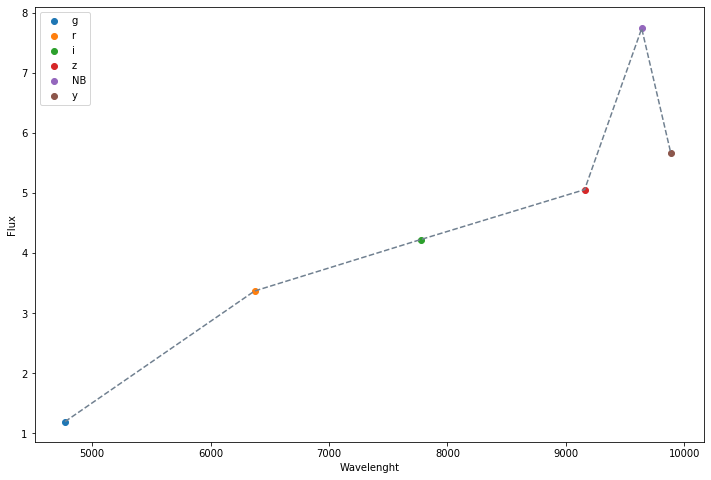

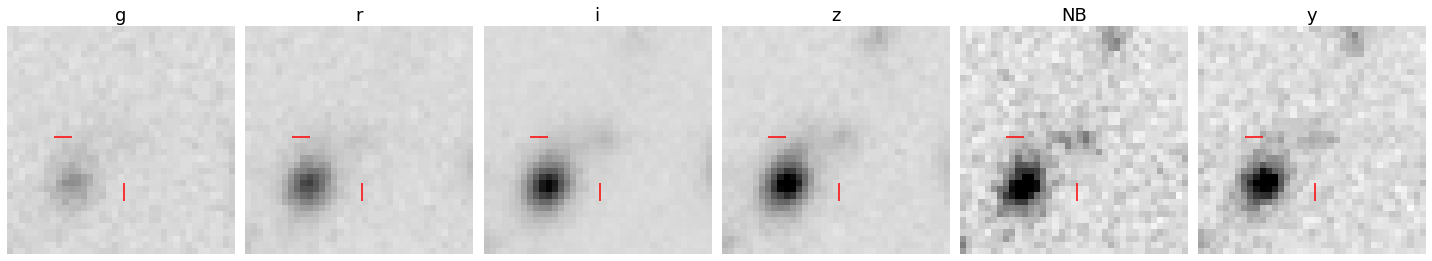

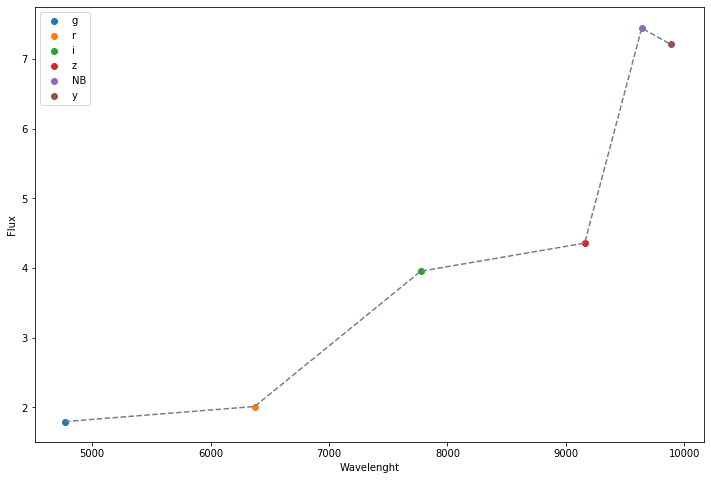

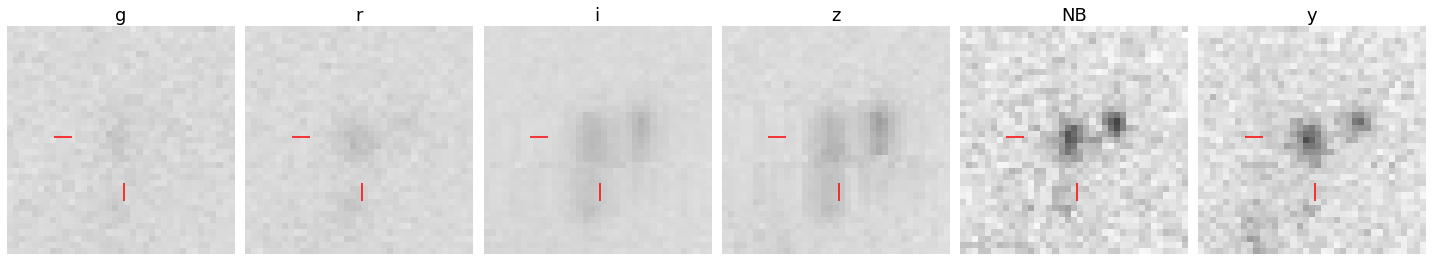

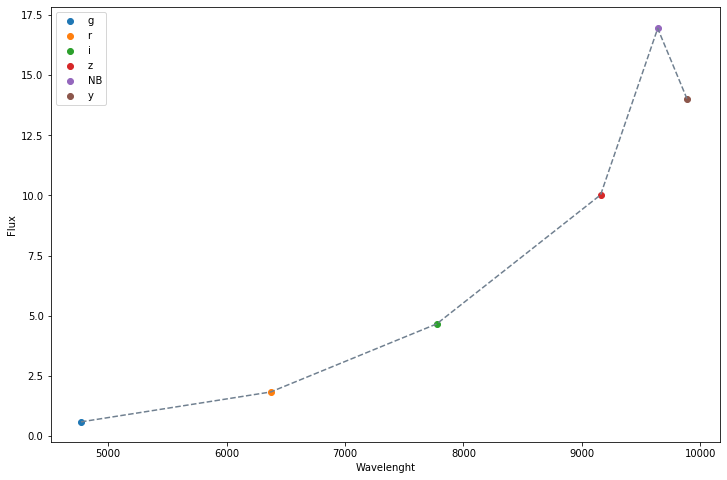

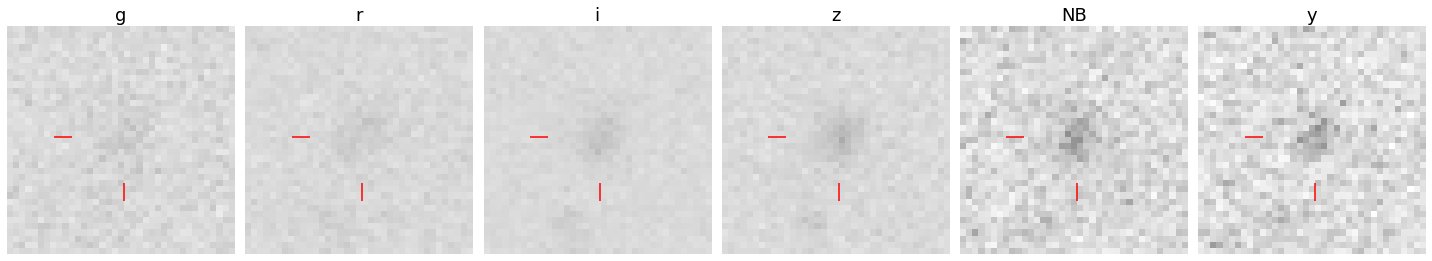

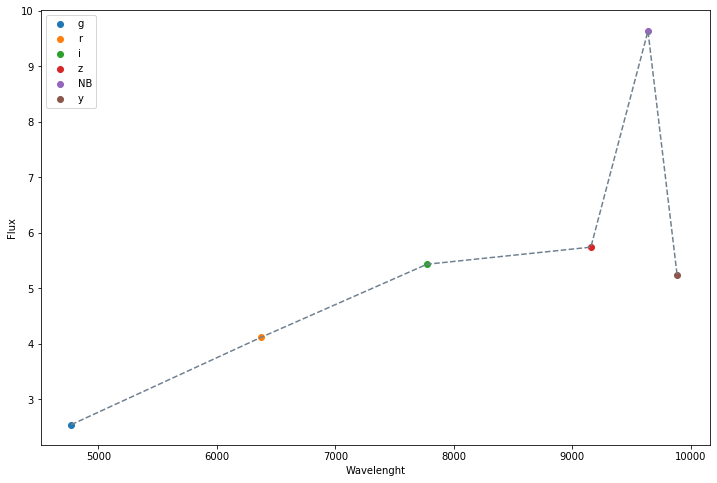

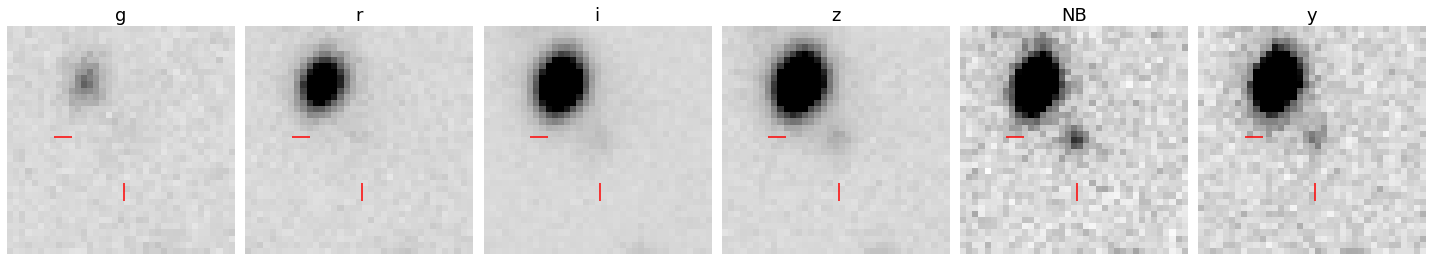

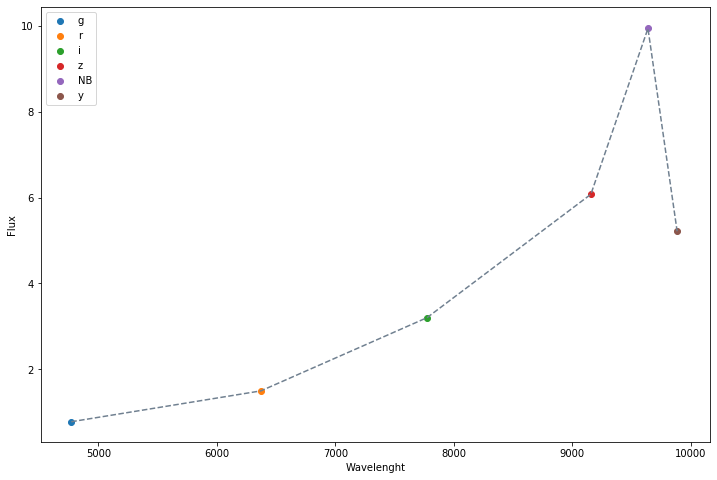

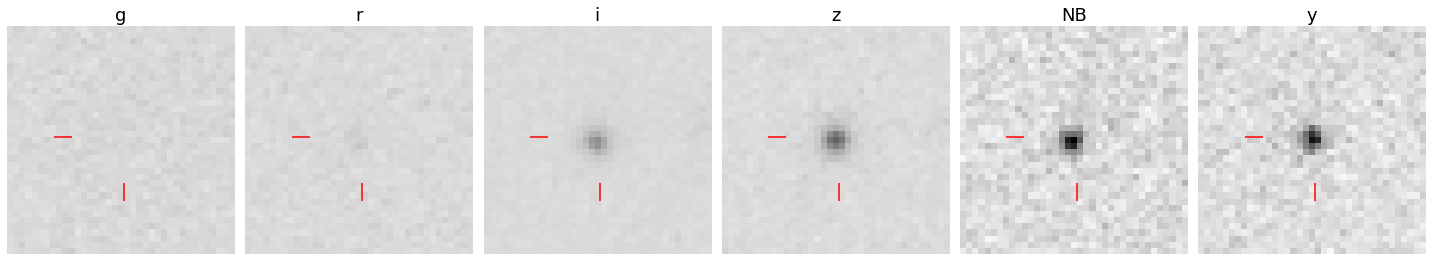

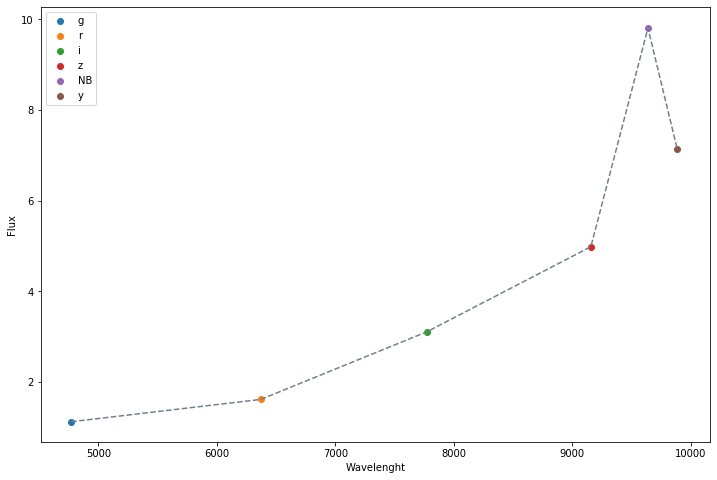

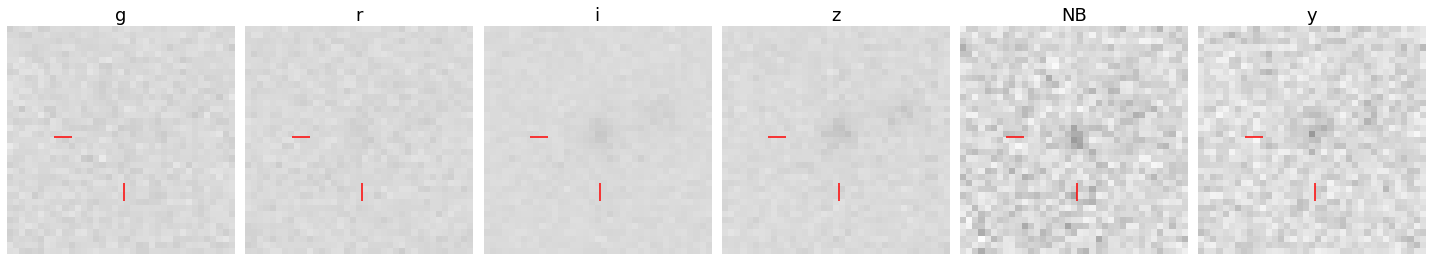

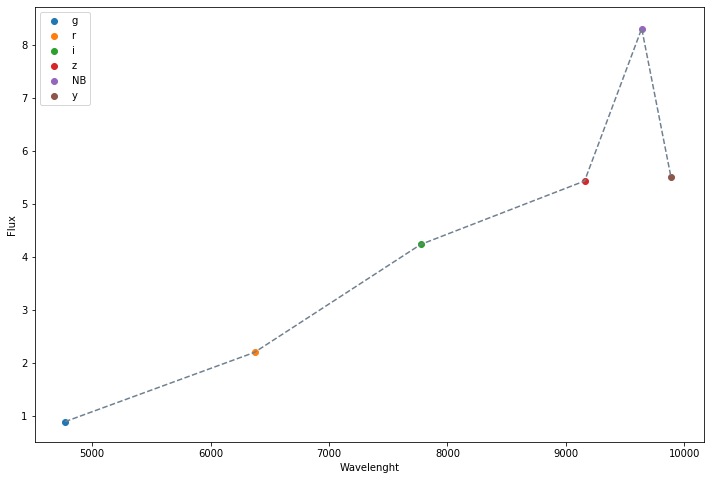

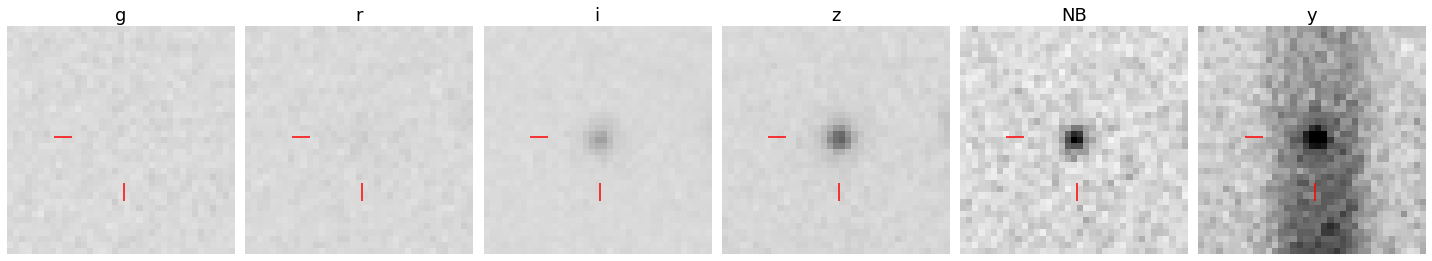

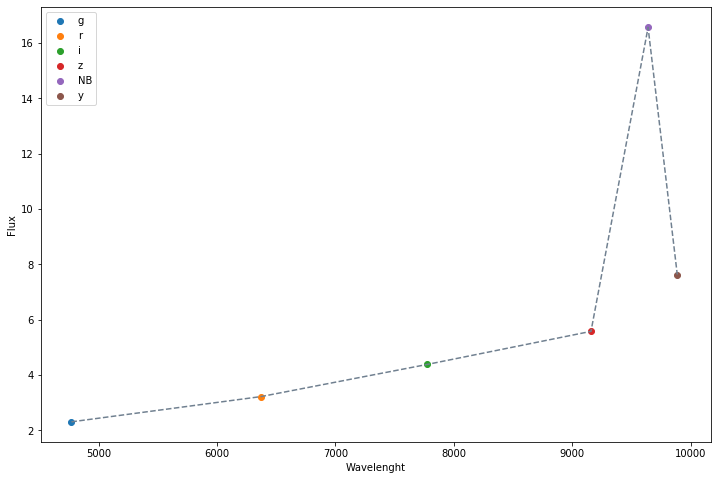

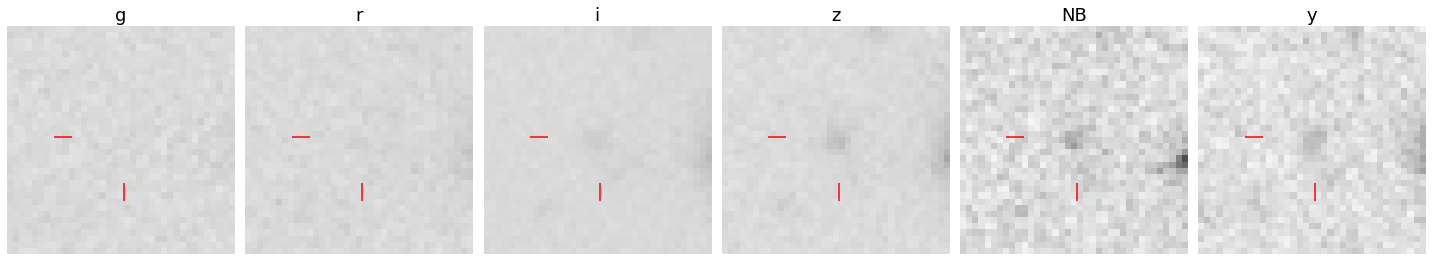

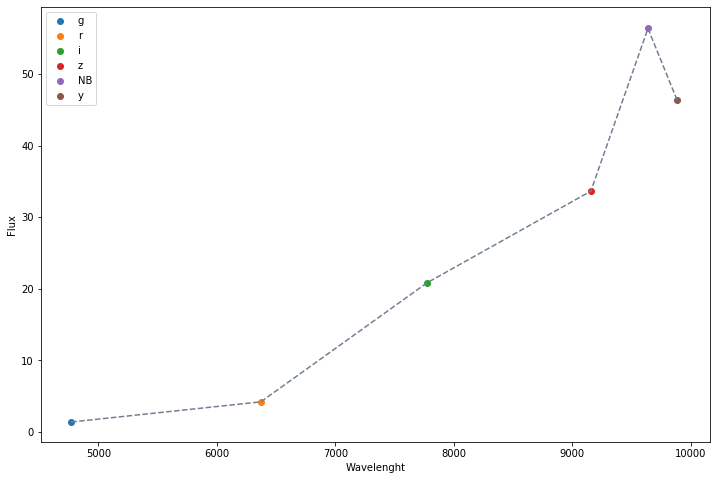

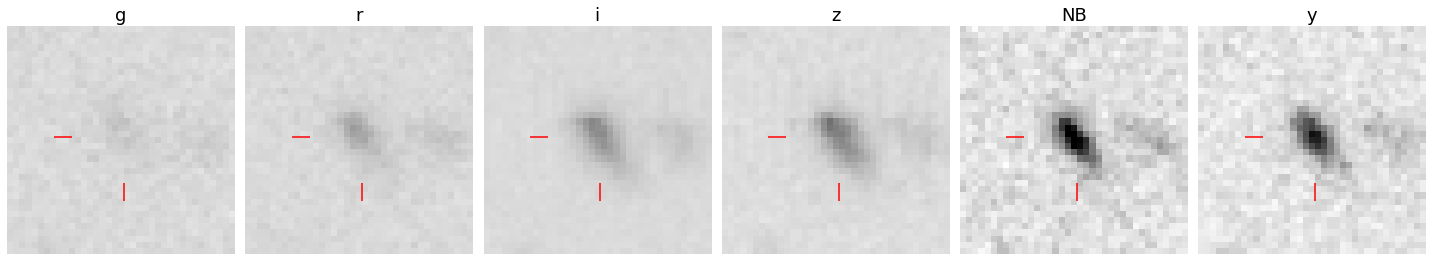

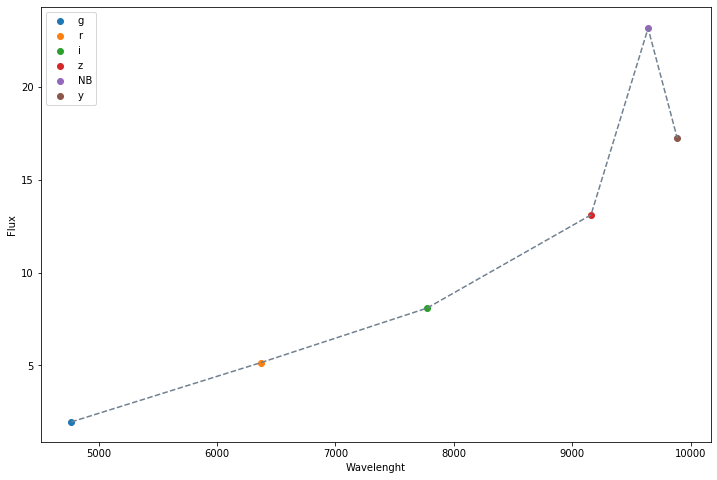

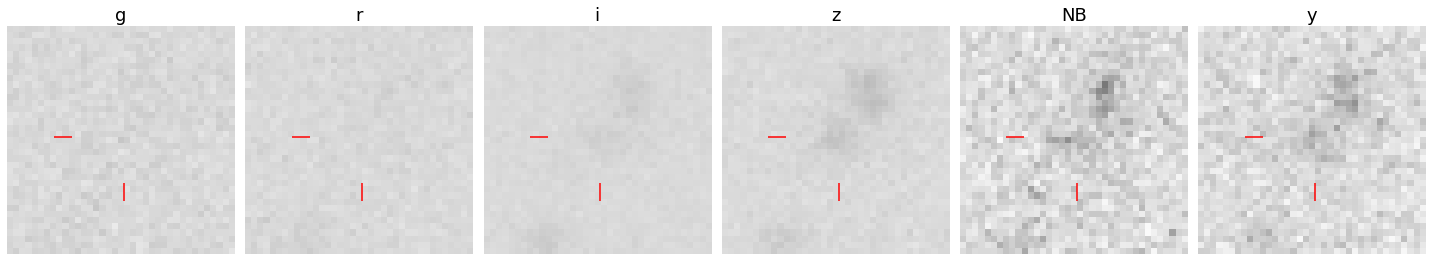

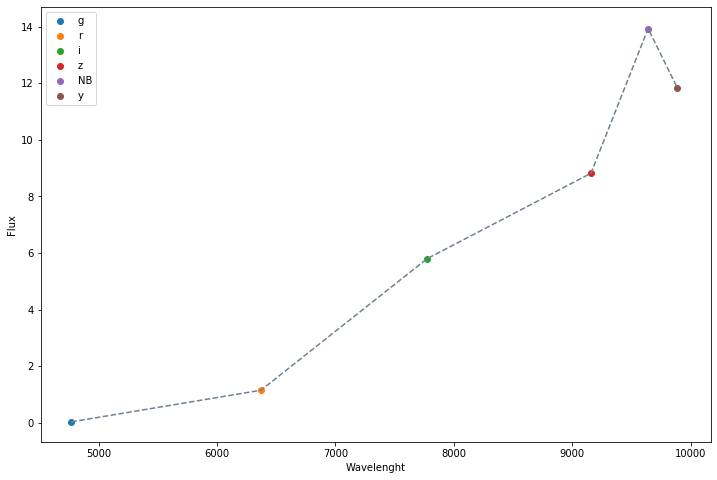

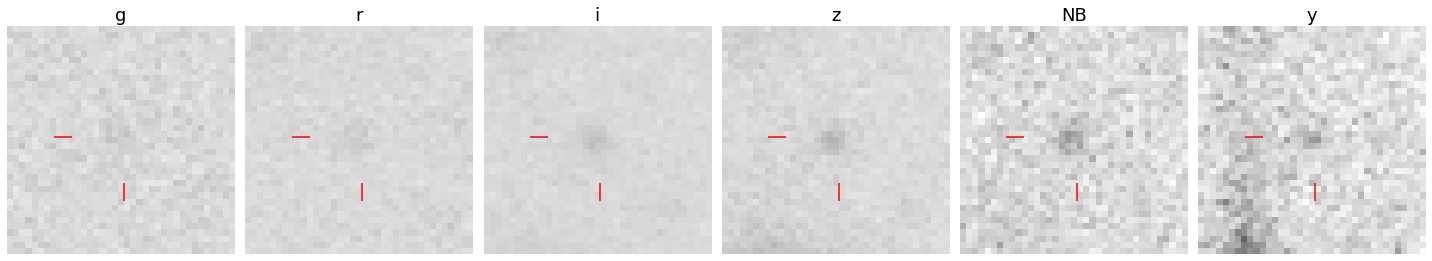

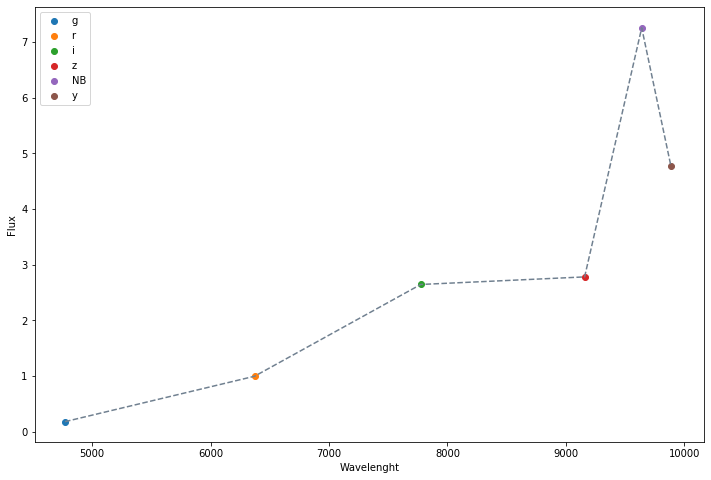

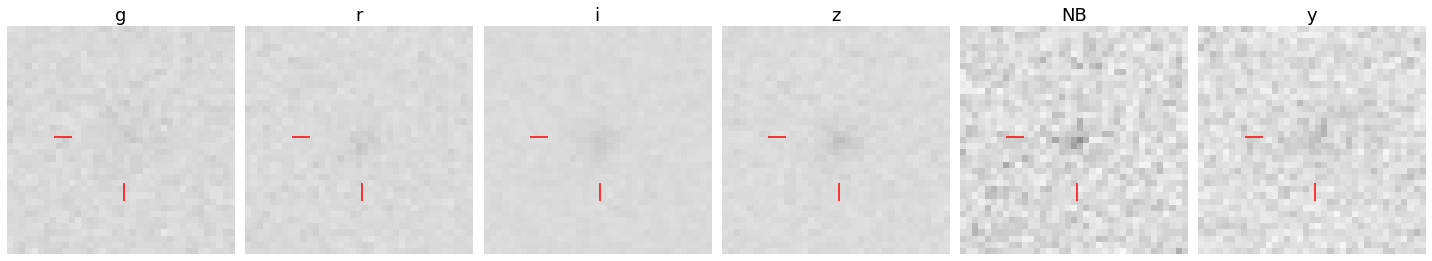

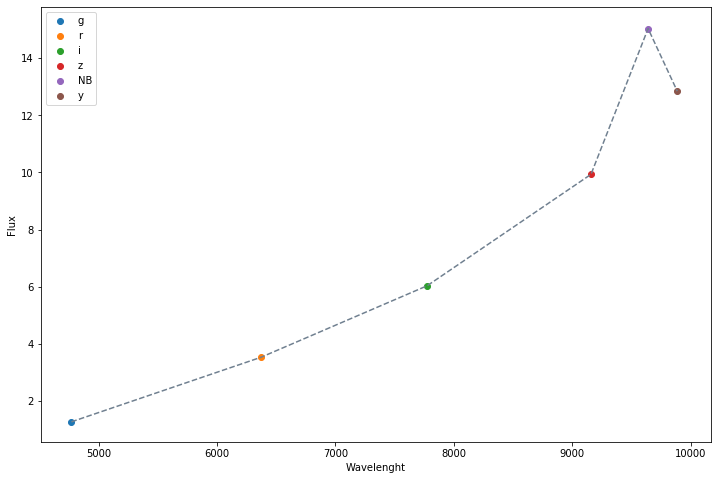

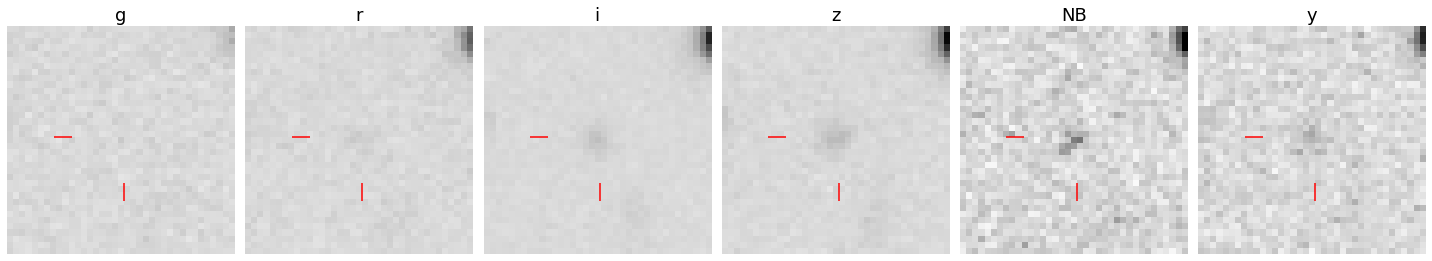

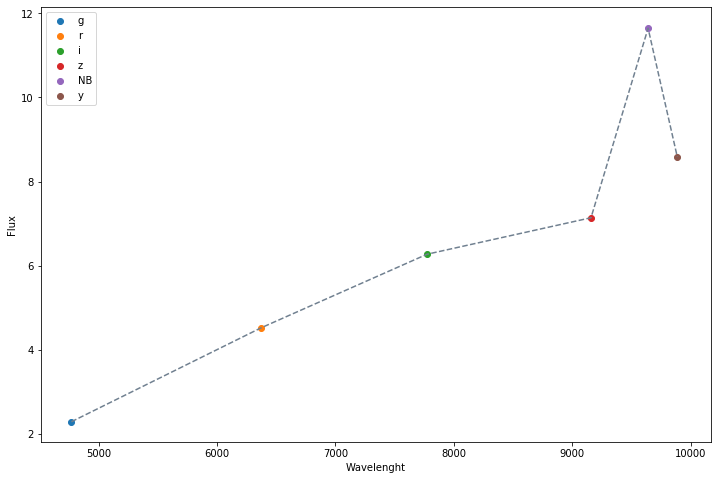

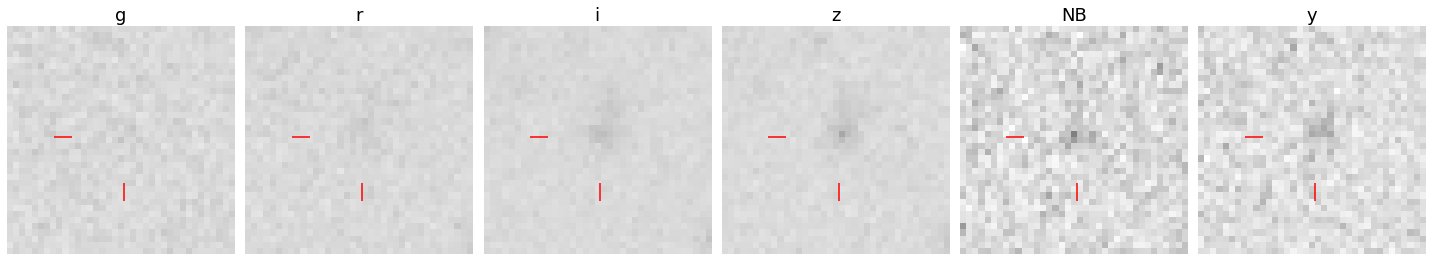

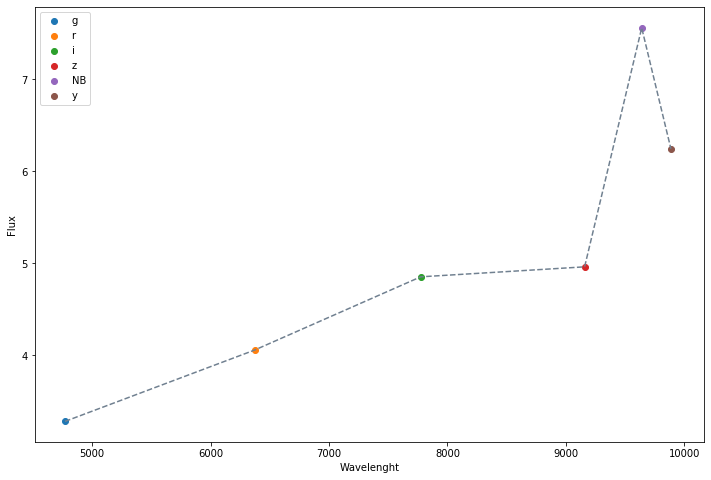

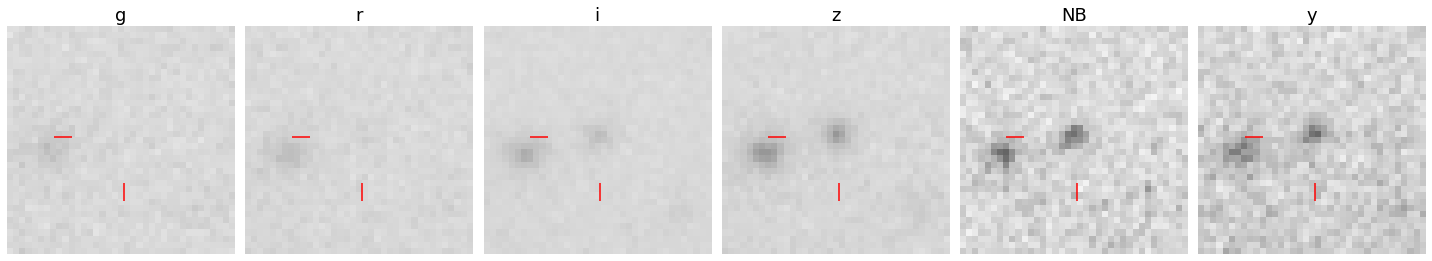

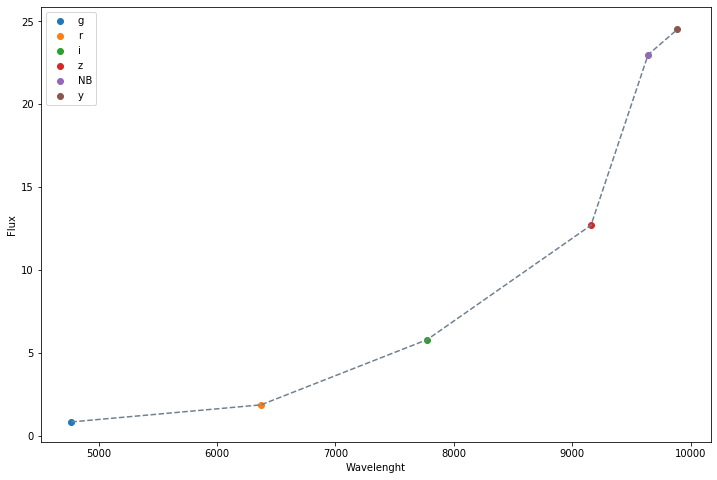

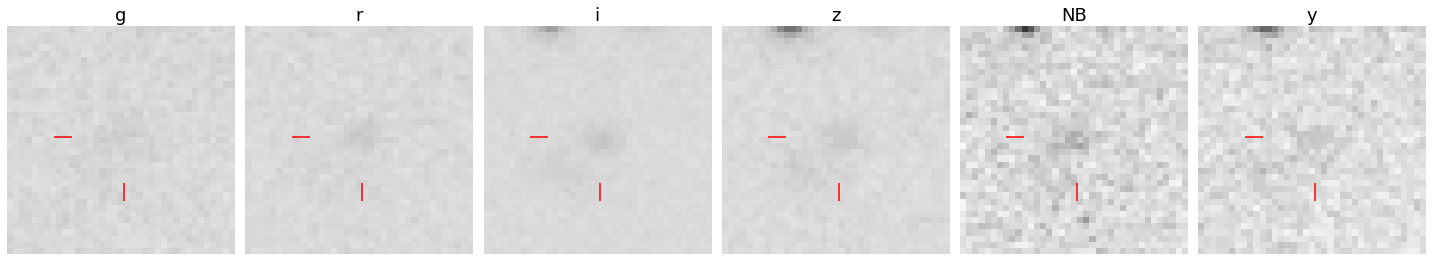

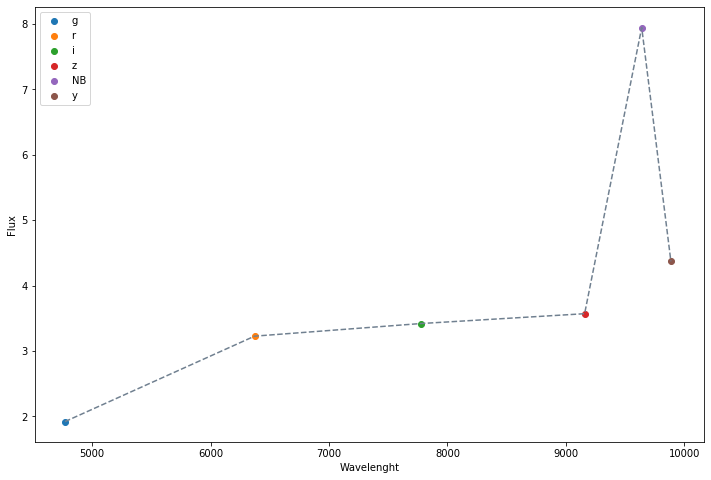

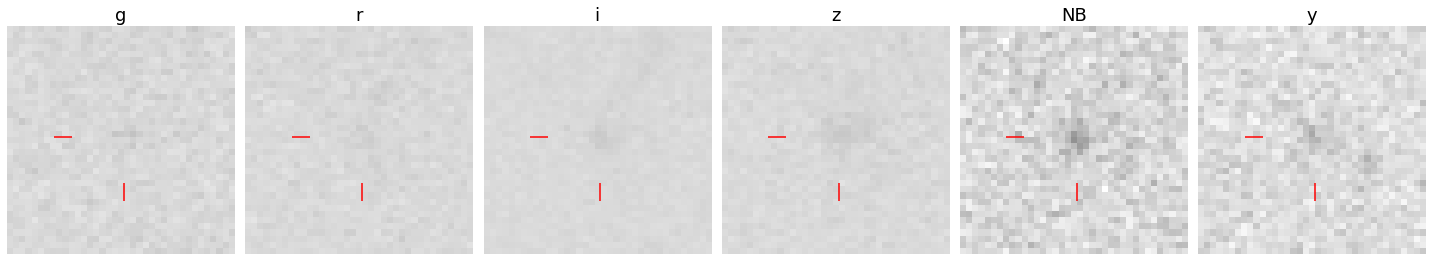

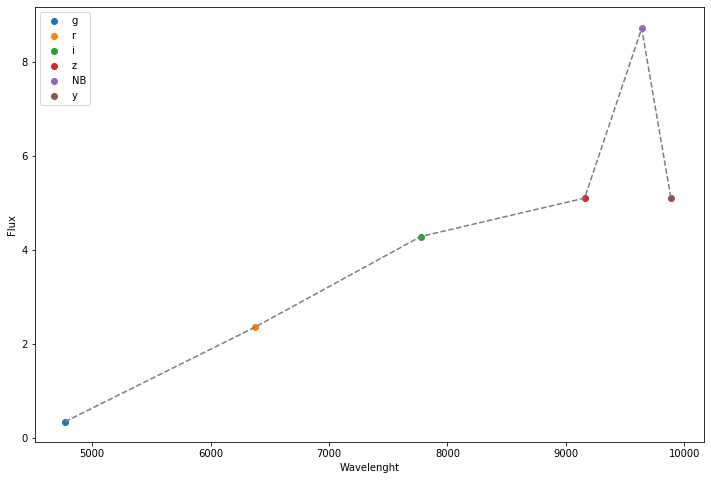

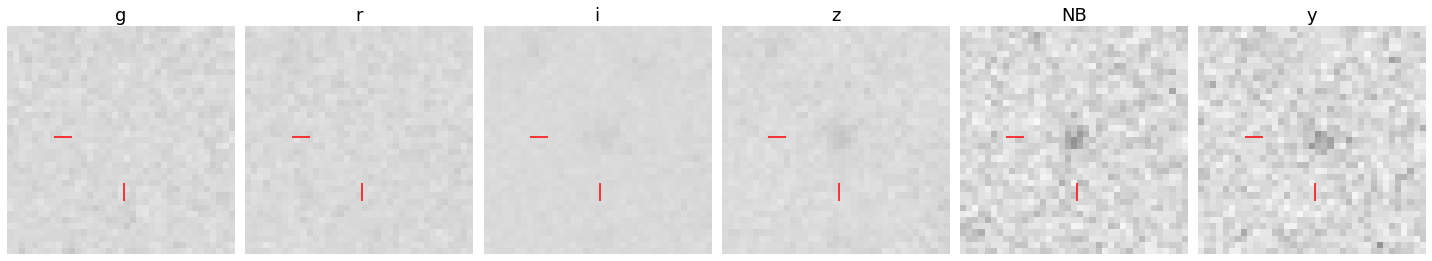

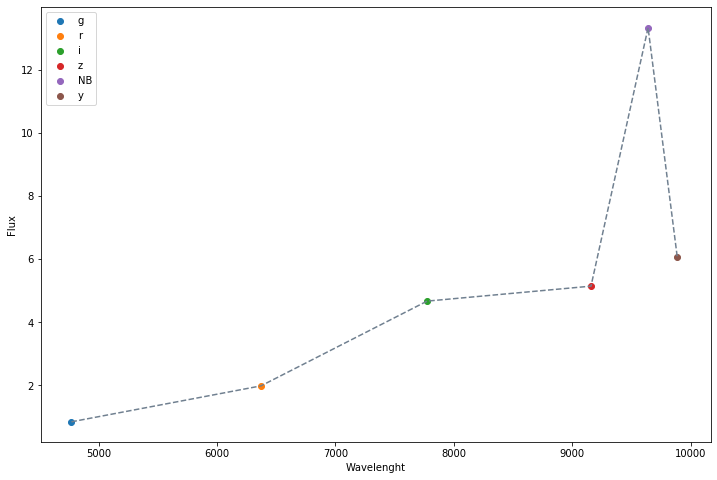

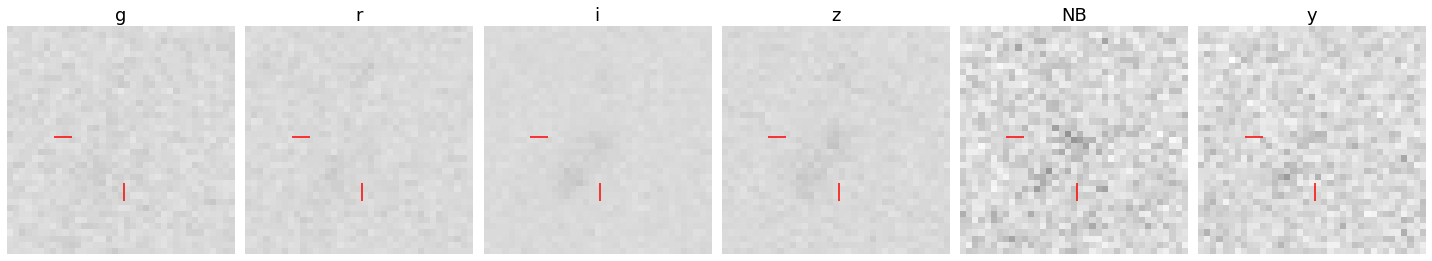

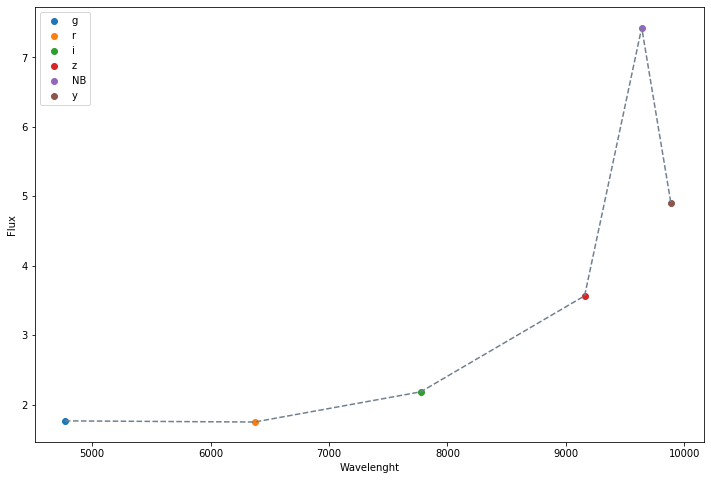

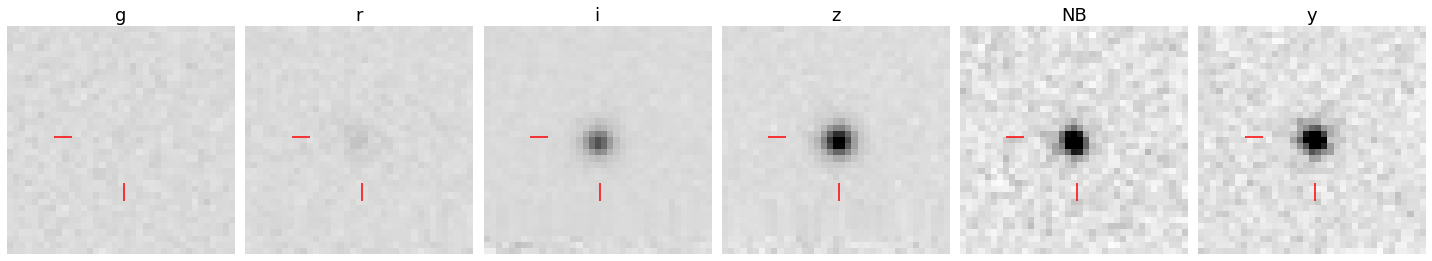

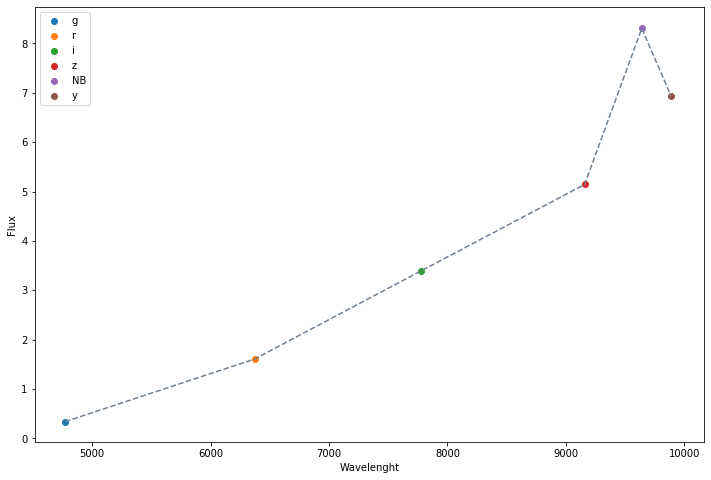

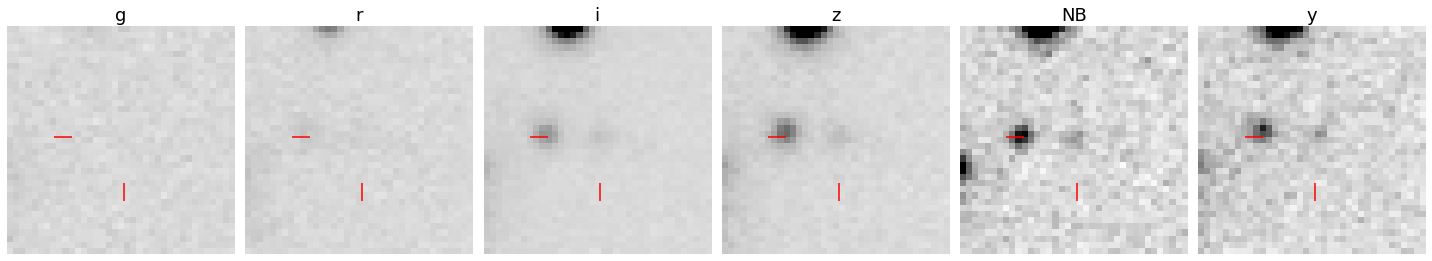

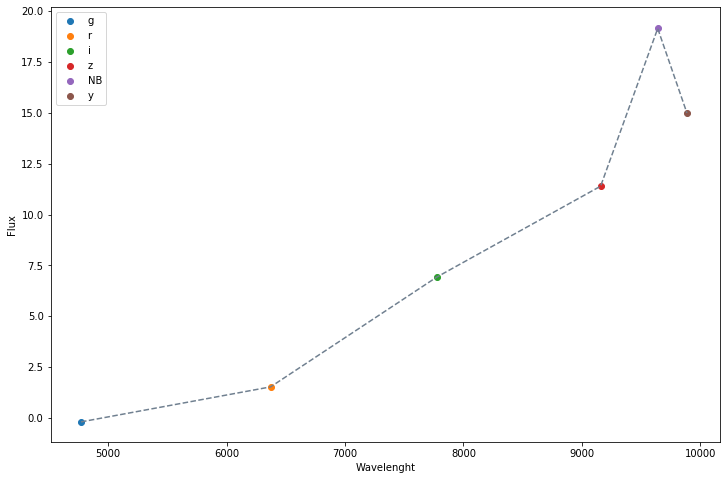

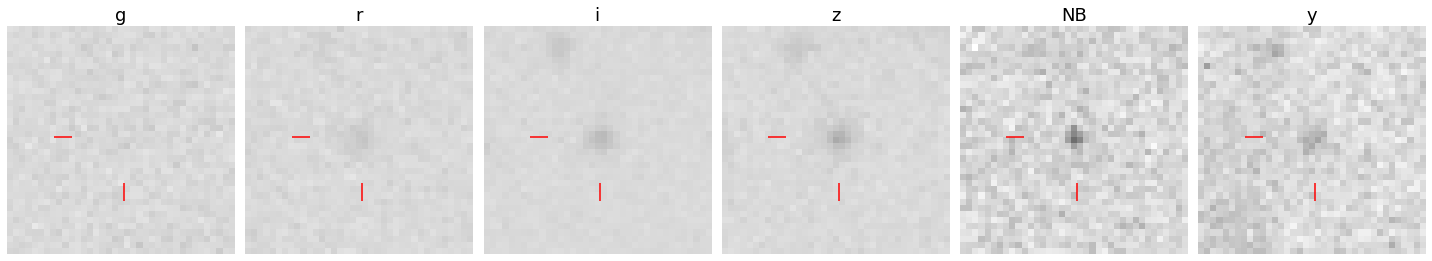

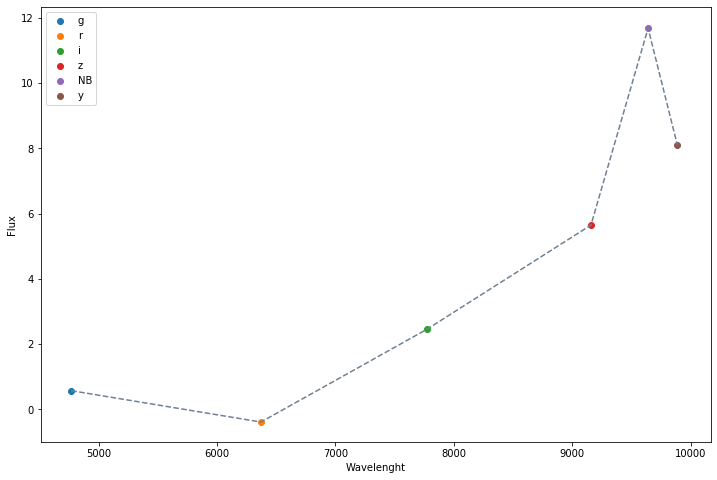

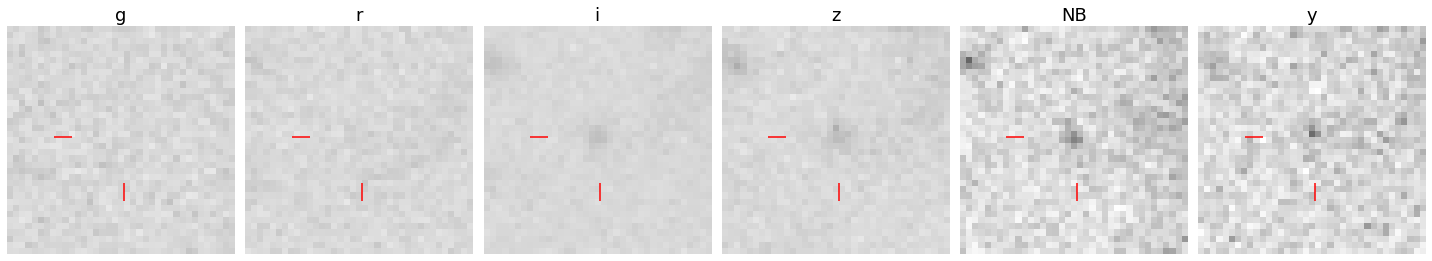

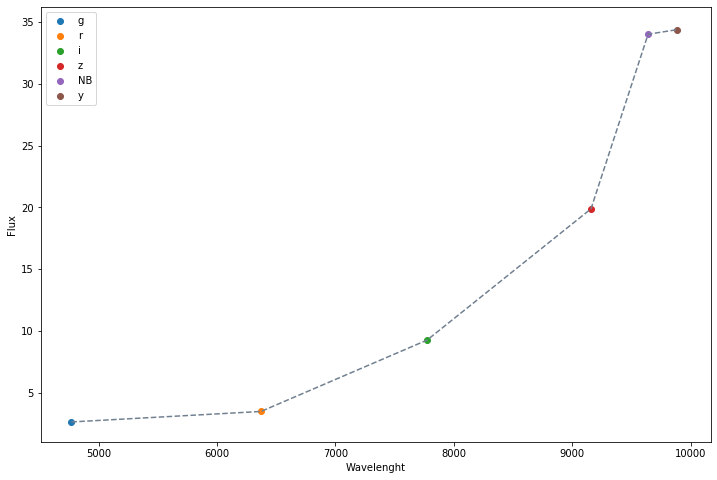

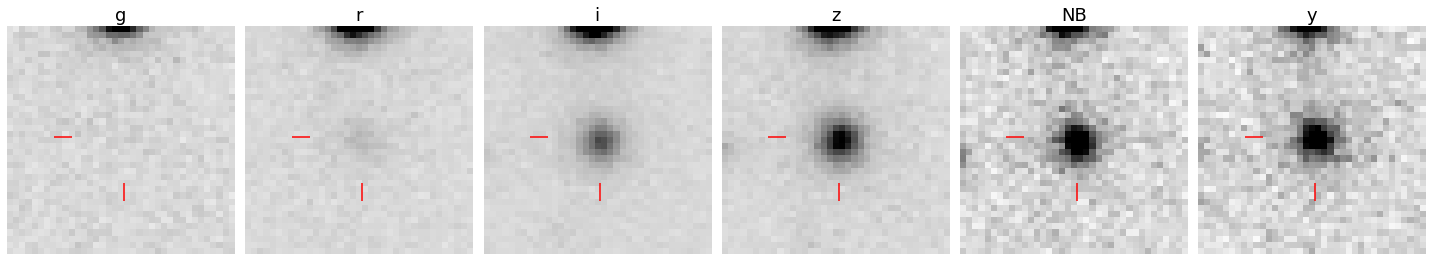

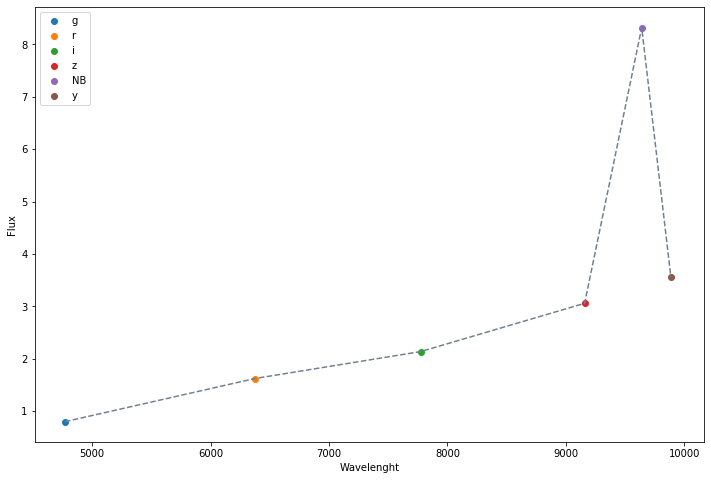

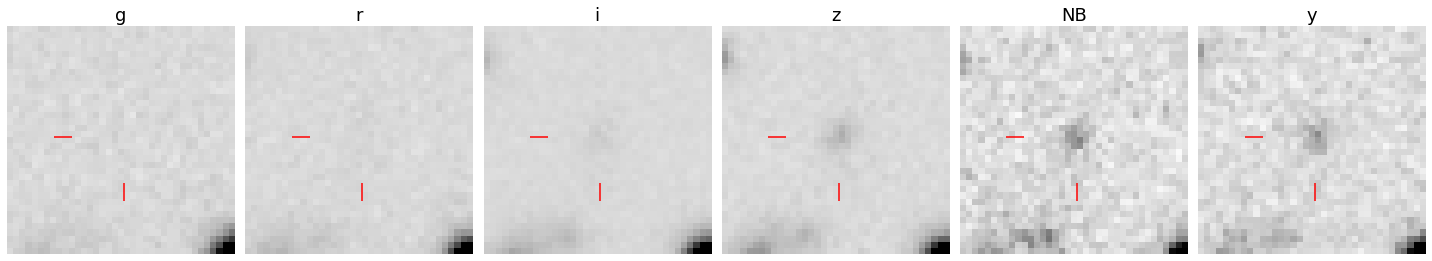

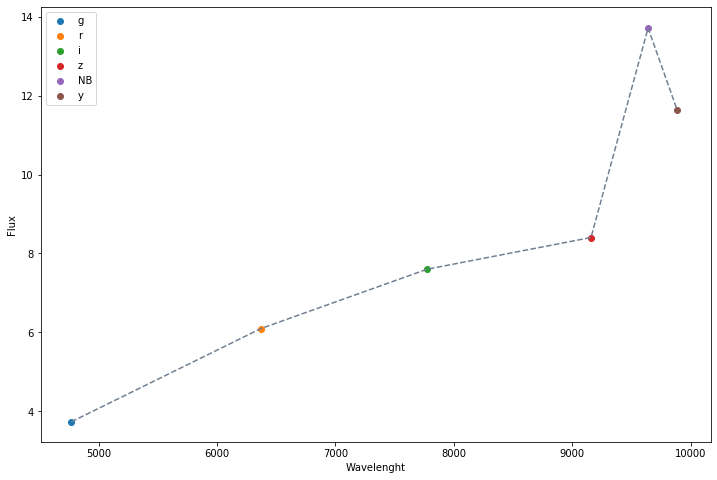

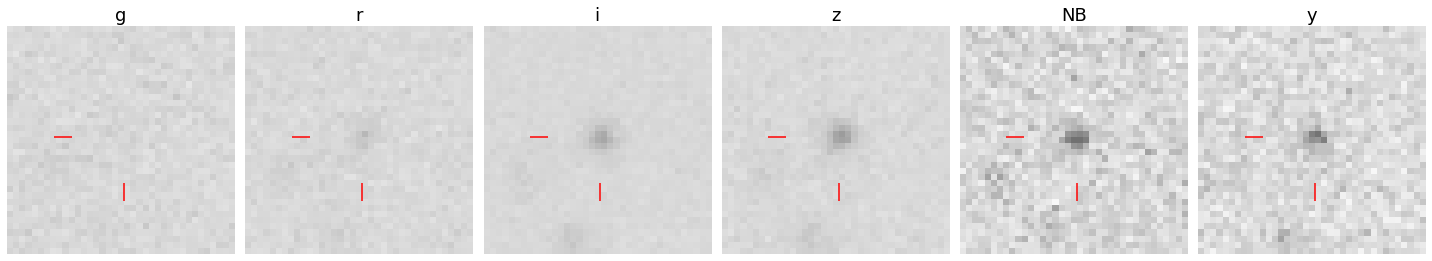

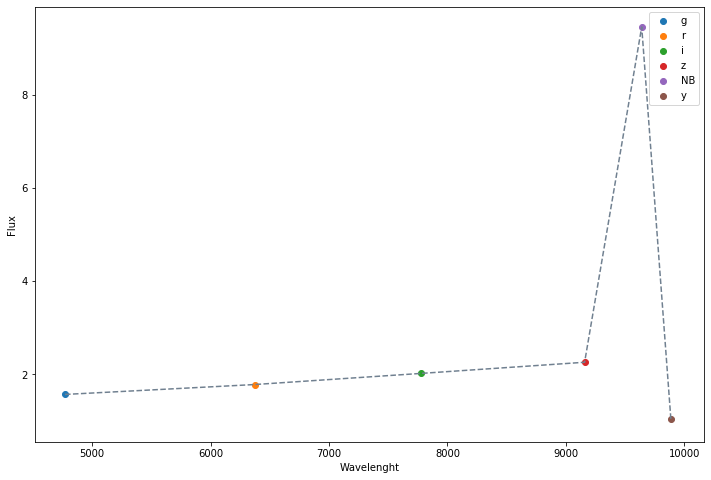

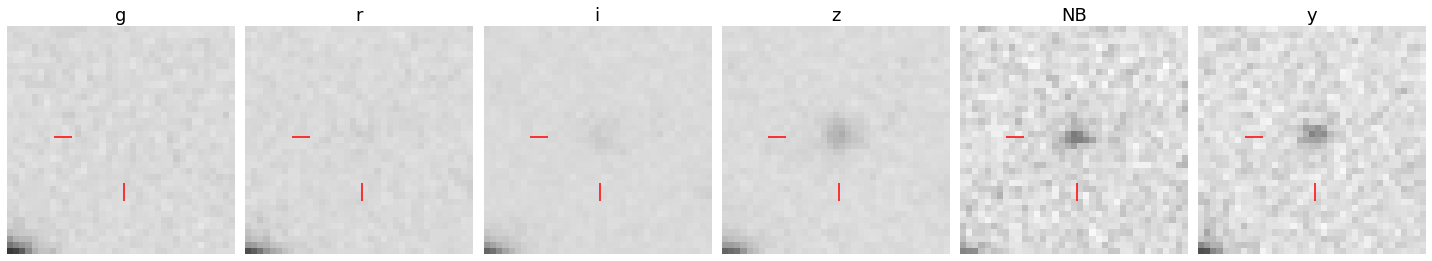

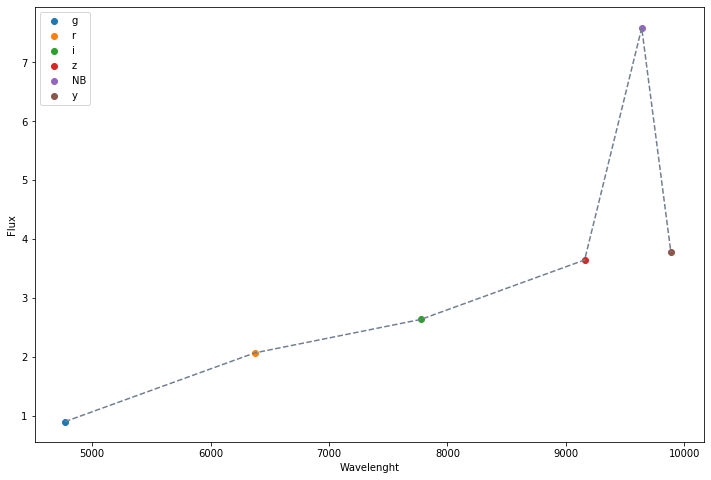

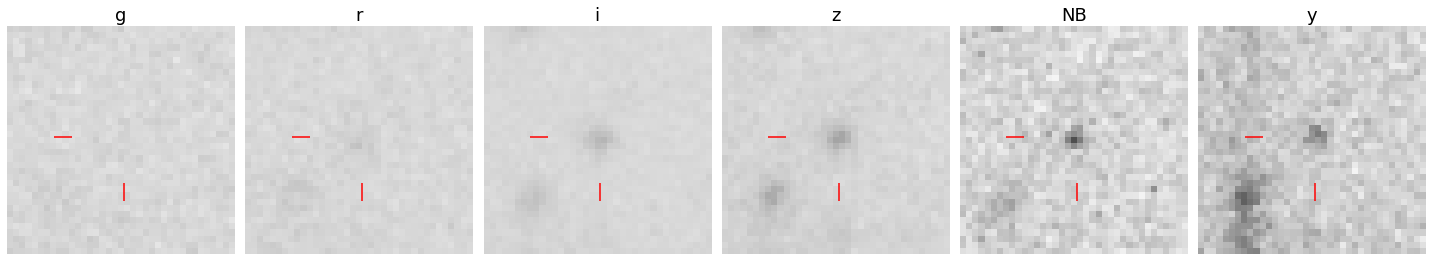

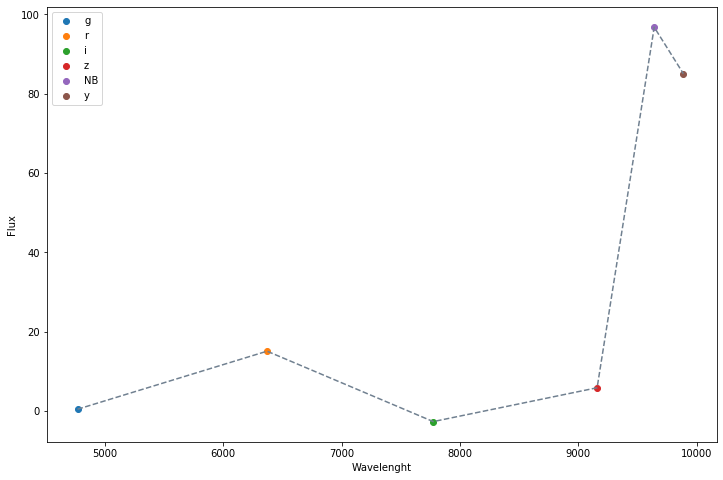

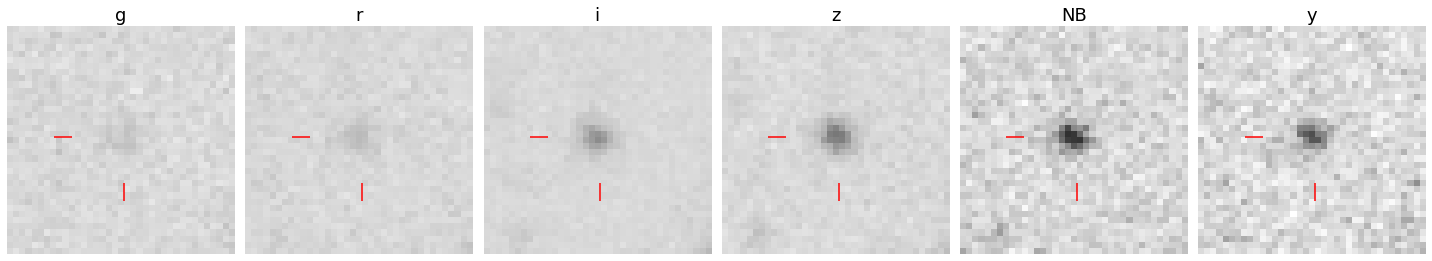

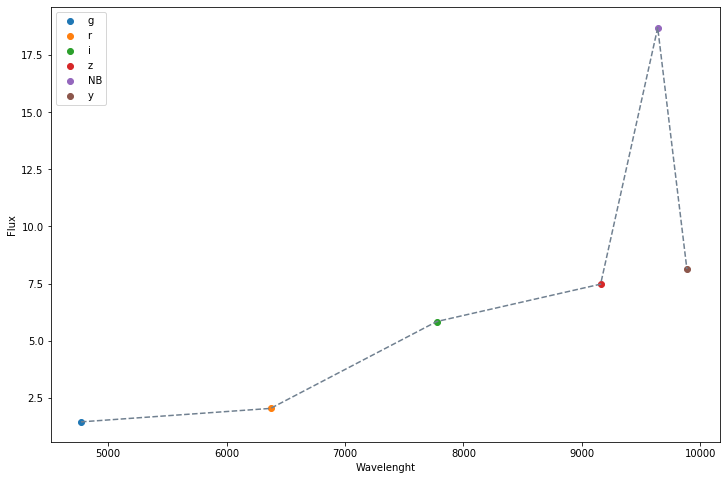

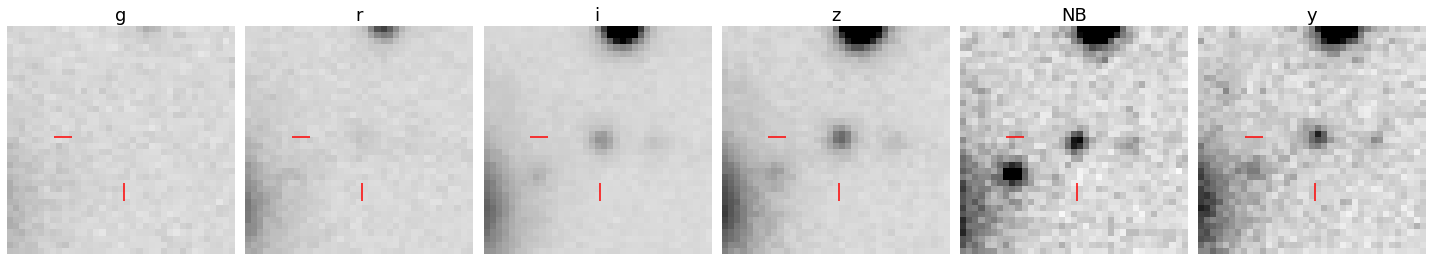

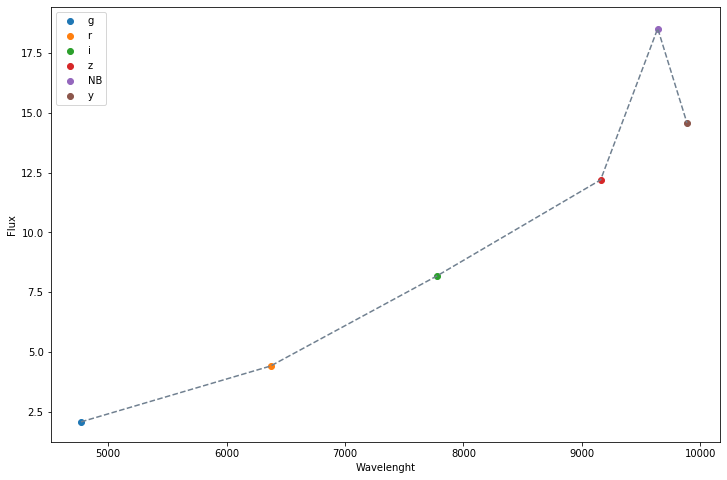

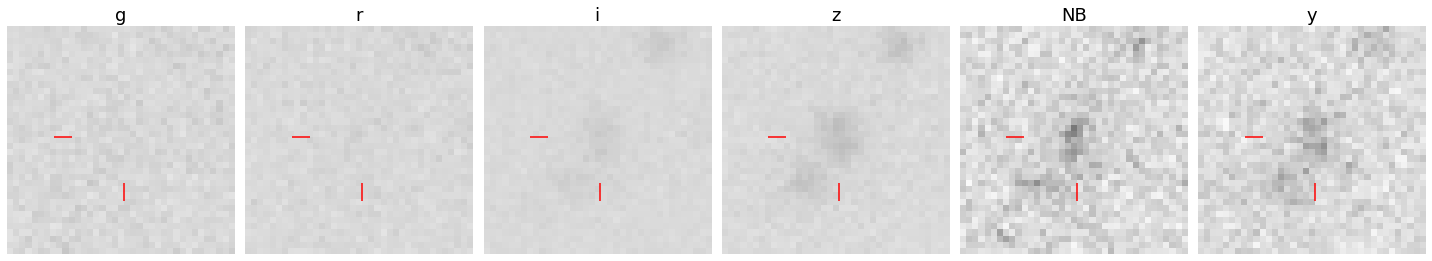

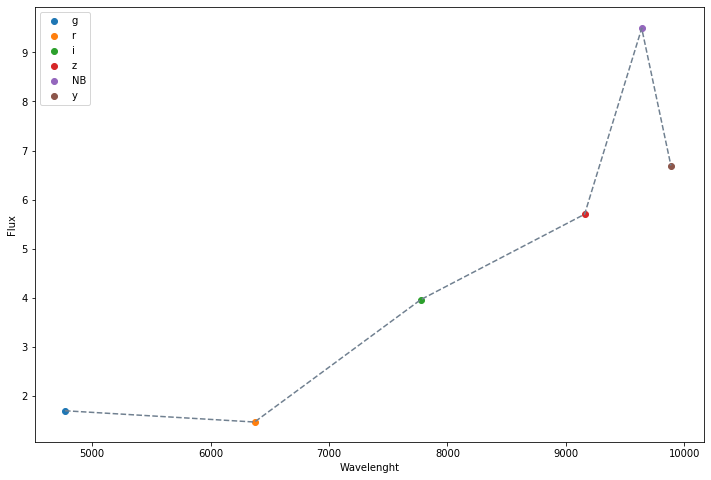

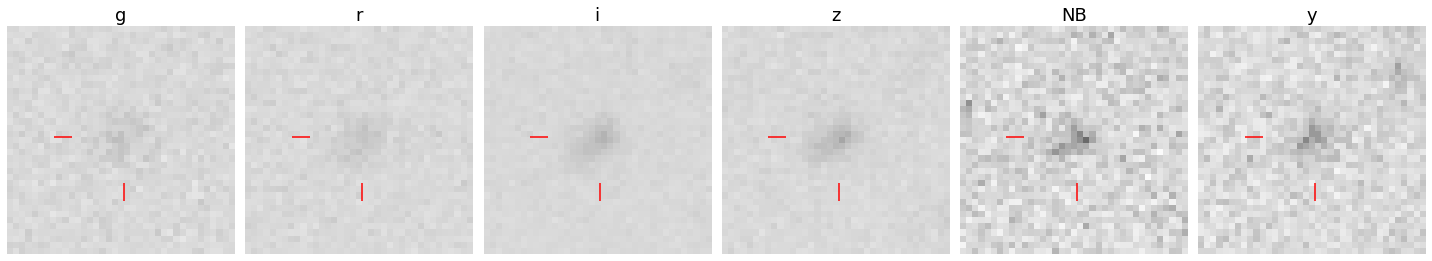

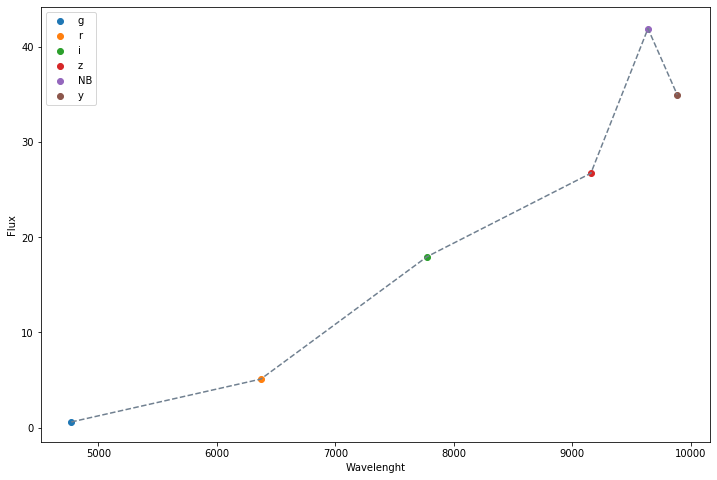

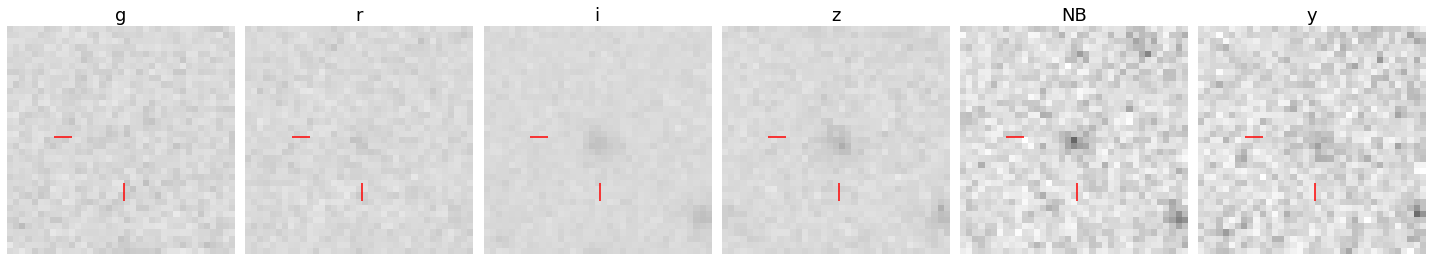

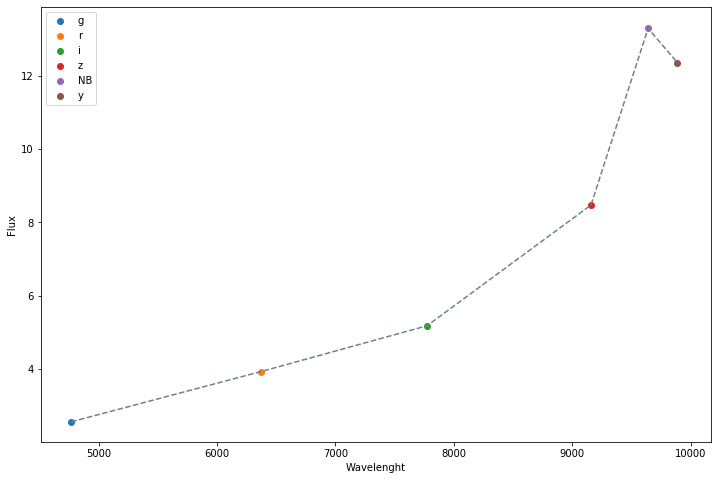

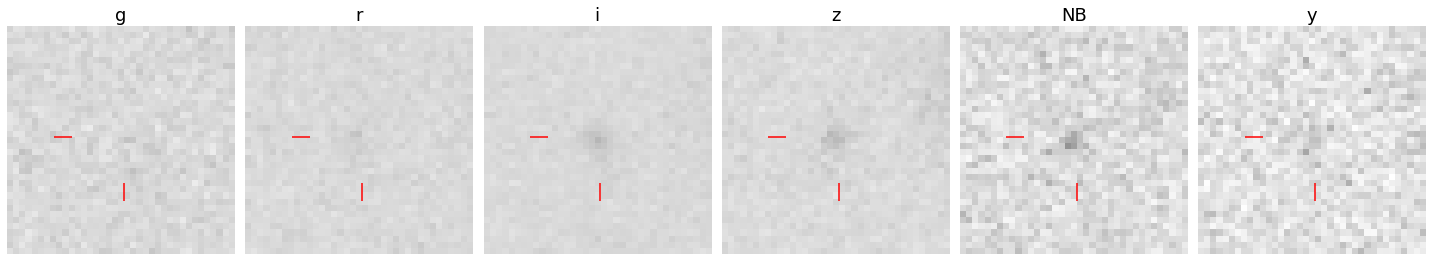

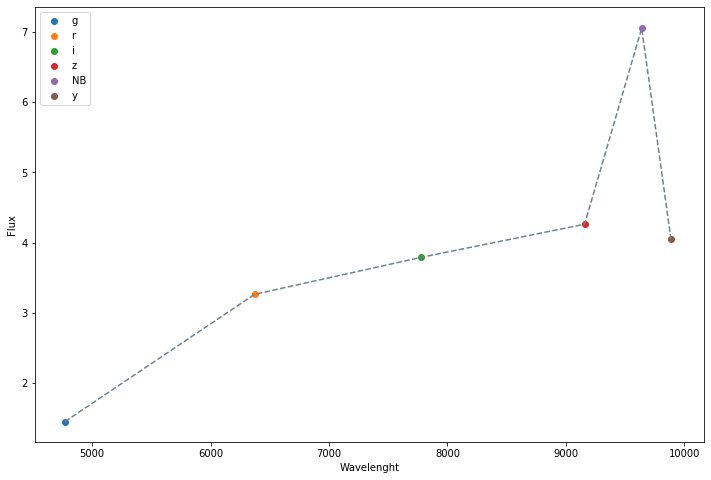

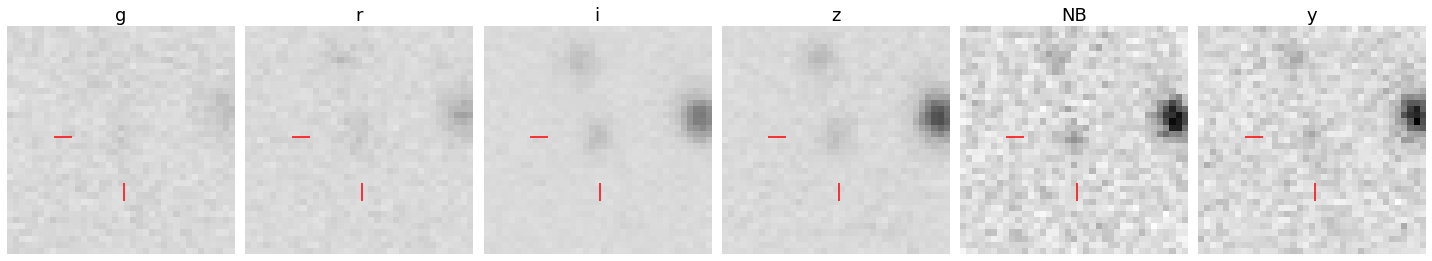

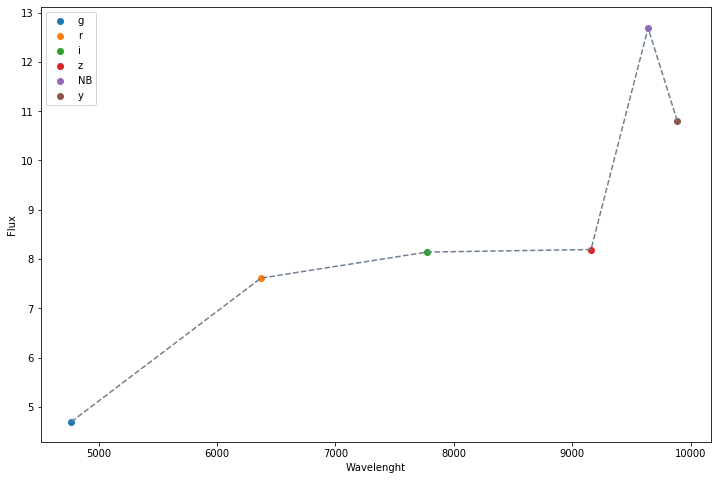

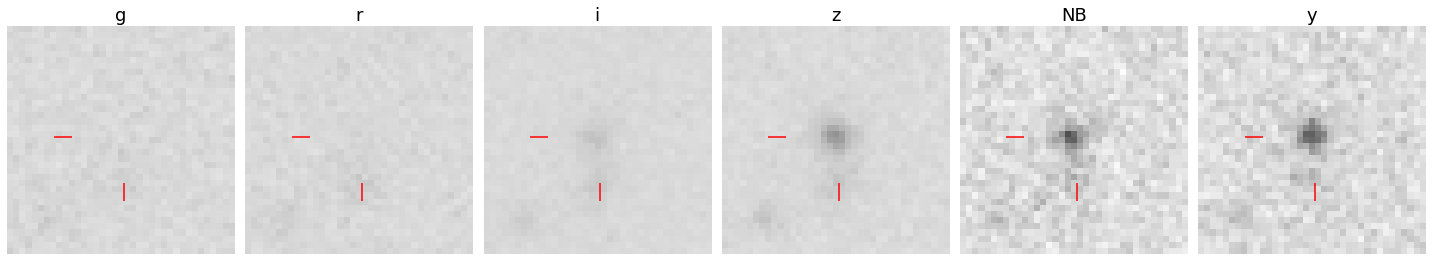

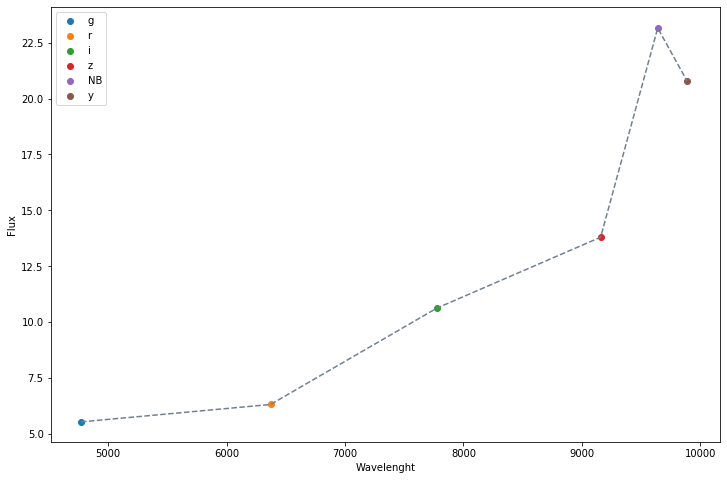

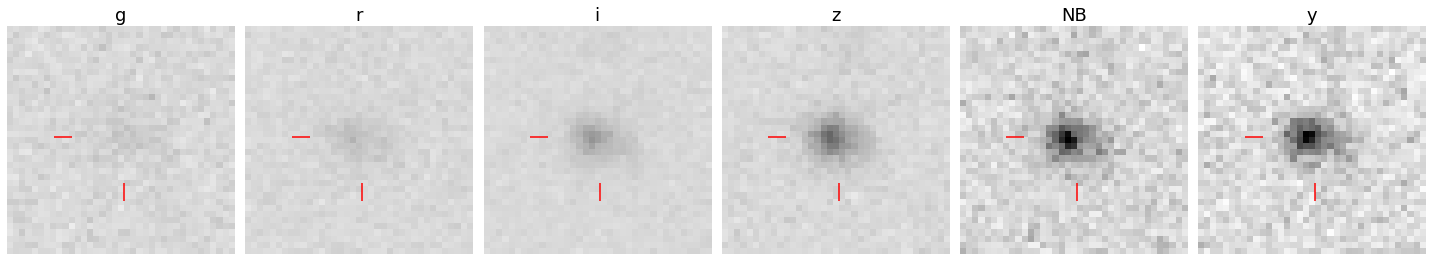

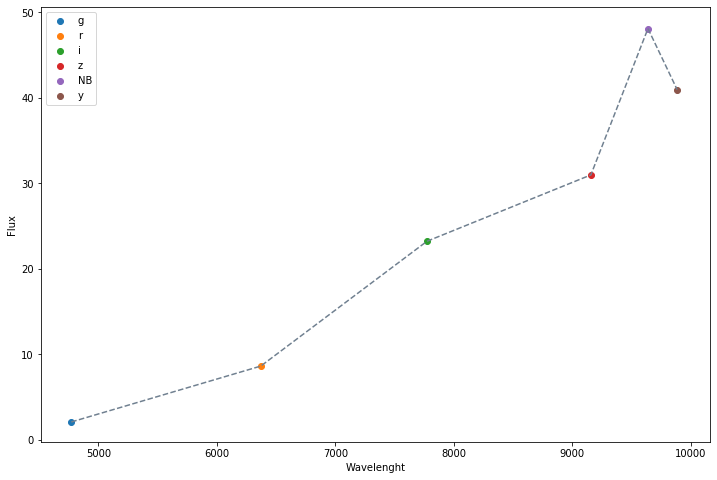

In [53]:
RA_ = data['ALPHA_J2000'][50:150]
DEC_ = data['DELTA_J2000'][50:150]

nsf_id = choosef(RA_,DEC_,info)
data_filters = [data_g, data_r, data_i, data_z,data_NB, data_y]
hdr_filters = [hdr_g, hdr_r, hdr_i, hdr_z, hdr_NB,hdr_y]
names_filters = ['g', 'r', 'i', 'z', 'NB', 'y']
flux_filters = [g,r,i,z,NB,y]
NSF_cutm = cuts_mult(nsf_id, data_filters, hdr_filters, names_filters,flux_filters, 10, 'NSF')

# Stack GRI

In [ ]:
#varianzas

NSF_g_var = fits.open('nsf_g_var.fits')
data_g_var = NSF_g_var[1].data
hdr_g_var = NSF_g_var[1].header

NSF_r_var = fits.open('nsf_r_var.fits')
data_r_var = NSF_r_var[1].data
hdr_r_var = NSF_r_var[1].header

NSF_i_var = fits.open('nsf_i_var.fits')
data_i_var = NSF_i_var[1].data
hdr_i_var = NSF_i_var[1].header

In [ ]:
#stack =(data_g * 1/data_g_var + data_r * 1/data_r_var + data_i * 1/data_i_var)/(1/data_g_var + 1/data_r_var+ 1/data_i_var)

In [ ]:
#primary_hdu = fits.PrimaryHDU(hdr_g)
#image_hdu = fits.ImageHDU(stack)
#hdul = fits.HDUList([image_hdu])
#fits.writeto('stack.fits', data = stack, overwrite= True, header = hdr_g)

In [ ]:
stack_GRI = fits.open('stack.fits')
data_GRI = stack_GRI[0].data
hdr_GRI = stack_GRI[0].header

In [ ]:
gri_id = choosef(RA,DEC,info)
gri_cut = cuts(gri_id, data_GRI, hdr_GRI, 30, 'NSF' , 'GRI')